## Preamble 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 
import scipy.optimize as opt
import pickle 

In [4]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/igoogle-drive/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/igoogle-drive/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [5]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [6]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in xrange(n):
        for j in xrange(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

## Prepare input 

In [7]:
#files , the order is as follows 
#g1,g2=0,0
#g1,g2=.01,.01
#g1,g2=-.01,-.01
#g1,g2=.02,.02
#g1,g2=-.02,-.02
#respectively. 
files = dict(
final_fitsLSST1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-20/final_fits.fits', 
final_fitsLSST2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-15/final_fits.fits', 
final_fitsLSST3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-10/final_fits.fits', 
final_fitsLSST4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-5/final_fits.fits', 
final_fitsLSST5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_0/final_fits.fits', 
final_fitsLSST6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_5/final_fits.fits', 
final_fitsLSST7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_10/final_fits.fits', 
final_fitsLSST8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_15/final_fits.fits', 
final_fitsLSST9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20/final_fits.fits', 
    
final_fits2LSST1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-20-g2_0/final_fits.fits', 
final_fits2LSST2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-15-g2_0/final_fits.fits', 
final_fits2LSST3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-10-g2_0/final_fits.fits', 
final_fits2LSST4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-5-g2_0/final_fits.fits', 
final_fits2LSST5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_0-g2_0/final_fits.fits', 
final_fits2LSST6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_5-g2_0/final_fits.fits', 
final_fits2LSST7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_10-g2_0/final_fits.fits', 
final_fits2LSST8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_15-g2_0/final_fits.fits', 
final_fits2LSST9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20-g2_0/final_fits.fits', 
    
Ffinal_fitsLSST1 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_-20-g2_0/final_fits.fits', 
Ffinal_fitsLSST2 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_-15-g2_0/final_fits.fits', 
Ffinal_fitsLSST3 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_-10-g2_0/final_fits.fits', 
Ffinal_fitsLSST4 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_-5-g2_0/final_fits.fits', 
Ffinal_fitsLSST5 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_0-g2_0/final_fits.fits', 
Ffinal_fitsLSST6 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_5-g2_0/final_fits.fits', 
Ffinal_fitsLSST7 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_10-g2_0/final_fits.fits', 
Ffinal_fitsLSST8 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_15-g2_0/final_fits.fits', 
Ffinal_fitsLSST9 = '/Users/Ismael/aegis/WeakLensingDeblending/fproject2LSST-g1_20-g2_0/final_fits.fits', 
    
final_fitsLSST5_ss1 = '
    
    
final_fitsDES1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-20/final_fits.fits', 
final_fitsDES2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-15/final_fits.fits', 
final_fitsDES3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-10/final_fits.fits', 
final_fitsDES4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-5/final_fits.fits', 
final_fitsDES5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_0/final_fits.fits', 
final_fitsDES6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_5/final_fits.fits', 
final_fitsDES7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_10/final_fits.fits', 
final_fitsDES8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_15/final_fits.fits', 
final_fitsDES9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_20/final_fits.fits', 
    
final_fitsHSC1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-20/final_fits.fits', 
final_fitsHSC2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-15/final_fits.fits', 
final_fitsHSC3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-10/final_fits.fits', 
final_fitsHSC4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-5/final_fits.fits', 
final_fitsHSC5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_0/final_fits.fits', 
final_fitsHSC6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_5/final_fits.fits', 
final_fitsHSC7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_10/final_fits.fits', 
final_fitsHSC8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_15/final_fits.fits', 
final_fitsHSC9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_20/final_fits.fits', 

)

files_temps = dict() 
for f in files: 
    l = files[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    files_temps[f] = temp_file

    
files_slac = dict()
for f in files: 
    l = files[f].split("/")
    index_data = l.index("aegis")
    str_slac = "/".join(l[index_data:])
    slac_file = '{0}{1}'.format('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/',str_slac)
    files_slac[f] = slac_file

## Samples 

In [8]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter rare (bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [9]:
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(cat['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated and non-duplicated objects
    duplic_cat, non_duplic_cat = get_slice(cat, 'db_id', duplic,non_selection='True')    
    return non_duplic_cat

In [10]:
#smaller random samples 
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

#get a smaller sample of each of the catalogs for illustrative purposes 
small = lambda cat,N: leaveRandom(N, cat)

In [11]:
def get_filter_cats(cats,filters): 
    filter_cats = []
    for c in cats: 
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        filter_cats.append(cat)
    return filter_cats

#if shear_zero_cat is none then assume is the middle one from the ones passed by. 
#use shear = 0 as the galaxies to be selected across samples to avoid selection bias 
def selection_filter(cats,filters,shear_zero_cat = None): 
    filter_cats = []
    
    if shear_zero_cat == None: 
        shear_zero_cat = deepcopy(cats[4]) #assume the middle one is the one with 0 shear. 
        
    for fil in filters: 
        shear_zero_cat = fil(shear_zero_cat)
        
    shear_zero_ids = set(shear_zero_cat['db_id'])
    
    #in this step, remember we DO NOT apply the filter for the other cats that are not the zero shear cat, 
    # we just select the same galaxies found in the filtered zero shear cat. 
    for cat in cats: 
        filter_cats.append(get_slice(cat, 'db_id', shear_zero_ids))
        
    return get_intersection_cats(filter_cats) #double make sure all ids are the same. 

In [12]:
#this function returns the rows of cat that are in selection. 
def get_slice(cat, field, selection,non_selection=False): 
    bool_slice = []
    for data in cat[field]: 
        bool_slice.append(data in selection)
        
    if not non_selection: 
        return cat[bool_slice]
    else: 
        return cat[bool_slice], cat[np.invert(bool_slice)]

In [13]:
#gets the ids of the galaxies that is contained in each cat in cats and returns a new list new_cats 
#that contains only this galaxies
def get_intersection_cats(cats,other_cats=False): 
    intersection = set() 
    for i,cat in enumerate(cats): 
        if i==0: 
            intersection = set(cat['db_id']) 
        intersection = intersection.intersection(cat['db_id'])
            
    #convert intersection ids to indices , then remove indices that are not those ones:
    new_cats = []
    new_non_cats = [] 
    for cat in cats: 
        new_cat, new_non_cat = get_slice(cat, 'db_id', intersection, non_selection=True)
        new_cats.append(new_cat)
        new_non_cats.append(new_non_cat)
        
    if other_cats: 
        return new_cats,new_non_cats
    else: 
        return new_cats

In [14]:
#create hash map of db_id of galaxies to some parameter. 
def hash_param(cat, param): 
    hash_map = {} 
    for i in range(len(cat)): 
        hash_map[cat['db_id'][i]] = cat[param][i]
    return hash_map

In [15]:
def bootstrap_param_cat(cat, param, N, func): 
    #return a bootstrapped list of some function of parameters(median, mean, etc.) from some catalogue
    bootstrapped_list = []
    n = len(cat)
    for i in range(N):
        sample = np.random.choice(cat[param],size=n)
        bootstrapped_list.append(func(sample))
    return bootstrapped_list

def bootstrap_param_zero_cats(cats, param, N, func, zero_shear_cat): 
    """
    - Return a bootstrapped list of some function of parameters(median, mean, etc.) from some catalogue
    this function is designed to work when cats is the output of the selection filter (so that all the cats have the 
    same galaxies per their galaxy id, this is not technically necessary but makes things easier overall). You bootstrap the galaxy 
    ids and then use that to obtain sample of func. 
    - You should pass in as one argument the 0 shear cat just for clarity. 
    - Recall the main reason for doing this is so each id_sample is repeated across 9 galaxies. 
    """
    
    ids = zero_shear_cat['db_id']
    bootstrapped_params = [[] for i in range(len(cats))]
    n = len(ids)
    hash_maps = [hash_param(cat, param) for cat in cats] #get a hash map of param for cats for quick look up 

    # for each cat produce a bootstrapped sample of N funcs 
    for i in range(N):
        id_sample = np.random.choice(ids,size=n)
        for j, cat in enumerate(cats): 
            bootstrapped_params[j].append(func([hash_maps[j][gal_id] for gal_id in id_sample]))
    return bootstrapped_params

In [16]:
def get_bias_covariance_matrices(main_cats,gi): 
    #notice that this function limits the ellipticity bias grp to be between +1.5,-1.5 since mean function 
    # would be heavily biased otherwise. 
    num_cats = len(main_cats)
    covariance_matrix = np.zeros((num_cats, num_cats))
    covariance_matrix_grp = np.zeros((num_cats, num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            cat_i = main_cats[i]
            cat_j = main_cats[j]
            cut_cat1 = abs_cut(cat_i,'bias_{}_grp'.format(gi),1.5)
            cut_cat2 = abs_cut(cat_j,'bias_{}_grp'.format(gi),1.5)
            cut_intersection_cats = get_intersection_cats([cut_cat1,cut_cat2])
            cut_intersect_cat1 = cut_intersection_cats[0]
            cut_intersect_cat2 = cut_intersection_cats[1]
            cut_length_intersection = float(len(cut_intersect_cat1))
            b1_mean_grp,b2_mean_grp = np.mean(cut_intersect_cat1['bias_{}_grp'.format(gi)]),np.mean(cut_intersect_cat2['bias_{}_grp'.format(gi)])
            b1_mean,b2_mean = np.mean(cut_intersect_cat1['bias_{}'.format(gi)]),np.mean(cut_intersect_cat2['bias_{}'.format(gi)])
            covariance_matrix_grp[i,j] = np.sum((cut_intersect_cat1['bias_{}_grp'.format(gi)] - b1_mean_grp)*(cut_intersect_cat2['bias_{}_grp'.format(gi)] - b2_mean_grp))/(cut_length_intersection-1)
            covariance_matrix[i,j] = np.sum((cut_intersect_cat1['bias_{}'.format(gi)] - b1_mean)*(cut_intersect_cat2['bias_{}'.format(gi)] - b2_mean))/(cut_length_intersection-1)
            
            #make symmetric by copying elements 
            covariance_matrix[j,i] = covariance_matrix[i,j]
            covariance_matrix_grp[j,i] = covariance_matrix_grp[i,j]
            
    #also calculate correlation matrices just for fun. 
    correlation_matrix = np.zeros((num_cats, num_cats))
    correlation_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            correlation_matrix[i,j] = covariance_matrix[i,j]/ np.sqrt(covariance_matrix[i,i]*covariance_matrix[j,j])
            correlation_matrix_grp[i,j] = covariance_matrix_grp[i,j]/ np.sqrt(covariance_matrix_grp[i,i]*covariance_matrix_grp[j,j])
            
            #make symmetric by copying elements 
            correlation_matrix[j,i] = correlation_matrix[i,j]
            correlation_matrix_grp[j,i] = correlation_matrix_grp[i,j]
            

    return covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

In [17]:
#this function takes in main_cats which are the output of the selection filter 
def get_boostrap_covariance_matrix(main_cats,gi): 
    num_cats = len(main_cats)
    covariance_matrix = np.zeros((num_cats, num_cats))
    covariance_matrix_grp = np.zeros((num_cats, num_cats))
    
    
    # default size of sample. 
    N=10000
    
    #from each cat we get a boostrap cat of medians iso, grp    
    true_medians_iso = [np.median(cat['bias_{}'.format(gi)]) for cat in main_cats]
    true_medians_grp =[np.median(cat['bias_{}_grp'.format(gi)]) for cat in main_cats]
    medians_cat_iso = bootstrap_param_zero_cats(main_cats, 'bias_{}'.format(gi), N, np.median, main_cats[4])
    medians_cat_grp = bootstrap_param_zero_cats(main_cats, 'bias_{}_grp'.format(gi), N, np.median, main_cats[4])
    
    #now calculate covariance for each case. 
    
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            medians_iso_cat_i = np.array(medians_cat_iso[i]) 
            medians_iso_cat_j = np.array(medians_cat_iso[j]) 
            medians_grp_cat_i = np.array(medians_cat_grp[i])
            medians_grp_cat_j = np.array(medians_cat_grp[j])
            
            true_median_iso_i = true_medians_iso[i]
            true_median_iso_j = true_medians_iso[j]
            true_median_grp_i = true_medians_grp[i]
            true_median_grp_j = true_medians_grp[j]

            covariance_matrix_grp[i,j] = np.sum(( medians_grp_cat_i - true_median_grp_i)*(medians_grp_cat_j - true_median_grp_j))/(N-1)
            covariance_matrix[i,j] = np.sum(( medians_iso_cat_i - true_median_iso_i)*(medians_iso_cat_j - true_median_iso_j))/(N-1)
            
            #make symmetric by copying elements 
            covariance_matrix[j,i] = covariance_matrix[i,j]
            covariance_matrix_grp[j,i] = covariance_matrix_grp[i,j]
            
    #also calculate correlation matrices just for fun. 
    correlation_matrix = np.zeros((num_cats, num_cats))
    correlation_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            correlation_matrix[i,j] = covariance_matrix[i,j]/ np.sqrt(covariance_matrix[i,i]*covariance_matrix[j,j])
            correlation_matrix_grp[i,j] = covariance_matrix_grp[i,j]/ np.sqrt(covariance_matrix_grp[i,i]*covariance_matrix_grp[j,j])
            
            #make symmetric by copying elements 
            correlation_matrix[j,i] = correlation_matrix[i,j]
            correlation_matrix_grp[j,i] = correlation_matrix_grp[i,j]
            

    return covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

In [17]:
import descwl

In [8]:
#compare the chip Javier and I were interested in .
file_name = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20-g2_0/section00.fits'
# image = '/Users/Ismael/aegis/WeakLensingDeblending/projectd2/noise_image.fits'

In [9]:
results = fits.open(file_name)
table = Table.read(results,hdu=1)


In [19]:
results2 = descwl.output.Reader(file_name).results


In [11]:
results2.add_noise(noise_seed=123)

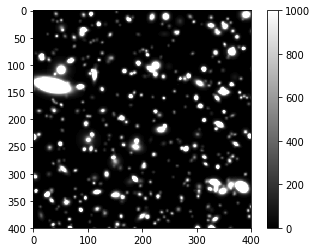

In [20]:
plt.imshow(results2.survey.image.array[:400,:400],cmap='gray',vmax=1000)
plt.colorbar() 

In [15]:
results2.table

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402713998325,402713998325,1,0,1,1485,1494,1101,1109,1.0,0.0,118.01,41.0785,1.49312,27.3272,0.0270901,8338.42,0.170408,0.170926,0.0545093,0.00793239,0.180068,0.161267,0.0722546,0.641572,1.0,2.5953,2.59373,2.59373,1.73355,1.73355,2.46419,2.3697,2.35414,2.46419,2.3697,2.35414,0.375875,0.0998559,0.0272174,0.0,0.0,4965.96,-9.6466,1.77807,0.312578,-0.000256699,0.0014196,4965.96,-9.6466,1.77807,0.312578,-0.000256699,0.0014196
402707721988,402707721988,1,0,1,1487,1499,1114,1124,1.0,0.0,118.724,43.9318,1.52474,26.491,0.157679,18011.2,0.227375,0.300043,0.515258,0.0702533,0.404631,0.127769,0.0677552,0.68312,1.0,5.2024,5.19658,5.19658,3.47909,3.47909,1.73786,1.68472,0.679883,1.73786,1.68472,0.679883,0.408604,0.808725,0.106025,0.0,0.0,2214.63,-4.31115,5.30345,0.737405,0.000303403,-0.000317205,2214.63,-4.31115,5.30345,0.737405,0.000303403,-0.000317205
402711568059,402711568059,2,0,1,1572,1583,1178,1189,1.0,0.0,135.561,56.759,1.35943,26.9096,0.159372,12249.1,0.408445,0.420103,0.0536835,0.15891,0.48381,0.344821,0.622505,0.745603,0.997935,2.90857,2.90704,2.90704,1.70712,1.70444,1.02297,0.836407,0.894429,1.02417,0.837386,0.895139,0.477991,0.0935164,0.294274,0.0,0.0,5919.72,-0.6551,0.124498,0.458807,-0.00148804,0.000449379,5681.47,-0.687369,0.0929589,0.440971,0.0042442,0.00226291
402715332898,402711568059,2,1,1,1564,1572,1176,1183,1.0,0.0,133.775,56.0689,1.18372,27.6657,0.313395,6104.67,0.136884,0.162928,0.366114,-0.195938,0.212953,0.0879879,-0.245698,0.639159,0.995379,1.94189,1.94098,1.94098,1.28699,1.2851,7.97603,7.13836,5.03618,7.98058,7.13876,5.04111,0.362504,0.492994,-0.259951,0.0,0.0,7677.21,-102.085,102.126,-55.9213,0.00105823,0.0093664,7649.75,-102.23,102.139,-56.0739,-0.000526806,0.00913028
402709443937,402709443937,2,0,1,1527,1536,1175,1185,1.0,0.0,126.416,56.0531,1.81231,26.5064,0.0082531,17757.9,0.0921603,0.0935434,0.098292,0.0723448,0.104187,0.081522,0.317247,0.625425,0.995684,5.92677,5.91801,5.918,4.25188,4.18417,2.74421,2.71641,2.66711,2.77383,2.75078,2.67361,0.357044,0.170337,0.120422,0.0,0.0,1748.59,-16.4277,5.64498,4.38975,0.000123997,7.98675e-05,1677.3,-16.7501,5.24782,4.39365,-0.00166869,0.000774664
402714392263,402709443937,2,1,1,1535,1543,1177,1186,0.285996,0.714004,127.866,56.4329,2.72096,27.433,-0.0594025,7563.86,0.478832,0.482066,0.0239691,0.0784625,0.519868,0.441034,0.637158,0.783346,0.94531,1.6223,1.62175,1.62174,0.473384,0.46753,5.94173,2.65721,3.81133,5.98589,2.69497,3.81856,0.411168,0.0215536,0.30172,0.0,0.0,21386.2,-2.3479,0.526555,7.59979,-0.00889357,-0.0063046,20819.8,-2.74421,0.138165,7.60304,-0.00180042,-0.00563614
402701771027,402701771027,1,0,1,1528,1546,1136,1153,0.986968,0.0130318,127.509,49.0633,0.937782,24.2447,0.553358,142586.0,0.301826,0.305637,0.040618,0.104386,0.337759,0.269715,0.599856,0.689475,1.0,38.4515,38.1589,38.1589,25.2541,25.2541,0.0872473,0.0786545,0.0810086,0.0872473,0.0786545,0.0810086,0.437791,0.0801742,0.205872,0.0,0.0,250.4,-0.00910635,0.000995787,0.0032377,6.44588e-08,8.14924e-08,250.4,-0.00910635,0.000995787,0.0032377,6.44588e-08,8.14924e-08
402701802864,402701802864,2,0,1,1472,1492,1149,1165,0.969897,0.0301032,116.513,51.4774,1.32089,24.0127,0.447716,176553.0,0.233635,0.376988,0.664437,0.0593765,0.522818,0.104

In [19]:
float(len(up_cut(detected(table_javier2),'purity',.98)))/len(up_cut(table_javier2,'purity',.98))

0.39750554323725057

In [21]:
len(np.unique(table_javier2['db_id']))

41126

In [ ]:
#plot the image like javier does 

In [31]:
import fitsio 
stamp = fitsio.FITS(image)[0].read()

In [33]:
stamp

array([[  311.5,   -53.5,  -793.5, ...,  -709.5,  -879.5, -1294.5],
       [ -306.5,    14.5,    46.5, ...,  -369.5,   347.5,   248.5],
       [  323.5,  -106.5,  -148.5, ...,  -198.5,    13.5,   152.5],
       ..., 
       [ -618.5,  -831.5,  -785.5, ...,  -314.5,  -221.5,  -527.5],
       [ -849.5,   309.5,   123.5, ...,   -77.5,   -17.5,    64.5],
       [   54.5,   390.5,   377.5, ...,  -128.5,    53.5,  -324.5]], dtype=float32)

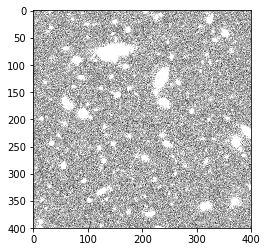

In [34]:
plt.imshow(stamp[:400,:400],cmap='gray',vmax=1000)

(array([  1.90000000e+01,   5.60000000e+01,   1.31000000e+02,
          2.50000000e+02,   5.25000000e+02,   1.07700000e+03,
          2.16800000e+03,   4.00100000e+03,   7.43100000e+03,
          1.32580000e+04,   2.28210000e+04,   3.81060000e+04,
          6.06120000e+04,   9.36190000e+04,   1.39534000e+05,
          2.02019000e+05,   2.81804000e+05,   3.77780000e+05,
          4.89616000e+05,   6.13640000e+05,   7.42699000e+05,
          8.67617000e+05,   9.80018000e+05,   1.06858000e+06,
          1.12875600e+06,   1.15023700e+06,   1.13426700e+06,
          1.08169800e+06,   1.00246100e+06,   8.98792000e+05,
          7.82653000e+05,   6.61269000e+05,   5.44925000e+05,
          4.35853000e+05,   3.43020000e+05,   2.65675000e+05,
          2.02632000e+05,   1.53969000e+05,   1.16280000e+05,
          8.91530000e+04,   6.96600000e+04,   5.63550000e+04,
          4.56790000e+04,   3.77530000e+04,   3.27590000e+04,
          2.83050000e+04,   2.51940000e+04,   2.24860000e+04,
        

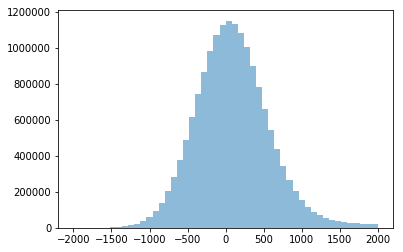

In [35]:
plt.hist(stamp.flatten(),range=(-2000,2000),bins=50,alpha=0.5)

In [90]:
float(len(not_ambig(detected(good(main_catsLSST[4])))))

127691.0

In [25]:
float(len(up_cut(up_cut(main_catsLSST[4],'snr_grpf',10),'sigma_m',.2)))/len(main_catsLSST[4])

0.1253111069781547

In [37]:
len(good(main_catsLSST[4]))

174343

In [81]:
float(len(detected(up_cut(main_catsLSST[4],'purity',.98))))/len(main_catsLSST[4])

0.17192769642829642

In [82]:
float(len(detected(up_cut(main_catsLSST[4],'purity',.98))))/len(up_cut(main_catsLSST[4],'purity',.98))

0.4021306955931452

In [94]:
float(len(not_ambig(not_detected(good(main_catsLSST[4])))))/len(good(main_catsLSST[4]))

0.050915703338095857

In [21]:
float(len(up_cut(up_cut(main_catsLSST[4],'purity',.98),'snr_grpf',6)))/len(main_catsLSST[4])

0.1582810428791596

## Read and filter out duplicated and bad objects.

In [18]:
#in the order that corresponds to the catalogues. 
g1s = [-.02,-.015,-.01,-.005,0.,.005,.01,.015,.02]

In [19]:
# main_catsLSST = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
# for key in ['final_fitsLSST1','final_fitsLSST2','final_fitsLSST3','final_fitsLSST4','final_fitsLSST5','final_fitsLSST6','final_fitsLSST7','final_fitsLSST8','final_fitsLSST9']:
#     results = fits.open(files[key])
#     main_catsLSST.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [20]:
# #this new LSST set of catalogues has g1 = .02 , g2 = 0.0 ; we will be using this one from now on. 
# main_catsLSST = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
# for key in ['final_fits2LSST1','final_fits2LSST2','final_fits2LSST3','final_fits2LSST4','final_fits2LSST5','final_fits2LSST6','final_fits2LSST7','final_fits2LSST8','final_fits2LSST9']:
#     results = fits.open(files[key])
#     main_catsLSST.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [21]:
#this new LSST set of catalogues has g1 = .02 , g2 = 0.0 ; we will be using this one from now on. 
main_catsLSST = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['Ffinal_fitsLSST1','Ffinal_fitsLSST2','Ffinal_fitsLSST3','Ffinal_fitsLSST4','Ffinal_fitsLSST5','Ffinal_fitsLSST6','Ffinal_fitsLSST7','Ffinal_fitsLSST8','Ffinal_fitsLSST9']:
    results = fits.open(files[key])
    main_catsLSST.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1)))) #assume not many objects are duplicated/bad.
    print('reading {}'.format(key))

reading Ffinal_fitsLSST1
reading Ffinal_fitsLSST2
reading Ffinal_fitsLSST3
reading Ffinal_fitsLSST4
reading Ffinal_fitsLSST5
reading Ffinal_fitsLSST6
reading Ffinal_fitsLSST7
reading Ffinal_fitsLSST8
reading Ffinal_fitsLSST9


In [21]:
float(len(up_cut(detected(main_catsLSST[4]),'purity',.98)))/len(up_cut(main_catsLSST[4],'purity',.98))

0.4021306955931452

In [22]:
float(len(down_cut(detected(main_catsLSST[4]),'purity',.98)))/len(down_cut(main_catsLSST[4],'purity',.98))

0.2259274740919776

In [ ]:
main_catsDES = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsDES1','final_fitsDES2','final_fitsDES3','final_fitsDES4','final_fitsDES5','final_fitsDES6','final_fitsDES7','final_fitsDES8','final_fitsDES9']:
    results = fits.open(files[key])
    main_catsDES.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [18]:
main_catsHSC = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsHSC1','final_fitsHSC2','final_fitsHSC3','final_fitsHSC4','final_fitsHSC5','final_fitsHSC6','final_fitsHSC7','final_fitsHSC8','final_fitsHSC9']:
    results = fits.open(files[key])
    main_catsHSC.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [19]:
#write down explicity the names for each input. 
names = ['One square degree galaxies with g1 = 0','One square degree galaxies with g1 = 0.1','One square degree galaxies with g1 = -0.1','One square degree galaxies with g1 = 0.2','One square degree galaxies with g1 = -0.2']

In [26]:
float(len(down_cut(detected(main_catsLSST[4]),'purity',.98)))/len(down_cut(main_catsLSST[4],'purity',.98))

0.16445800086084164

## Scatter plot showing the different detected/undetected and ambiguously blended pairs. 

In [52]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


def purity_snr_scatter_final(fraction,analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = up_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = down_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = up_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = down_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)
    
    #create smaller catalogues to plot them and reduce the density of points in each region. 
    small_hphs = small(high_pur_high_snr,int(len(high_pur_high_snr)* fraction))
    small_hpls = small(high_pur_low_snr,int(len(high_pur_low_snr)* fraction))
    small_lphs = small(low_pur_high_snr,int(len(low_pur_high_snr) * fraction))
    small_lpls = small(low_pur_low_snr,int(len(low_pur_low_snr)* fraction))

    x_new_ticks = [6,12,18,24,30]
    tex_x_new_ticks = [r'$6$',r'$12$',r'$18$',r'$24$',r'$30$']

    y_orig_ticks = np.array([0.,0.142,0.5402,.785,1])
    y_new_ticks = []
    for label in y_orig_ticks: 
        y_new_ticks.append(r'${:.2g}$'.format(label**(1./12)))
    
    #plot each group separately with different colors 
    #replace original ticks with of new ones. Do that for all. 
    plt.scatter(small_hphs['snr_grpf'],small_hphs['purity']**(power),alpha=.2,color=colors[0])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_hpls['snr_grpf'],small_hpls['purity']**(power),alpha=.2,color=colors[1])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    plt.scatter(small_lphs['snr_grpf'],small_lphs['purity']**(power),alpha=.2,color=colors[2])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_lpls['snr_grpf'],small_lpls['purity']**(power),alpha=.2,color=colors[3])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    #annotate with colors the percentages
    plt.annotate("{0:.1f}\%".format(p1*100), xy=(0.540, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p2*100), xy=(0.040, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p3*100), xy=(0.540, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p4*100), xy=(0.040, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.text(.380,.01,r'Fraction of full catalogue:${0:.1f}$\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)
    
    

    plt.xlabel(r'$\nu_{\rm grpf}$',fontsize=40)
    plt.ylabel(r'$\rho$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    #plt.title(name)



 

In [53]:
scatter_cat = main_catsLSST[4]

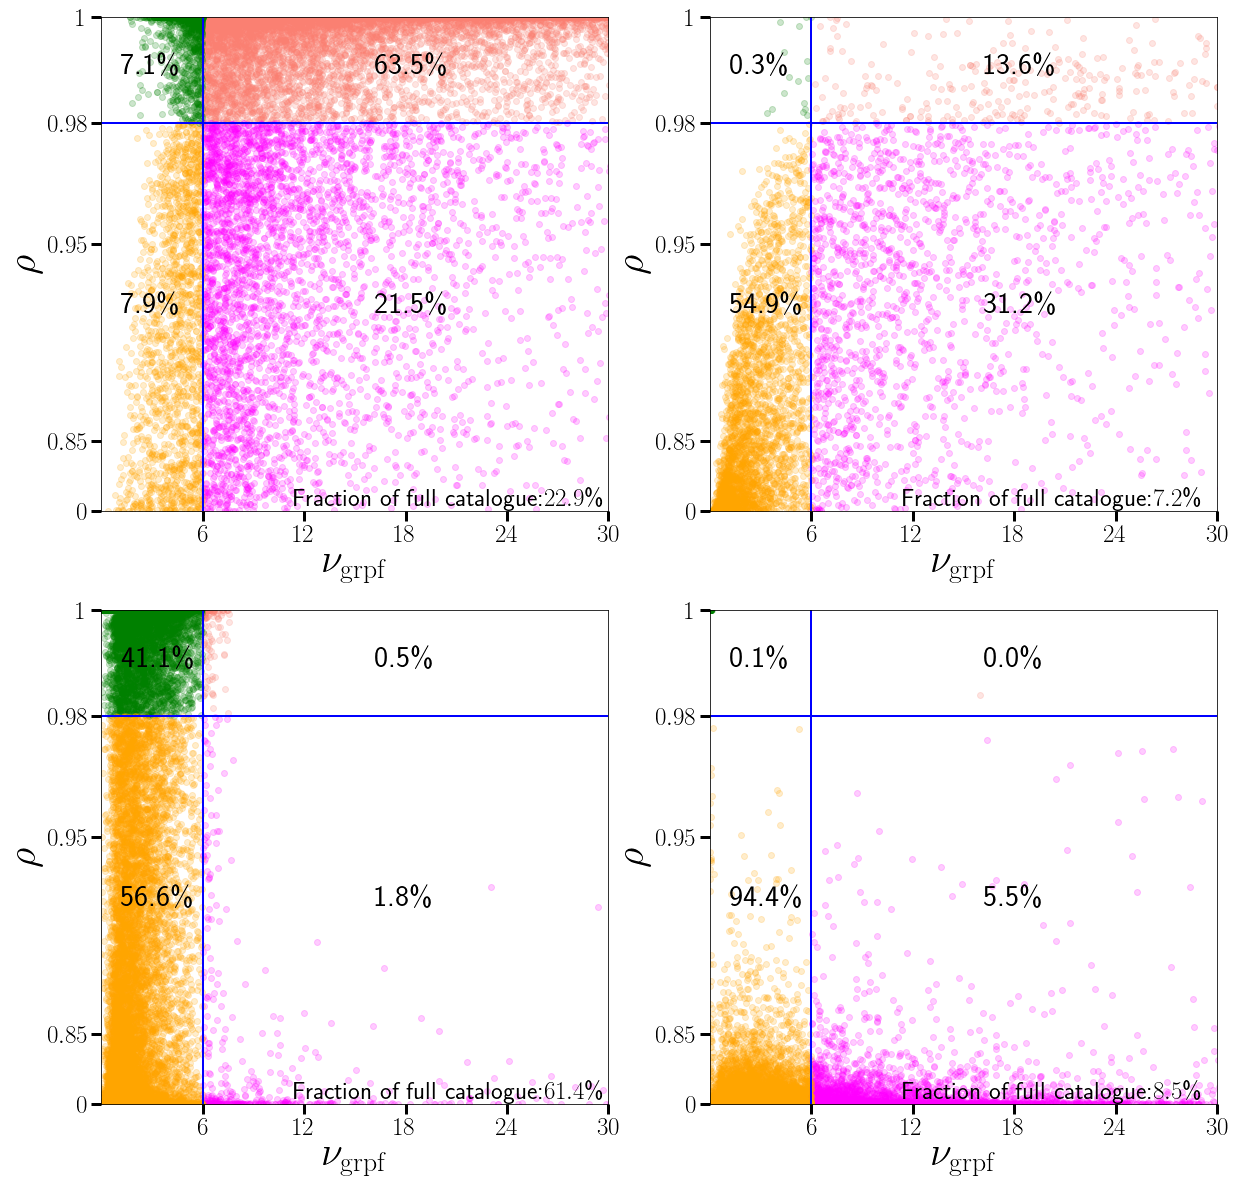

In [54]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 

cats =[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['salmon', 'green', 'magenta', 'orange','black']
fractions = [1/10.,1./10, 1./20, 1.] #exclusively for plotting purposes

for i,(name,temp_cat,fraction) in enumerate(zip(names,cats,fractions)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='blue',linewidth=2)
    plt.axvline(6,color='blue',linewidth=2)
    purity_snr_scatter_final(fraction, temp_cat,colors,power,scatter_cat,ax,name)
    #as reference for debugging, 

plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_cat.jpg')

In [48]:
lensing_sample = good(main_catsLSST[4])
print 'number of galaxies in lensing sample that are detected: {}'.format(float(len(detected(lensing_sample)))/len(lensing_sample))


number of galaxies in lensing sample that are detected: 0.928347837381


# Functions for money plot 

In [79]:
#use boostrap to calculate error on the func (median, mean, etc.) 
def errs_param_boot(cats, param, func,N=10000):
    stds = []
    for cat in cats: 
        true_func = func(cat[param])
    
        #generate random N sample with replacement of func
        funcs = bootstrap_param_cat(cat, param, N, func)
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print('just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(funcs,[16,84]) - true_func)))
        stds.append(np.absolute(np.percentile(funcs,84) - true_func))
    return stds

In [36]:
#use boostrap to calculate error on the median. 
def errs_mean_boot(cats,param):
    stds = []
    for cat in cats: 
        true_mean = np.mean(cat[param])
        n = len(cat)
    
        #generate random N sample with replacement 
        N = 10000
        means = bootstrap_param_cat(cat, param, N, np.mean)
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print('just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(means,[16,84]) - true_mean)))
        stds.append(np.absolute(np.percentile(means,84) - true_mean))
    return stds


def errs_med_boot(cats,param):
    stds = []
    for cat in cats: 
        n = len(cat)
        true_median = np.median(cat[param])
        N = 10000

        median = bootstrap_param_cat(cat, param, N, np.mean)
        #generate random N sample of medians with replacement 
        meds = []
        for i in range(N):
            sample = np.random.choice(cat[param],size=n)
            meds.append(np.median(sample))
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print('just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(meds,[16,84]) - true_median)))
        stds.append(np.absolute(np.percentile(meds,84) - true_median))
    return stds
    

In [37]:
#calculate error on the slope for a linear function that goes through the origin with bootstrap. 

############################################################### WILL NOT BE USED. 
def err_slope_boot(cats,param,filters): 
    meds = [] #each of this is a tuple of 9 medians to fit
    
    filter_cats = get_filter_cats(main_cats,filters)        
    intersect_cats = get_intersection_cats(filter_cats)
      
    #generate random N samples of the slope. 
    N = 10000
    slopes = []

In [38]:
#chi-squared function to calculate linear regression coefficients using covariance matrix. 
def get_mixcov(corr,errs):
    #we obtain a new covariance matrix: 
    mixcov = np.zeros(corr.shape) 
    for i in range(corr.shape[0]): 
        for j in range(corr.shape[1]): 
            mixcov[i,j] = corr[i,j] * errs[i] * errs[j]
            mixcov[j,i] = mixcov[i,j]
        
    return mixcov

def chisqfunc(b0,b1,cov, med_shear_bias,app_shear,inv=None): 
    #errs is a vector of errors on the median shear biases calculated using bootstrap 
    #corr is the correlation matrix calculated between the common elements of the 9 samples. 
    invcov = np.linalg.inv(cov)
    
    if inv: 
        invcov = inv 
    
    #now we used the mixed covariance matrix to calculate the chi-squared: 
    model = b1 + b0*app_shear
    chi2 = np.dot((med_shear_bias - model), np.dot(invcov, med_shear_bias - model))
    
    return chi2

#chi-squared function to calculate linear regression coefficients using covariance matrix. 
def chisq_cov(cov,app_shear,inv=None):
    invcov = np.linalg.inv(cov)
    
    if inv: 
        invcov = inv 
    
    #get H matrix, 
    H = np.zeros((len(app_shear), 2)) # 2 refers to b0,b1
    for i in range(len(app_shear)): 
        for j in range(2):
            if j == 0: 
                H[i,j] = app_shear[i]
            else: 
                H[i,j] = 1. 
    
    return np.linalg.inv(np.dot(H.T,np.dot(invcov,H)))

In [39]:
def f(B, x):
    '''Linear function y = m*x that passes thorugh origin.'''
    # B is the slope of the line that passes through the origin.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def linear_fit(g1s,medians,fit_args): 
    import scipy.odr
    linear = scipy.odr.Model(f)
    mydata = scipy.odr.RealData(g1s, medians, sy=fit_args['errs'])
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1.,2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    
    print
    print(fit_args['iso_or_grp'] + ':')
    print
    print('value b0:     {:.3e}'.format(beta0))
    print('error b0:     {:.3e}'.format(np.sqrt(myoutput.cov_beta[0,0])))
    print('std error b0: {:.3e}'.format(np.sqrt(myoutput.sd_beta[0])))

    print('value b1:     {:.3e}'.format(beta1))
    print('error b1:     {:.3e}'.format(np.sqrt(myoutput.cov_beta[1,1])))
    print('std error b1: {:.3e}'.format(np.sqrt(myoutput.sd_beta[1])))
    print 
    
    return beta0, beta1 
    
def chi_sq_fit(g1s,medians,fit_args): 
    x0=np.array([0,0])
    print(g1s)
    iso_or_grp = fit_args['iso_or_grp']
    cov = fit_args['cov_{}'.format(iso_or_grp)]
    inv = fit_args['inv_{}'.format(iso_or_grp)]
    result =  opt.minimize(chisqfunc,x0,args=(cov,medians,np.array(g1s), inv))
    print(result)
    #assert result.success==True
    b0,b1 = result.x
    print()
    print()
    #get covariance matrix of estimated parameters. 
    param_cov = chisq_cov(cov,np.array(g1s),inv)
    
    print()
    print(iso_or_grp + ' :')
    
    print()
    print('value b0:     {:.3e}'.format(b0))
    print('error b0:     {:.3e}'.format(np.sqrt(param_cov[0,0])))
    print('value b1:     {:.3e}'.format(b1) )
    print('error b1:     {:.3e}'.format(np.sqrt(param_cov[1,1])))
    print('error correlation coefficient: {:.3e}'.format(param_cov[0,1]/np.sqrt(param_cov[0,0]*param_cov[1,1])))
    print()
    
#     print
#     print 'chisq cov:', param_cov
    
    return b0,b1
    

In [40]:
def get_money_plot(g1s,gi,errs_grp,errs_iso,main_cats,fit_procedure,fit_args,ticks1=None,ticks2=None,ticks3=None,labely1=None):
    plt.rc('text', usetex=True)

    figure1 = plt.figure(figsize=(20, 20))
    figure2 = plt.figure(figsize=(10, 10))

    ####################BLENDED        
    means = [np.mean(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    medians = [np.median(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    sigmas = [mad(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    
    # use the method describe in the page above for std of the median 
    errs = errs_grp
    fit_args['errs'] = errs_grp

    ax1 = figure1.add_subplot(111)
    ax2 = figure2.add_subplot(111)

    print('means grp:', means)
    print('medians grp:',medians)
    print('sigmas grp:',sigmas)
    print('errs grp:',errs)
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',capsize=3,label="\\rm Blending on" )
    
    fit_args['iso_or_grp'] = 'grp'
    beta0, beta1 = fit_procedure(g1s,medians,fit_args)
    
    
    #plot line, 
    x= g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='b')


    ####second plot 
    plt.figure()
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))


    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='blue',capsize=3)
    
    print 
    print('###################################')

    ################UNBLENDED 

    means = [np.mean(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    medians = [np.median(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    sigmas = [mad(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    # use the method describe in the page above for std of the median 
    errs = errs_iso
    fit_args['errs'] = errs_iso


    print('means iso:',  means)
    print('medians iso:',medians)
    print('sigmas iso:',sigmas )
    print('errs iso:',errs)
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3, label = "\\rm Blending off")

    fit_args['iso_or_grp'] = 'iso'
    beta0, beta1 = fit_procedure(g1s,medians, fit_args)

    #plot line, 
    x = g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='r')


    ####second plot 
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))

    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='red',capsize=3)

    ################################################################################################
    #formatting 
    
    #plt.ylim(-10,10)
    ax1.set_xlim([-.025,.025])


    ax1.tick_params(axis='both', which='major', labelsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)


    # ax1.yticks(size=20)
    num = gi[1:]

    ax1.set_xlabel(r'$g_{}$'.format(num),size=40)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    
    if labely1 != None: 
        ax1.get_yaxis().get_offset_text().set_size(1)
        ax1.set_ylabel(r'\rm {}'.format(labely1),size=40)
    else: 
        ax1.get_yaxis().get_offset_text().set_size(20)



    ax2.set_xlabel(r'${}$'.format(gi),size=40)


    ax1.axhline(0,c='g')
    ax2.axhline(0,c='g')

    ax1.tick_params(axis='both', size=10,width=3,which='both')
    ax2.tick_params(axis='both', size=10,width=3,which='both')


    if ticks1 != None: 
        ax1.set_yticklabels(ticks1)
    
    
    if ticks2 != None: 
        ax2.set_yticklabels(ticks2)
        
    if ticks3 != None: 
        ax2.set_xticklabels(ticks3)
        
    ax.legend(loc='best', prop={'size':25})


## LSST 

### good galaxies 

In [37]:
filters = [good,best]

#### g1 

In [69]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
filter_cats = get_filter_cats(main_catsLSST, filters) 
errs_LSSTgood_g1grp = errs_param_boot(filter_cats, 'bias_g1_grp', np.median)
errs_LSSTgood_g1iso = errs_param_boot(filter_cats,'bias_g1', np.median) 

just to check that symmetry is respected print both percentiles: [  4.79333903e-06   5.24842835e-06]
just to check that symmetry is respected print both percentiles: [  4.83861615e-06   5.11657345e-06]
just to check that symmetry is respected print both percentiles: [  3.92857510e-06   3.90757850e-06]
just to check that symmetry is respected print both percentiles: [  4.23357505e-06   3.84715986e-06]
just to check that symmetry is respected print both percentiles: [  3.08344545e-06   2.62147205e-06]
just to check that symmetry is respected print both percentiles: [  3.15132456e-06   3.17865679e-06]
just to check that symmetry is respected print both percentiles: [  3.94003837e-06   3.90226887e-06]
just to check that symmetry is respected print both percentiles: [  4.48919673e-06   4.55636837e-06]
just to check that symmetry is respected print both percentiles: [  5.78226172e-06   4.82014002e-06]
just to check that symmetry is respected print both percentiles: [  2.08519305e-06   1.9058

In [70]:
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

linear fit 

means grp: [1.5145439, 0.13798019, -1.8140323, -1.1292536, -0.02054221, -0.015915656, 0.3697789, -0.015698154, 0.0035246527]
medians grp: [-5.4422708e-05, -3.9863149e-05, -2.6170201e-05, -1.3072816e-05, -1.198442e-06, 7.5850708e-06, 1.9745705e-05, 3.4588884e-05, 5.3075644e-05]
sigmas grp: [0.0049318839, 0.0048842202, 0.0048985714, 0.004852457, 0.0048913299, 0.0048699826, 0.0048894584, 0.0048642526, 0.0048834141]
errs grp: [5.2484283514786512e-06, 5.1165734475944191e-06, 3.9075785025488585e-06, 3.8471598600153811e-06, 2.6214720492134802e-06, 3.1786567888047991e-06, 3.9022688724799082e-06, 4.5563683670479804e-06, 4.8201400204561651e-06]

value b0:     2.566e-03
error b0:     6.642e-02
std error b0: 8.351e-03
value b1:     -2.192e-06
error b1:     8.553e-04
std error b1: 9.476e-04


###################################
means iso: [-0.0028434887, -0.002488645, -0.0016060944, -0.0013810674, -0.00091969536, 0.00042504145, 0.00053271587, 0.0012254076, 0.0021171072]
medians iso: [-

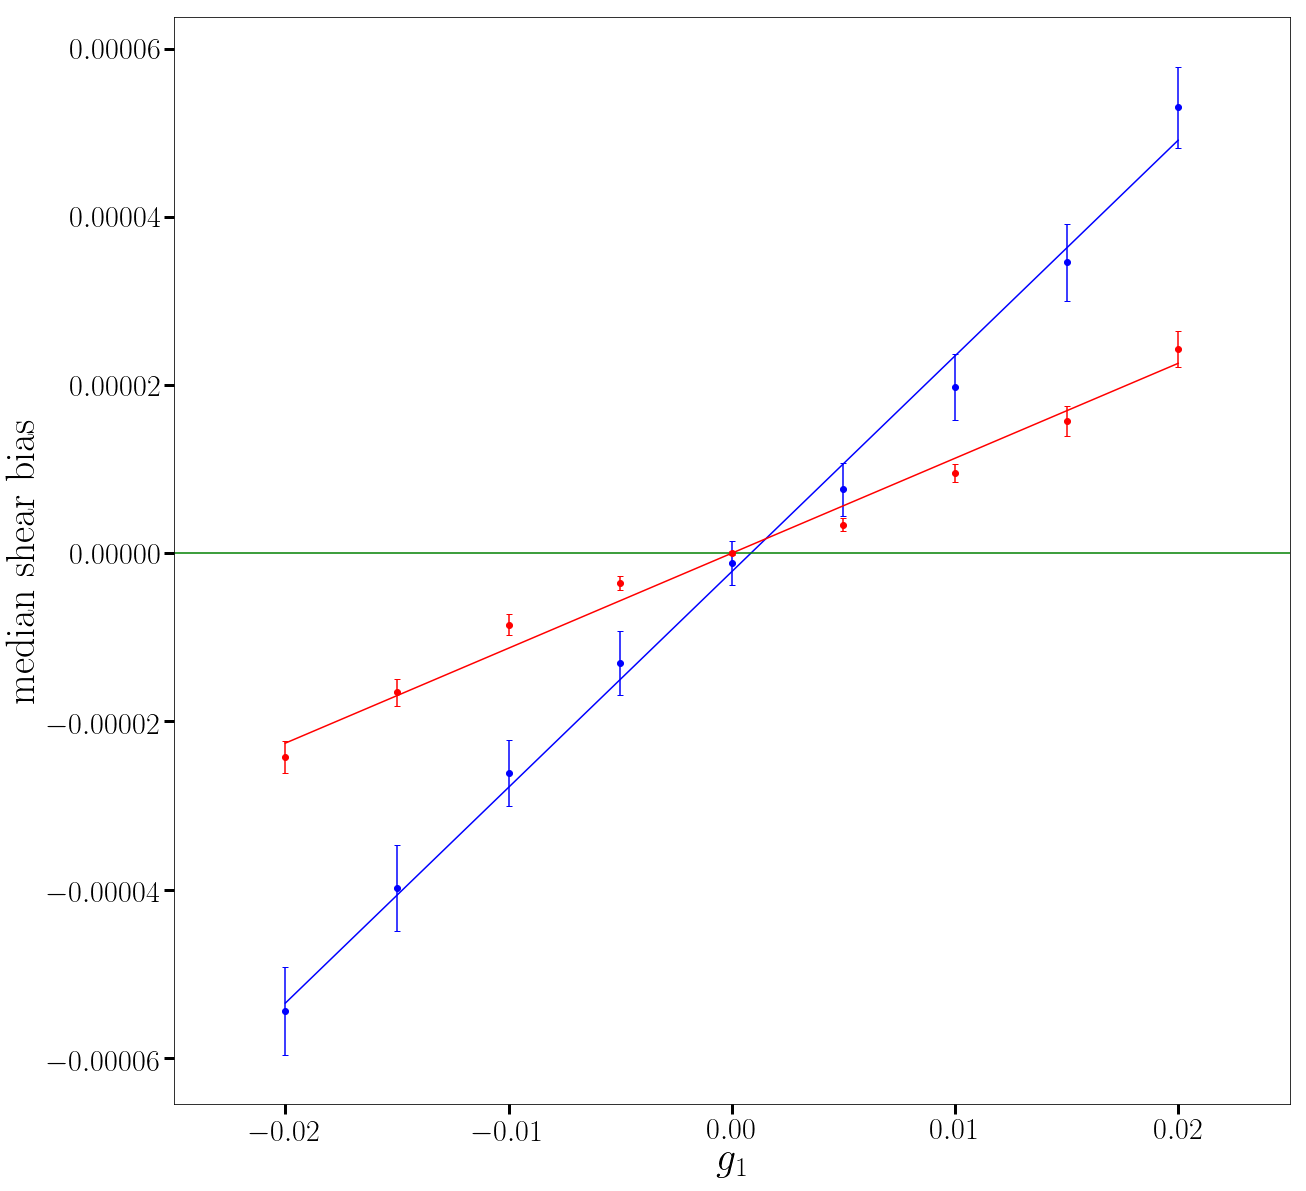

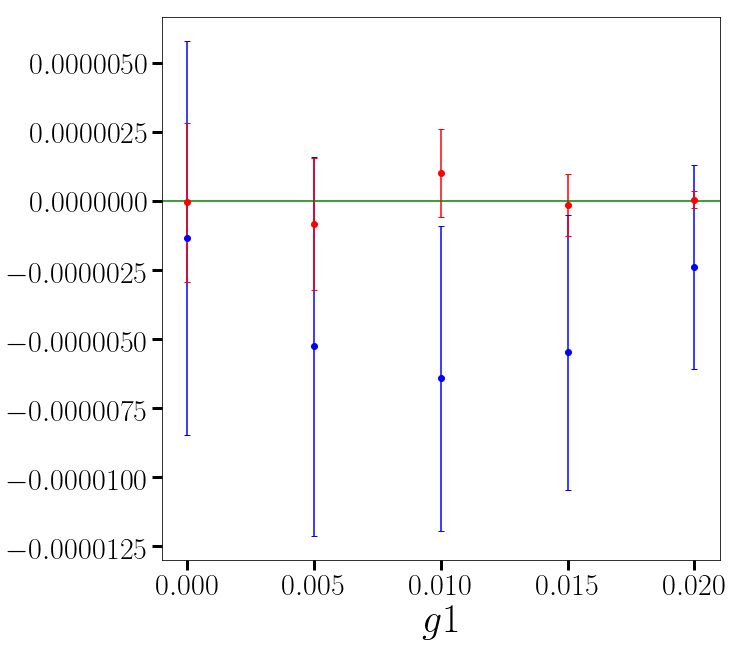

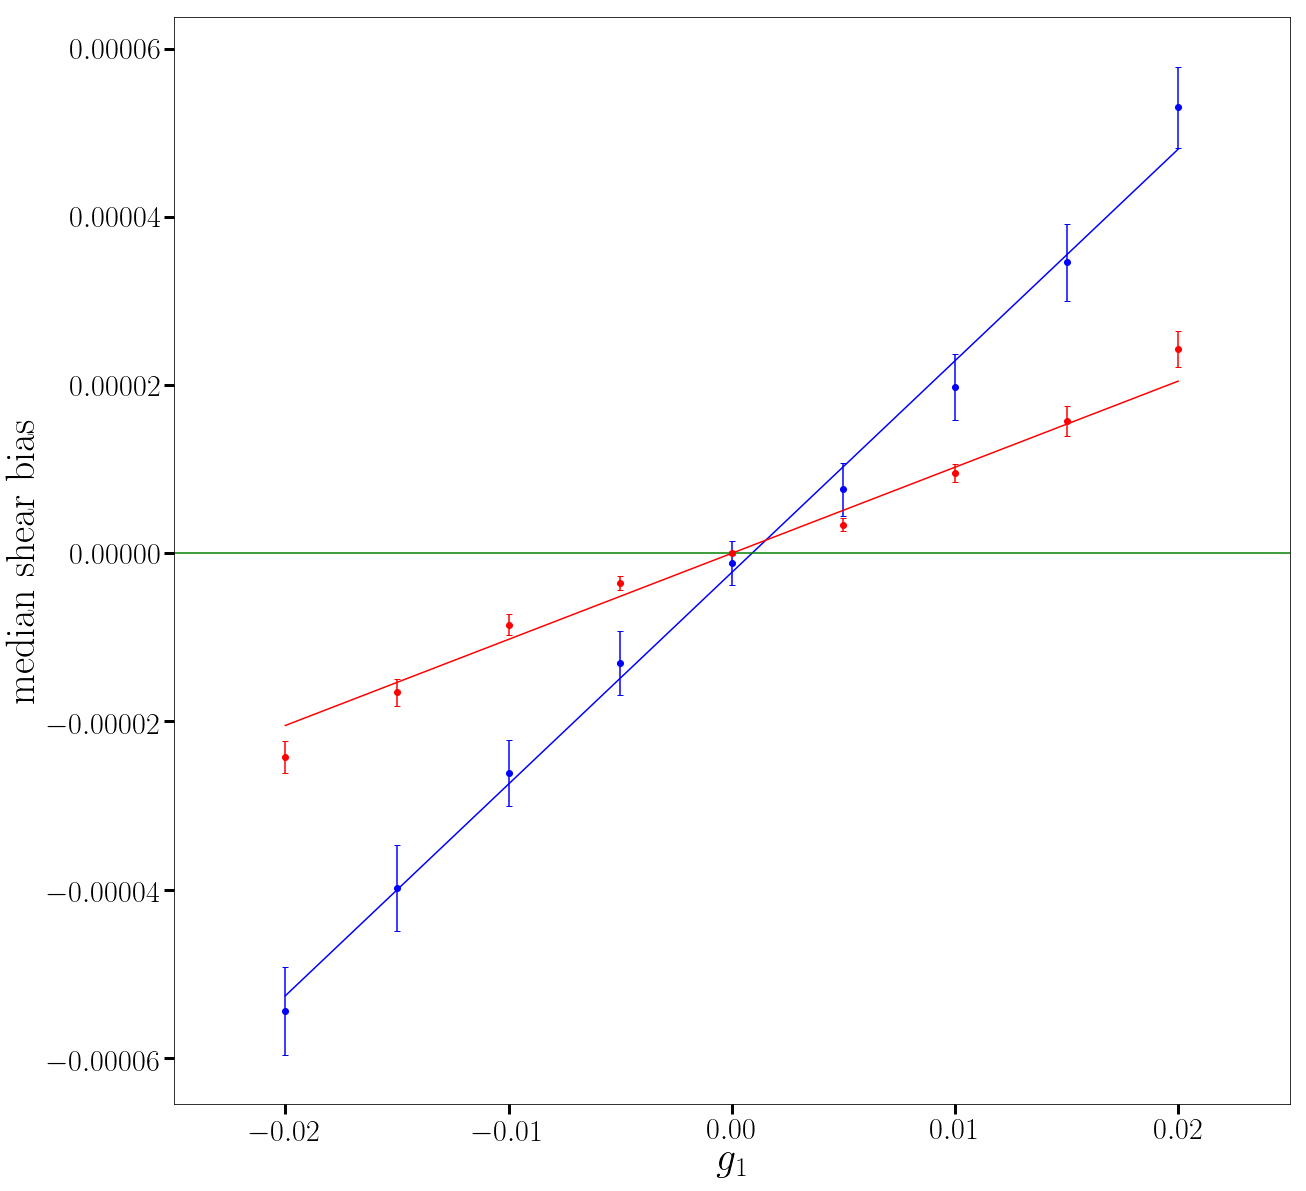

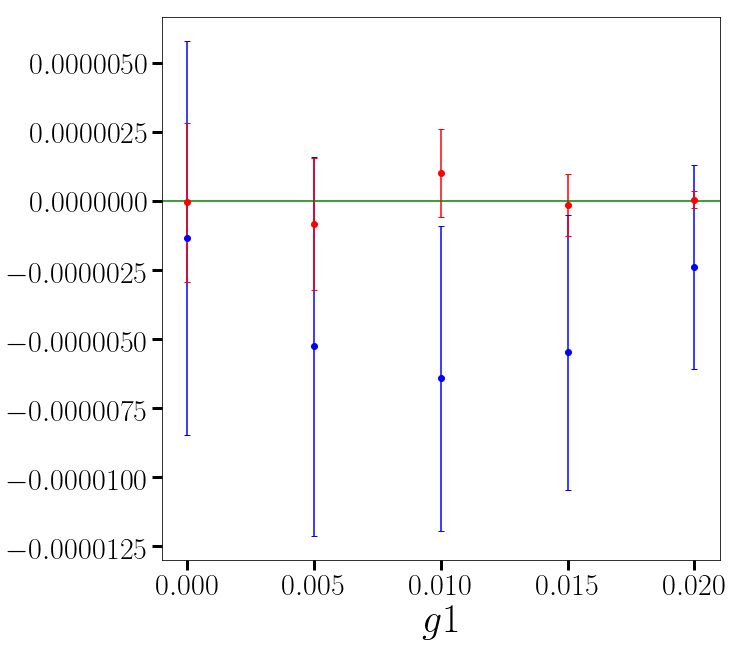

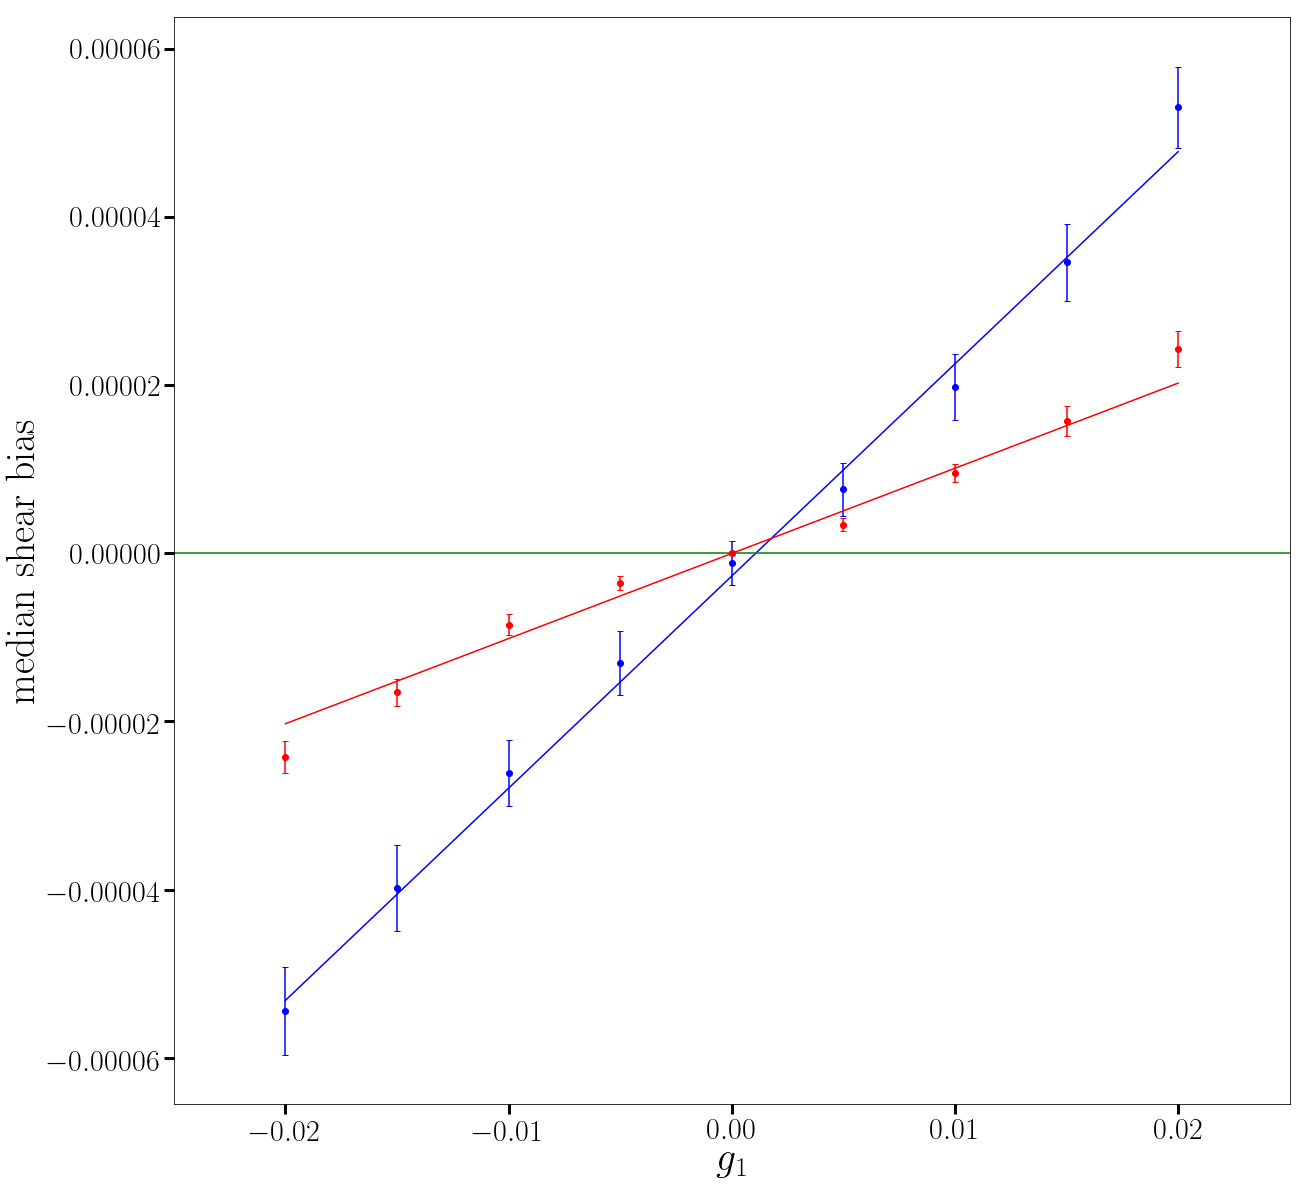

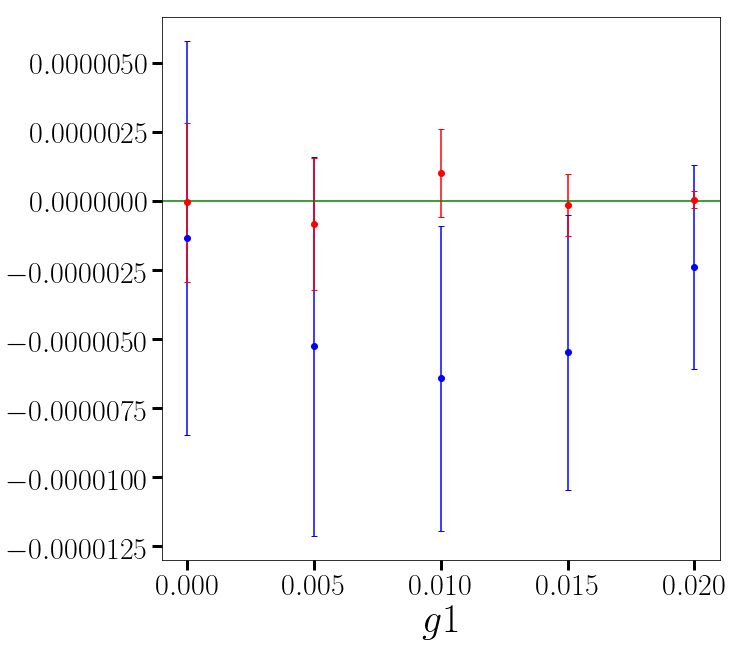

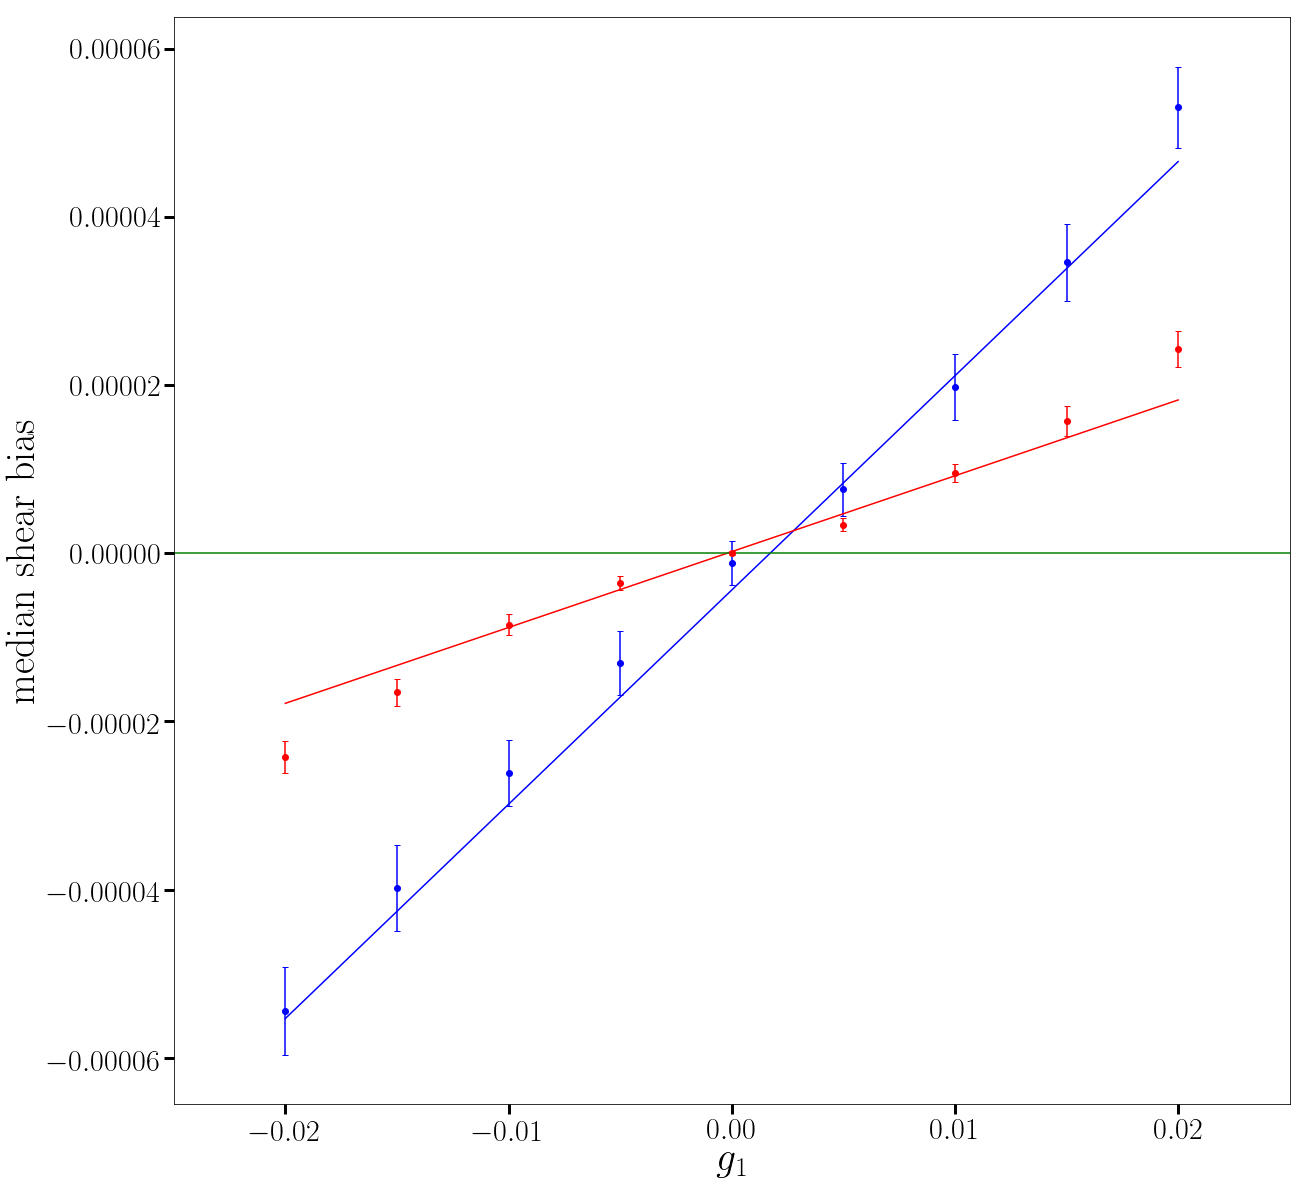

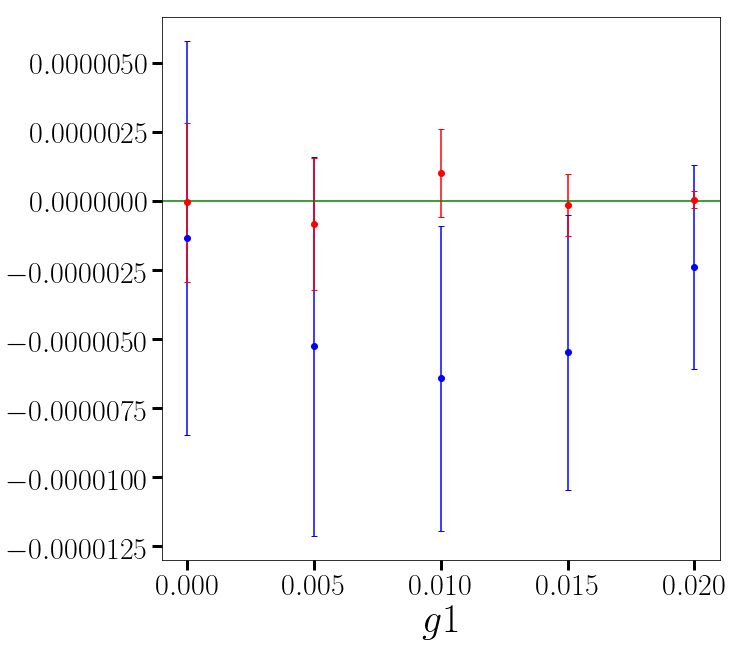

In [74]:
print 'linear fit '
print 
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')
print 
print '###################################################################################'
print 'independent covariance matrix'
print 

# inv_iso = np.diag(np.diag(np.linalg.inv(covariance_matrix)))
# inv_grp = np.diag(np.diag(np.linalg.inv(covariance_matrix_grp)))

#get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp':np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')


# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')


print 
print '###################################################################################'
print 'mixed covariance matrix '
print 


get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None})



### selection sample with 0 shear

In [31]:
filters = [good,best]

In [34]:
selection_samples = selection_filter(main_catsLSST, filters)

In [35]:
#this one filters the cats based only on the shear = 0 one. and then uses the same galaxy across 9 catalogues. 
errs_LSSTgood_g1grp = errs_param_boot(selection_samples,'bias_g1_grp', np.median) 
errs_LSSTgood_g1iso = errs_param_boot(selection_samples,'bias_g1', np.median) 
# covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
# mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

just to check that symmetry is respected print both percentiles: [  6.57735654e-06   6.68354187e-06]
just to check that symmetry is respected print both percentiles: [  5.69197800e-06   4.57475835e-06]
just to check that symmetry is respected print both percentiles: [  4.27970735e-06   5.01611248e-06]
just to check that symmetry is respected print both percentiles: [  4.14849819e-06   3.89913657e-06]
just to check that symmetry is respected print both percentiles: [  3.29991622e-06   2.83476811e-06]
just to check that symmetry is respected print both percentiles: [  3.71235546e-06   3.52089137e-06]
just to check that symmetry is respected print both percentiles: [  4.55471672e-06   4.43302270e-06]
just to check that symmetry is respected print both percentiles: [  6.55870099e-06   6.35547462e-06]
just to check that symmetry is respected print both percentiles: [  6.61646482e-06   7.42163684e-06]
just to check that symmetry is respected print both percentiles: [  2.68992881e-06   2.6586

In [ ]:

# # #calculate the covariance matrix of bootstrapped means for this selection filter, also pickle it because it takes a while. 

# boot_covariance_matrix, boot_covariance_matrix_grp, boot_correlation_matrix, boot_correlation_matrix_grp = get_boostrap_covariance_matrix(selection_samples,'g1')

# pickle.dump((boot_covariance_matrix, boot_covariance_matrix_grp, boot_correlation_matrix, boot_correlation_matrix_grp),open("bootstrap_matrices4.p","wb"))



In [38]:
boot_covariance_matrix, boot_covariance_matrix_grp, boot_correlation_matrix, boot_correlation_matrix_grp = pickle.load( open( "bootstrap_matrices2.p", "rb" ), 
                                                                                                                       encoding='latin1')

In [63]:
#compare std deviations from covariance matrix with the boostrapped ones: 
for i,g1 in enumerate(g1s): 
    print 'for shear g1 = {}, g2 = 0 we have:'.format(g1)
    print 'error on bias_g1_iso boostraped from distribution is       {:.3g}'.format(errs_LSSTgood_g1iso[i])
    print 'sqrt of iso boostraped covariance matrix is                {:.3g}'.format(np.sqrt(boot_covariance_matrix[i,i]))
    print 'error on bias_g1_grp boostraped from distribution is       {:.3g}'.format(errs_LSSTgood_g1grp[i])
    print 'sqrt of grp boostraped covariance matrix is                {:.3g}'.format(np.sqrt(boot_covariance_matrix_grp[i,i]))
    print 



for shear g1 = -0.02, g2 = 0 we have:
error on bias_g1_iso boostraped from distribution is       3.31e-06
sqrt of iso boostraped covariance matrix is                3.42e-06
error on bias_g1_grp boostraped from distribution is       6.29e-06
sqrt of grp boostraped covariance matrix is                6.83e-06

for shear g1 = -0.015, g2 = 0 we have:
error on bias_g1_iso boostraped from distribution is       2.54e-06
sqrt of iso boostraped covariance matrix is                2.54e-06
error on bias_g1_grp boostraped from distribution is       5.93e-06
sqrt of grp boostraped covariance matrix is                6.2e-06

for shear g1 = -0.01, g2 = 0 we have:
error on bias_g1_iso boostraped from distribution is       1.79e-06
sqrt of iso boostraped covariance matrix is                1.91e-06
error on bias_g1_grp boostraped from distribution is       4.8e-06
sqrt of grp boostraped covariance matrix is                5.38e-06

for shear g1 = -0.005, g2 = 0 we have:
error on bias_g1_iso boostrap

In [44]:
boot_covariance_matrix_grp.shape

(9, 9)

means grp: [-0.017135598, -0.017128225, -0.012059592, -0.01459181, -0.0080536017, -0.0074088555, 0.0037239236, -6.6826549e-05, 0.0031481853]
medians grp: [-7.5290358e-05, -5.1784547e-05, -3.3519391e-05, -1.674373e-05, -9.6768849e-07, 1.3524727e-05, 3.1477965e-05, 5.3595504e-05, 7.7079065e-05]
sigmas grp: [0.0063301902, 0.006301316, 0.0062814015, 0.0062747565, 0.006269617, 0.0062633646, 0.006276452, 0.0062992834, 0.0063282135]
errs grp: [6.6835418692789972e-06, 4.574758349917829e-06, 5.016112481825985e-06, 3.8991365727270022e-06, 2.83476811091532e-06, 3.5208913686801679e-06, 4.4330226955935359e-06, 6.3554746157024007e-06, 7.4216368375346065e-06]
[-0.02, -0.015, -0.01, -0.005, 0.0, 0.005, 0.01, 0.015, 0.02]


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

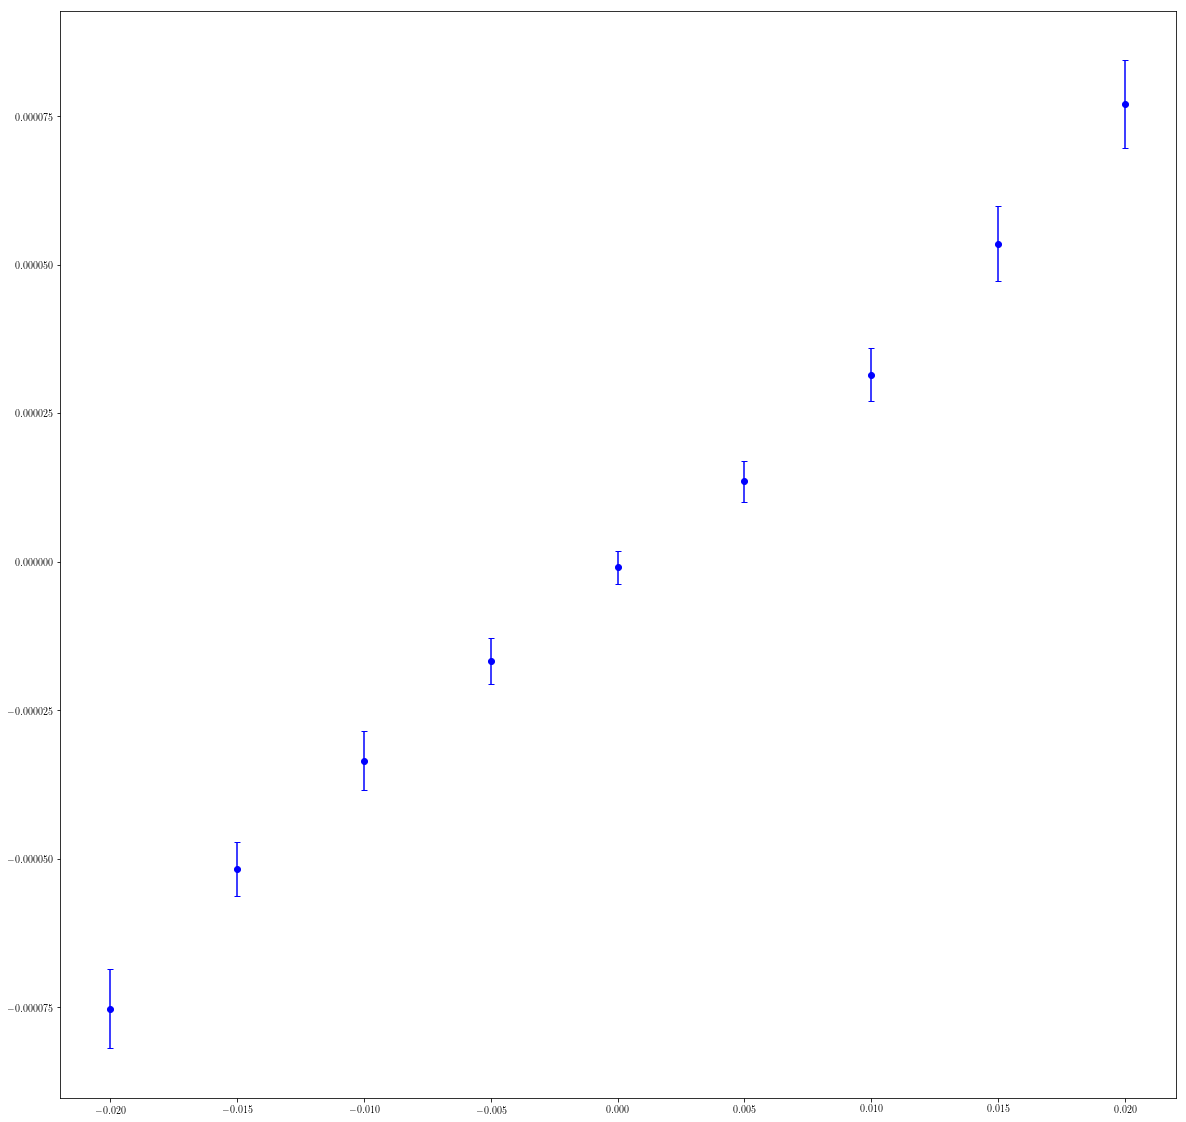

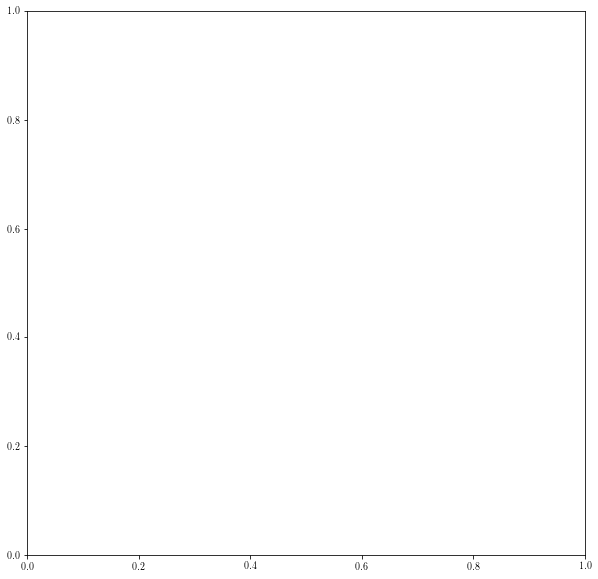

In [41]:
# print 'linear fit'
# print 
# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')

# print 
# print '###################################################################################'

# print 'independent chi sq '
# print 

# #get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp))},labely1='median shear bias')
# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp': np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')



# print 
# print '###################################################################################'

# print 'mixed chi sq '
# print

# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')

# print 
# print '###################################################################################'
# print 'median bootstrap covariance matrix'
# print
#'
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,selection_samples,chi_sq_fit,{'cov_iso':boot_covariance_matrix, 'cov_grp':boot_covariance_matrix_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias $[10^{-4}]$')
# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,selection_samples,chi_sq_fit,{'cov_iso':boot_covariance_matrix, 'cov_grp':boot_covariance_matrix_grp,'inv_iso':None,'inv_grp':None})




In [80]:
# the last option is to completely use the 85% galaxies that stay after intersection. 
#this one filters the cats based only on the shear = 0 one. and then uses the same galaxy across 9 catalogues. 
filter_cats = get_intersection_cats(get_filter_cats(main_catsLSST,filters))
errs_LSSTgood_g1grp = errs_med_boot(filter_cats,'bias_g1_grp') 
errs_LSSTgood_g1iso = errs_med_boot(filter_cats,'bias_g1') 
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

just to check that symmetry is respected print both percentiles: [  4.69566294e-06   4.91798710e-06]
just to check that symmetry is respected print both percentiles: [  4.15767739e-06   3.39517464e-06]
just to check that symmetry is respected print both percentiles: [  3.74007082e-06   3.46902925e-06]
just to check that symmetry is respected print both percentiles: [  4.04194179e-06   3.62911163e-06]
just to check that symmetry is respected print both percentiles: [  2.68503231e-06   2.80919941e-06]
just to check that symmetry is respected print both percentiles: [  2.55084024e-06   2.87356897e-06]
just to check that symmetry is respected print both percentiles: [  2.73808109e-06   2.97329592e-06]
just to check that symmetry is respected print both percentiles: [  3.77636541e-06   3.86419197e-06]
just to check that symmetry is respected print both percentiles: [  4.47867933e-06   4.18718264e-06]
just to check that symmetry is respected print both percentiles: [  1.55099857e-06   1.9263

linear fit

means grp: [-0.019624801, 0.010422705, -0.009438769, 0.016076708, -0.024706786, -0.01816, -0.0087735169, -0.018515399, 0.0062621487]
medians grp: [-4.390689e-05, -3.0467365e-05, -2.0881333e-05, -1.1358727e-05, -2.8515503e-06, 4.8045526e-06, 1.3521347e-05, 2.4394334e-05, 3.5833262e-05]
sigmas grp: [0.0034618084, 0.0034645433, 0.0034547779, 0.0034460481, 0.0034437273, 0.0034446106, 0.0034456556, 0.0034546473, 0.003471707]
errs grp: [4.9179870984517038e-06, 3.3951746445382014e-06, 3.4690292523009703e-06, 3.6291116339270918e-06, 2.8091994147416692e-06, 2.8735689738823567e-06, 2.9732959228567757e-06, 3.8641919672954828e-06, 4.1871826397255063e-06]

value b0:     1.903e-03
error b0:     4.922e-02
std error b0: 6.724e-03
value b1:     -3.435e-06
error b1:     6.342e-04
std error b1: 7.632e-04


###################################
means iso: [-0.0018960793, -0.0014509897, -0.0010071399, -0.00056510477, -0.00012216262, 0.00032115789, 0.0007647507, 0.0012082338, 0.0016523468]
medians

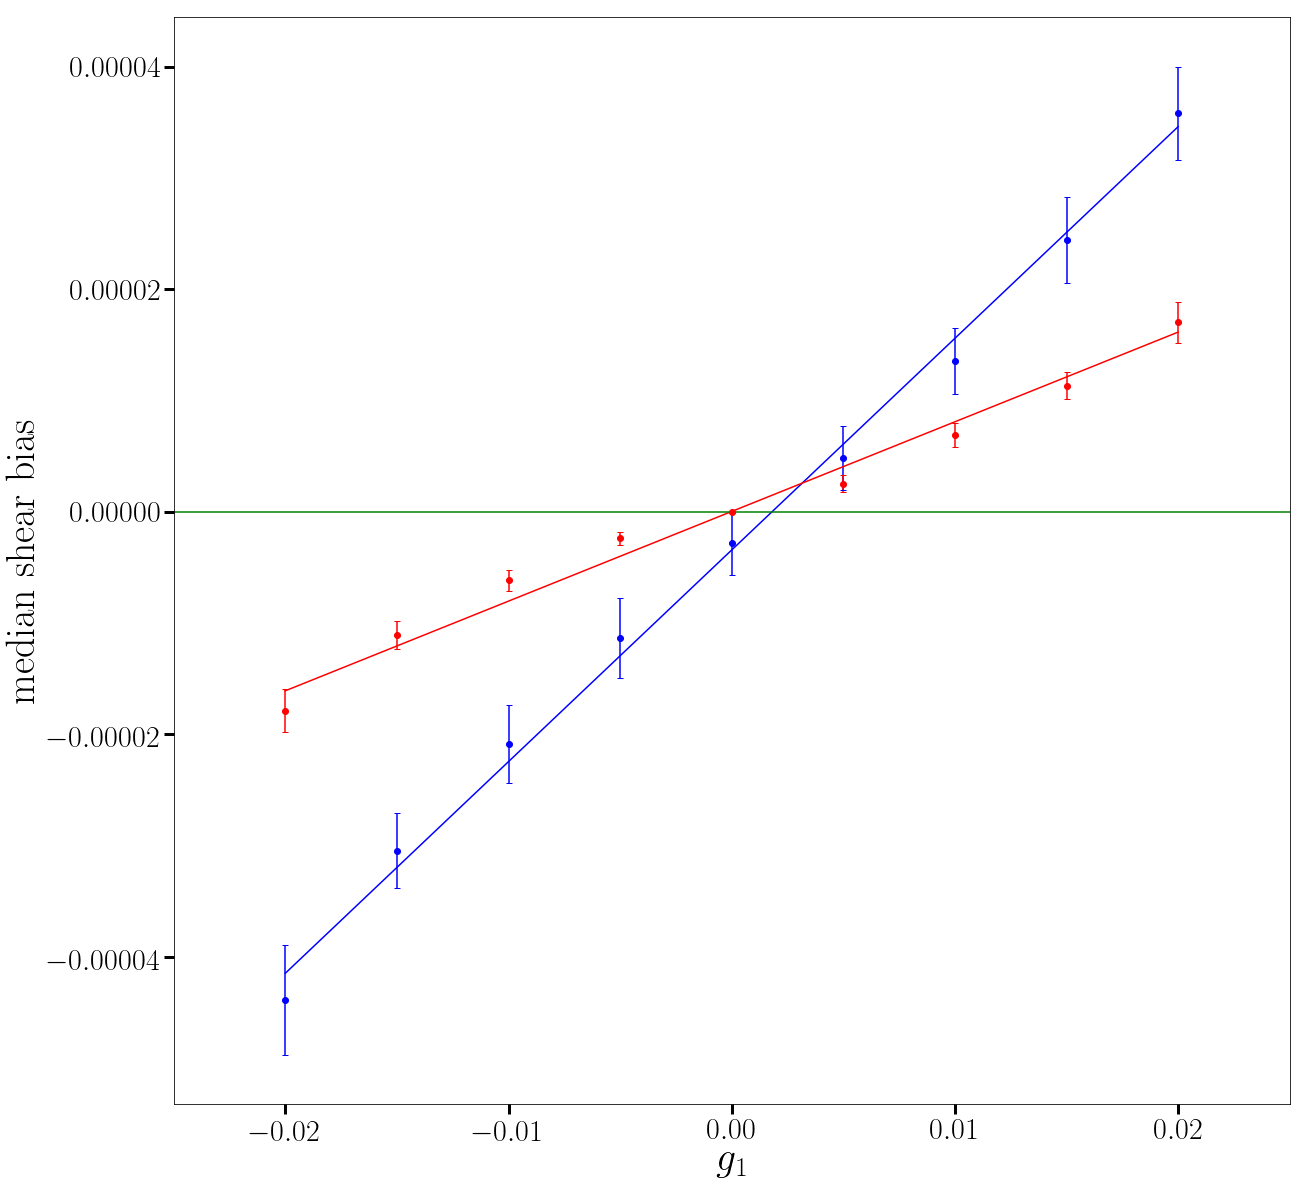

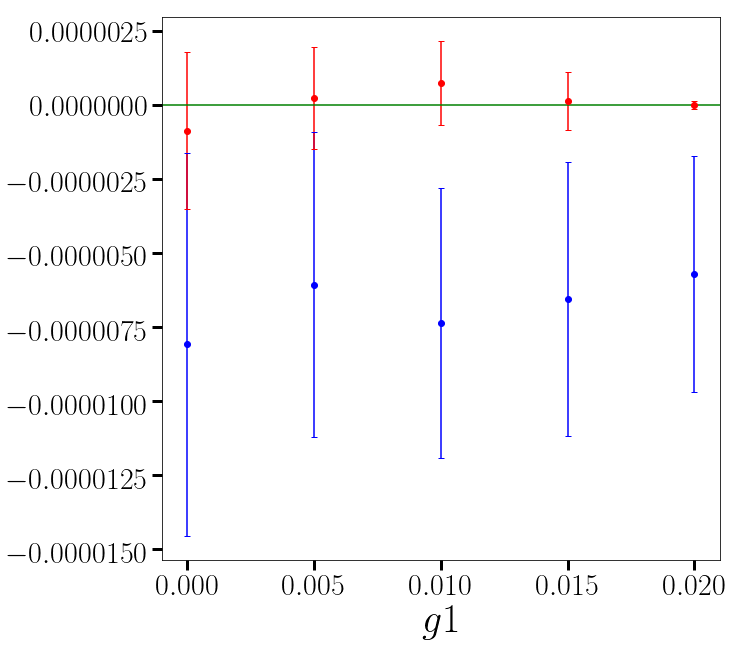

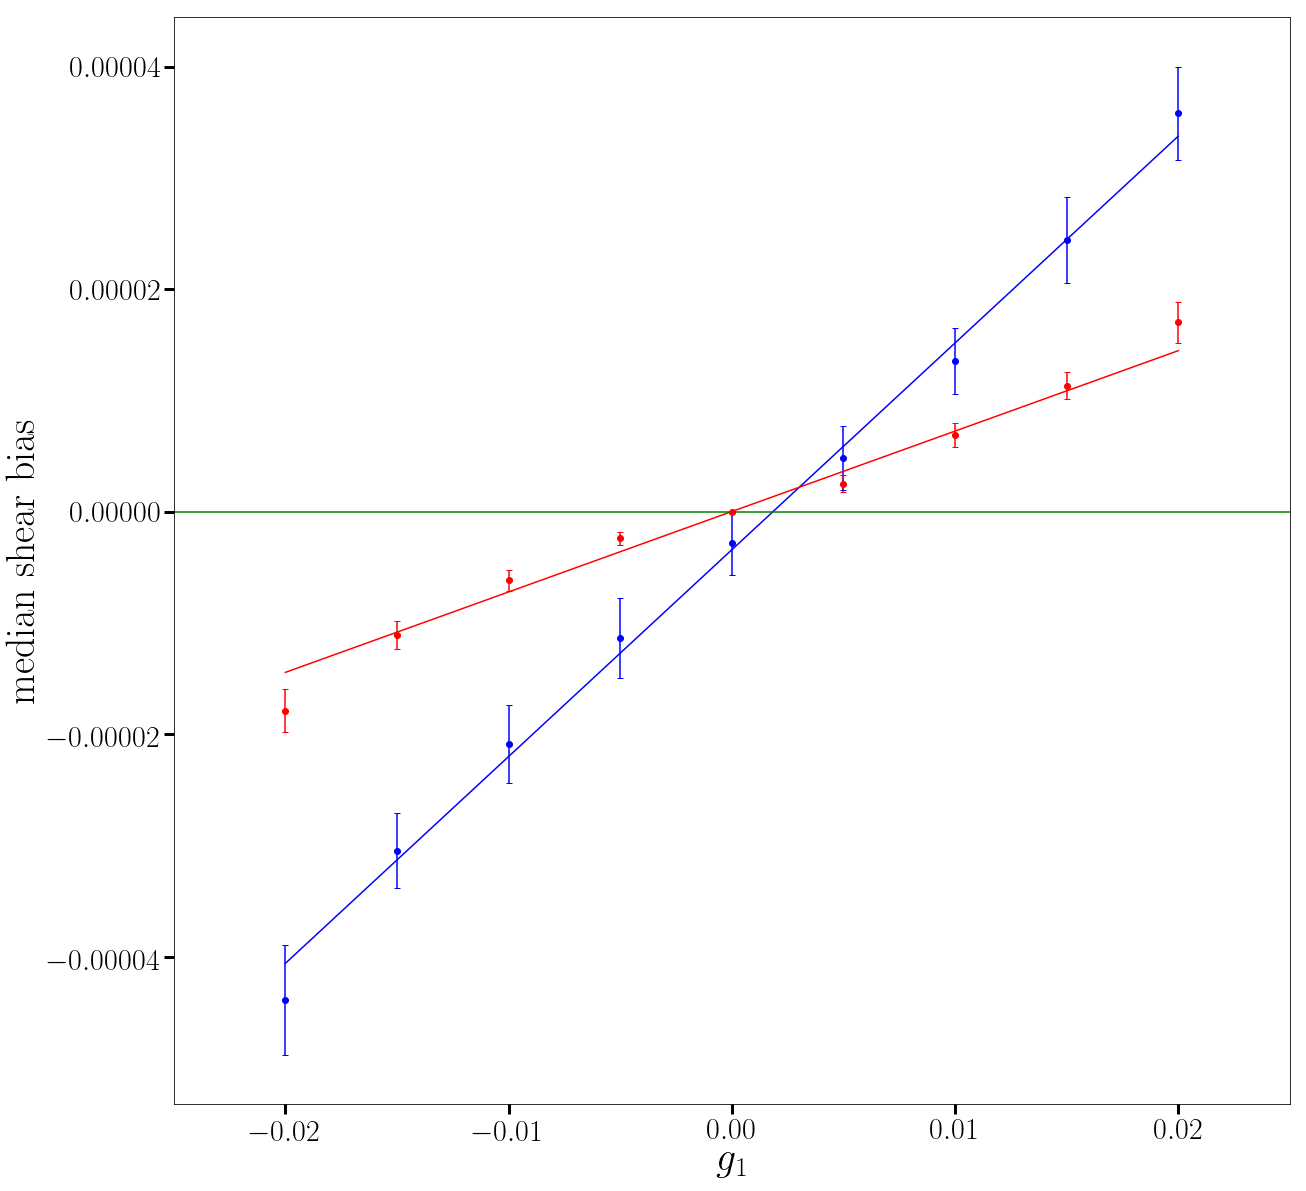

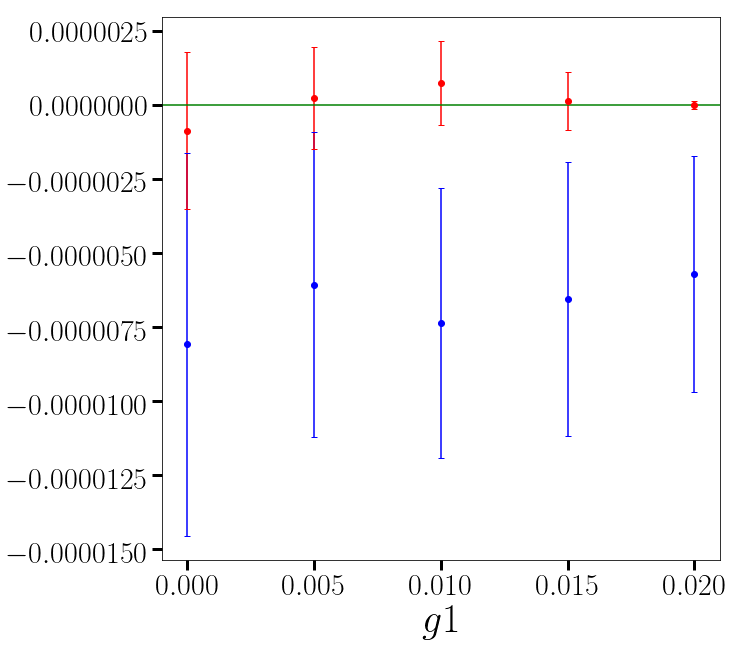

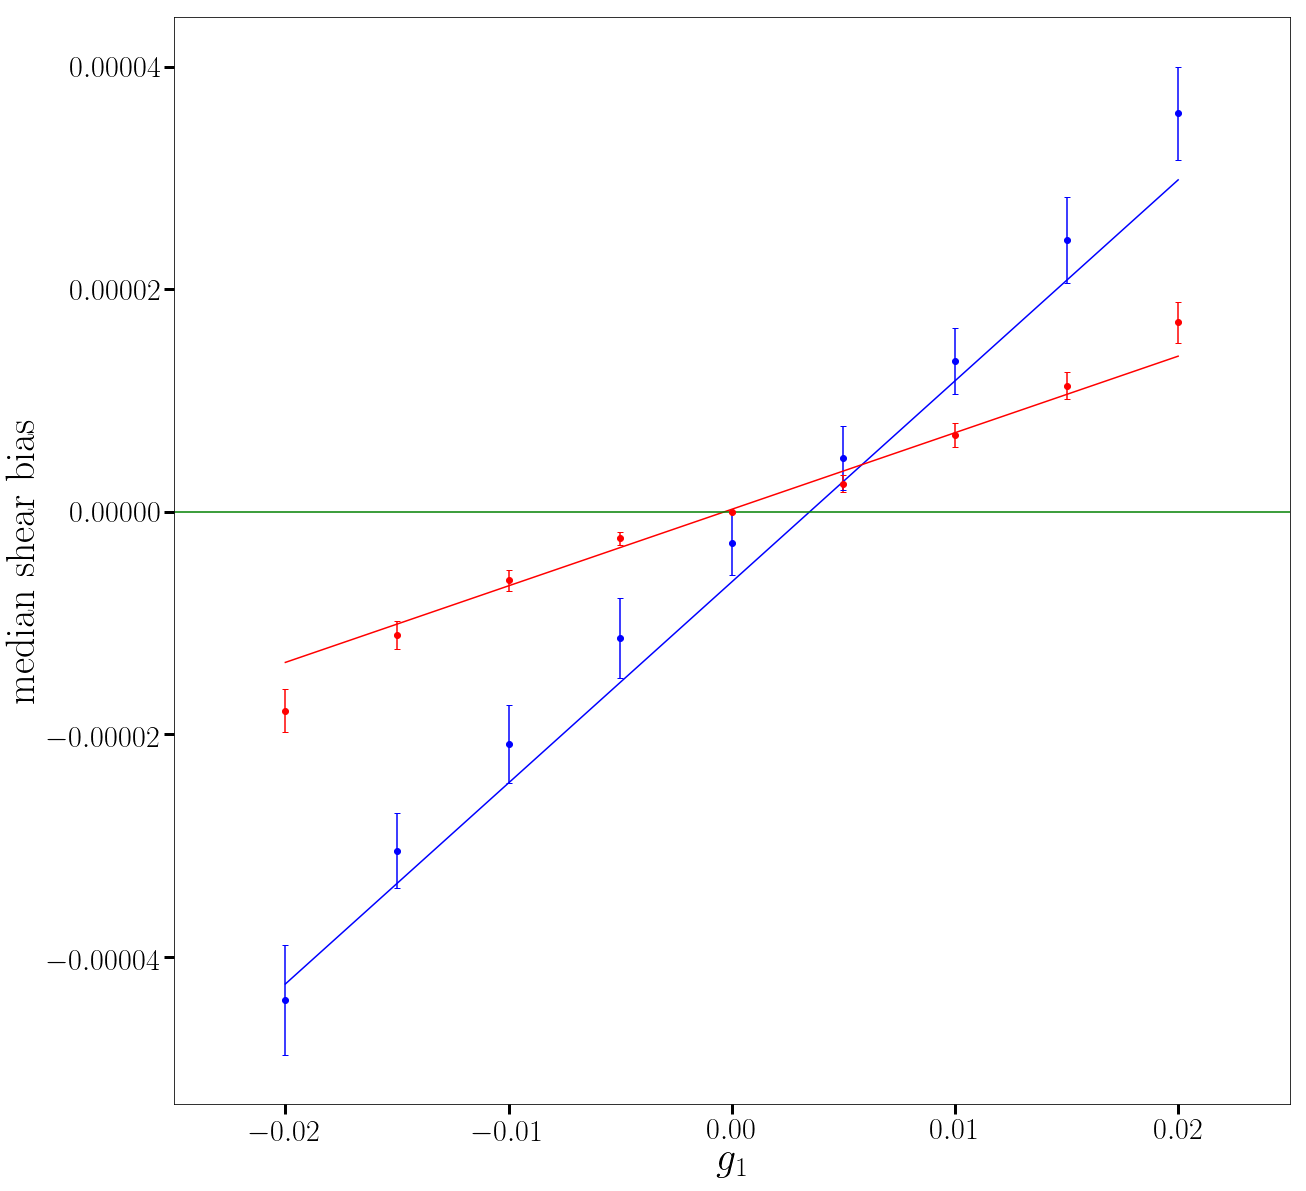

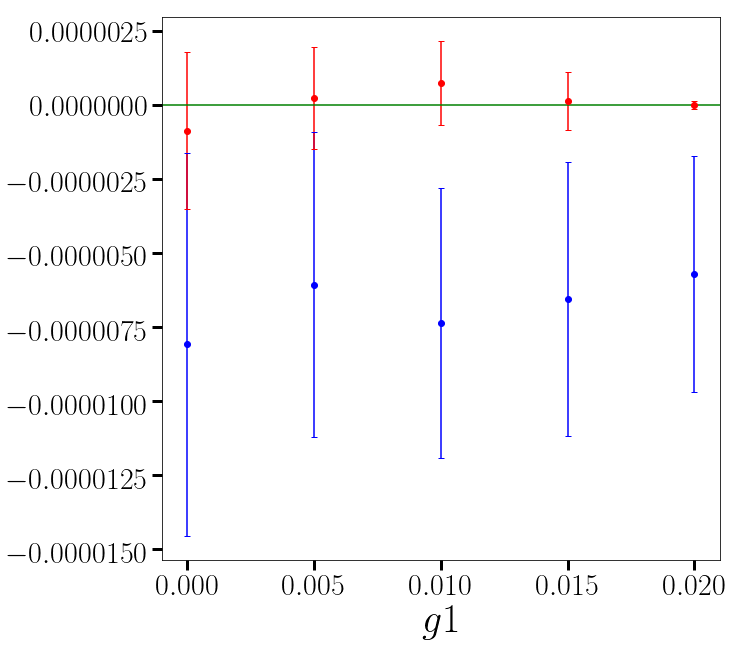

In [81]:
print 'linear fit'
print 
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')

print 
print '###################################################################################'

print 'independent chi sq '
print 

#get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp))},labely1='median shear bias')
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp': np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')



print 
print '###################################################################################'

print 'mixed chi sq '
print

get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgood_g2grp = sigma_med_boot(main_catsLSST,'bias_g2_grp',filters) 
stds_LSSTgood_g2iso = sigma_med_boot(main_catsLSST,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_LSSTgood_g2grp, stds_LSSTgood_g2iso,filters,main_catsLSST)

# DES 

## Gold

In [21]:
filters = [gold,best]

#### g1

In [24]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgold_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-6.083382e-05, -4.3239692e-05, -3.0325526e-05, -1.9896146e-05, -1.7860621e-05, 1.9478223e-06, 1.096516e-05, 2.3857307e-05, 3.8978156e-05]
sigmas grp: [0.0050557679, 0.0050973729, 0.0051644775, 0.0052130572, 0.0051384792, 0.0050382288, 0.0051085027, 0.0051329629, 0.0050904029]
errs grp: [1.5543656e-05, 1.481764e-05, 1.6068832e-05, 1.4794075e-05, 1.4766653e-05, 1.3792296e-05, 1.4928709e-05, 1.4897316e-05, 1.6175911e-05]
Beta: [ 0.00240815]
Beta Std Error: [ 0.00030801]
Beta Covariance: [[ 0.02126463]]
Residual Variance: 4.46145857229e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.543715e-05, -9.2823739e-06, -4.2521724e-06, -1.2076104e-06, 2.5281606e-08, 3.6787555e-06, 7.4198456e-06, 1.2083221e-05, 1.6988095e-05]
sigmas iso: [0.0026806057, 0.0026587714, 0.0027063512, 0.0026739959, 0.0026560463, 0.0027038625, 0.0026652717, 0.0026803096, 0.0026562614]
errs iso: [4.1221606e-06, 3.1559425e-06, 2.1079518e-06, 1.2314691e-06, 7.794

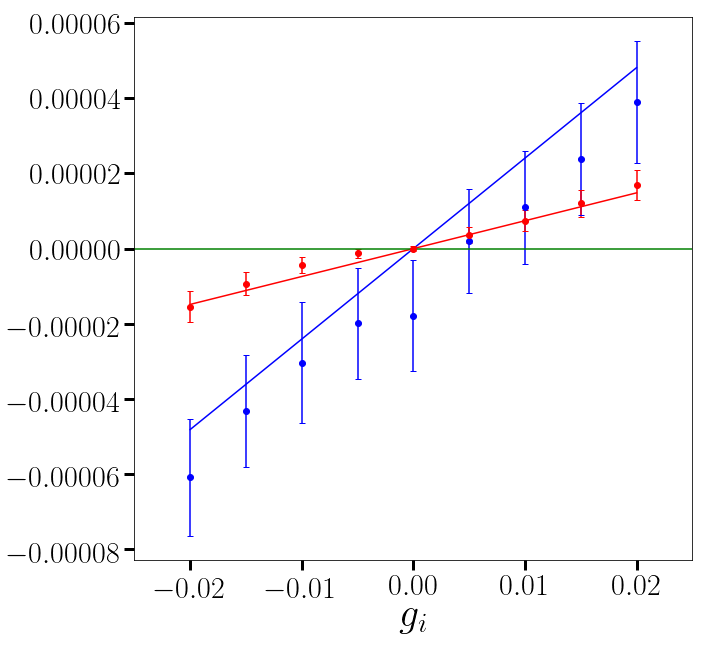

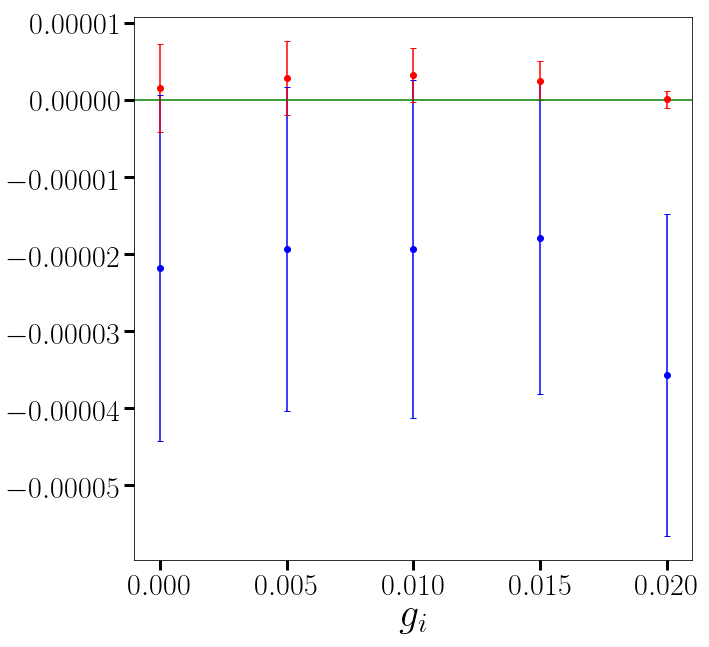

In [25]:
get_money_plot(stds_DESgold_g1grp,stds_DESgold_g1iso,filters,main_catsDES)

#### g2

In [26]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgold_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.8809266e-05, -5.3331063e-05, -3.3100583e-05, -2.3308481e-05, -8.4600324e-06, -8.5996553e-06, 7.4287959e-06, 1.9147945e-05, 3.6636287e-05]
sigmas grp: [0.005082902, 0.0050200773, 0.0050637429, 0.0051006461, 0.0050867735, 0.0050713206, 0.0050623468, 0.0051053031, 0.004978708]
errs grp: [1.711914e-05, 1.7336662e-05, 1.5518926e-05, 1.4438348e-05, 1.3799219e-05, 1.4496674e-05, 1.4229798e-05, 1.5389593e-05, 1.5893127e-05]
Beta: [ 0.00226451]
Beta Std Error: [ 0.00036924]
Beta Covariance: [[ 0.02051133]]
Residual Variance: 6.6469944466e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.5677531e-05, -1.2066728e-05, -7.5291532e-06, -4.7085073e-06, -3.6765162e-08, 1.5745287e-06, 5.387471e-06, 8.748294e-06, 1.4423226e-05]
sigmas iso: [0.0025842227, 0.002599868, 0.0026365533, 0.0026410888, 0.0025925057, 0.0025965425, 0.0026063628, 0.0026259248, 0.0026298282]
errs iso: [3.6038286e-06, 3.4319855e-06, 2.8980144e-06, 2.2094623e-06, 8.0927

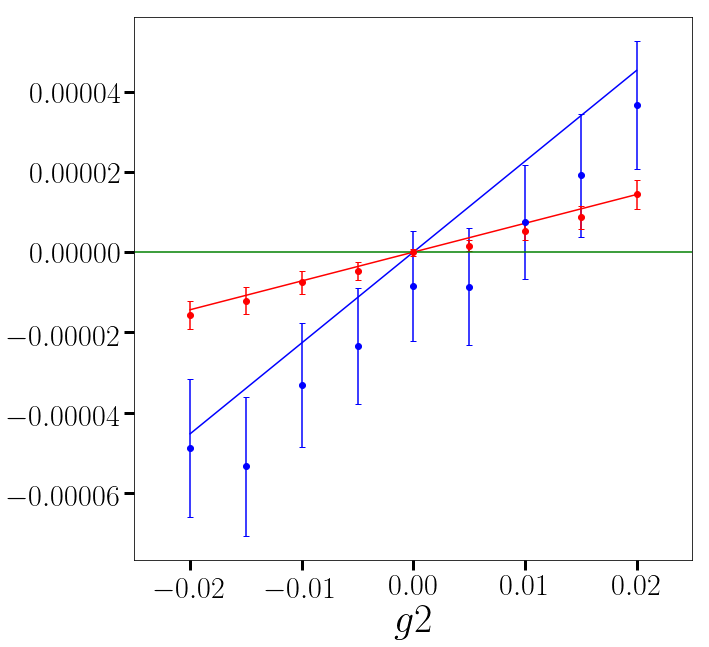

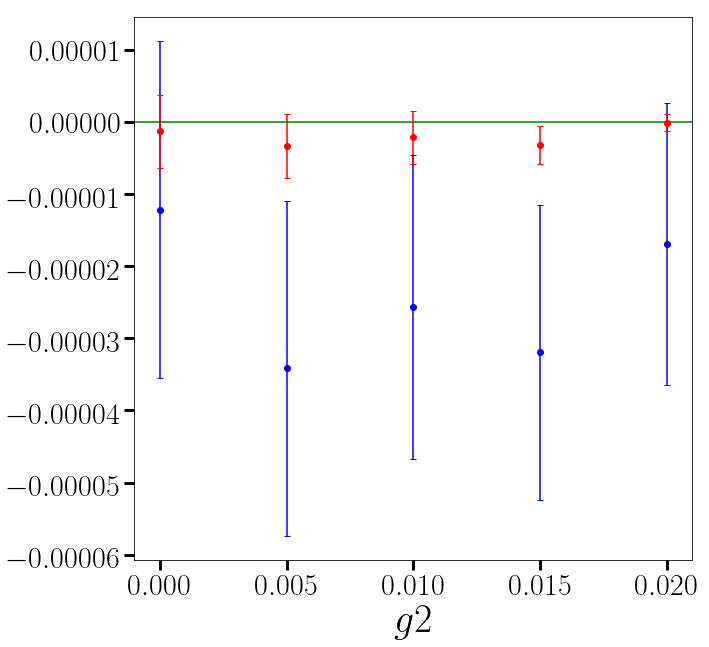

In [30]:
get_money_plot('g2',stds_DESgold_g2grp,stds_DESgold_g2iso,filters,main_catsDES)

## Good 

In [33]:
filters = [good,best]

#### g1 

In [34]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgood_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-5.5454911e-05, -3.9322531e-05, -2.3943405e-05, -1.7330402e-05, -1.315392e-05, 7.3715464e-06, 1.2361077e-05, 2.6055046e-05, 3.1955802e-05]
sigmas grp: [0.0039629629, 0.0039917971, 0.0040171258, 0.0039887554, 0.0039751353, 0.0039275335, 0.0039849537, 0.0039491272, 0.0039199893]
errs grp: [1.4572613e-05, 1.3676154e-05, 1.4738329e-05, 1.3939954e-05, 1.3680605e-05, 1.3804965e-05, 1.45469e-05, 1.4341525e-05, 1.5618549e-05]
Beta: [ 0.00218862]
Beta Std Error: [ 0.0002396]
Beta Covariance: [[ 0.01372234]]
Residual Variance: 4.18353671355e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3419607e-05, -7.9706615e-06, -3.1546401e-06, -9.3657115e-07, 1.2057097e-07, 4.2439119e-06, 7.4845548e-06, 1.2561743e-05, 1.5499449e-05]
sigmas iso: [0.0019544316, 0.0019638357, 0.001995727, 0.0019646748, 0.0019408262, 0.001967703, 0.0019724355, 0.0019677882, 0.0019763138]
errs iso: [3.6167132e-06, 2.7424173e-06, 1.7890374e-06, 1.0923292e-06, 7.54720

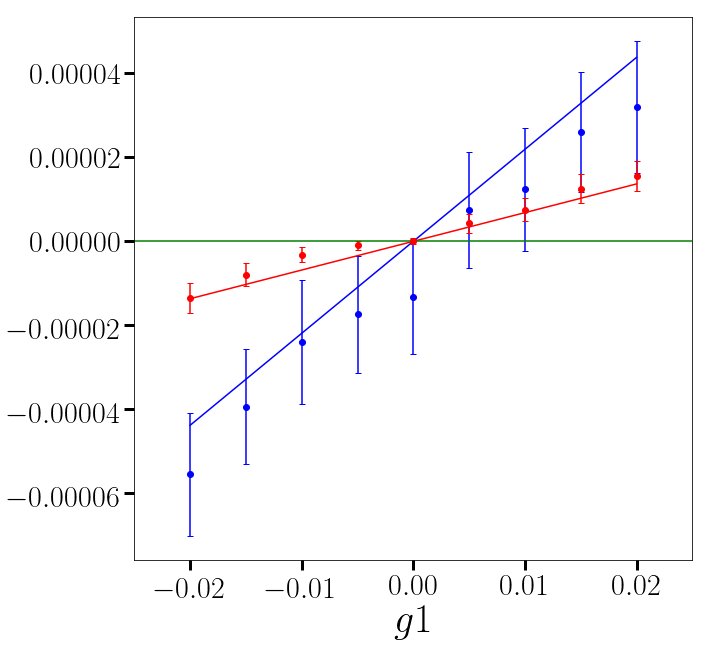

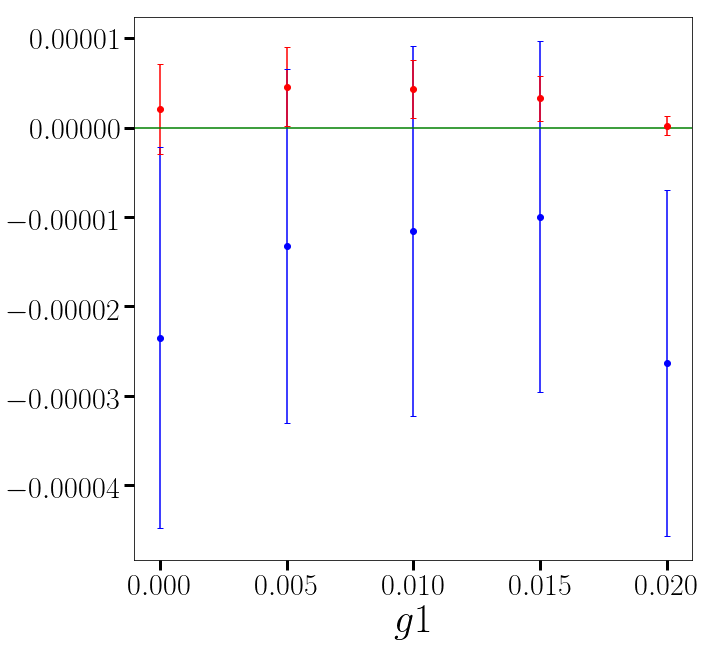

In [35]:
get_money_plot('g1', stds_DESgood_g1grp,stds_DESgood_g1iso,filters,main_catsDES)

#### g2 

In [38]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgood_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.1791842e-05, -4.3822591e-05, -3.2180295e-05, -2.1160226e-05, -6.6204402e-06, -8.3041487e-06, 1.1191978e-05, 2.5774425e-05, 3.9637904e-05]
sigmas grp: [0.003898503, 0.0038673063, 0.0038861404, 0.003903287, 0.0038105808, 0.0038384744, 0.0038999671, 0.0038913353, 0.0038131732]
errs grp: [1.6161157e-05, 1.5665251e-05, 1.4705206e-05, 1.3691537e-05, 1.3075204e-05, 1.3689654e-05, 1.3676748e-05, 1.5254018e-05, 1.5529673e-05]
Beta: [ 0.00218143]
Beta Std Error: [ 0.00027959]
Beta Covariance: [[ 0.01325054]]
Residual Variance: 5.89957398474e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3941777e-05, -9.6360955e-06, -6.844607e-06, -3.9074425e-06, -1.1669465e-08, 1.8933351e-06, 5.4773755e-06, 9.578398e-06, 1.4279096e-05]
sigmas iso: [0.001856565, 0.001876912, 0.0019177868, 0.0019134633, 0.0018636324, 0.0018983085, 0.0019229609, 0.0018907761, 0.0019310936]
errs iso: [3.1081122e-06, 2.824004e-06, 2.5493796e-06, 1.9105948e-06, 7.0594

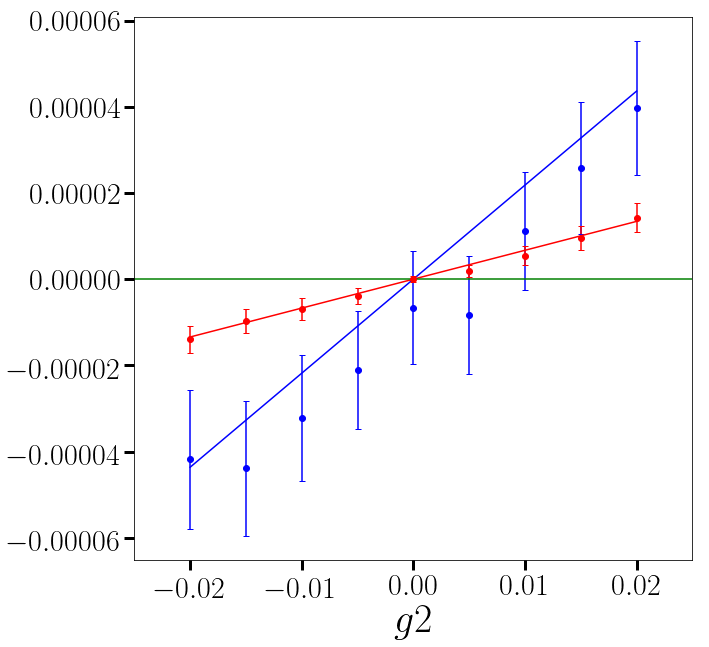

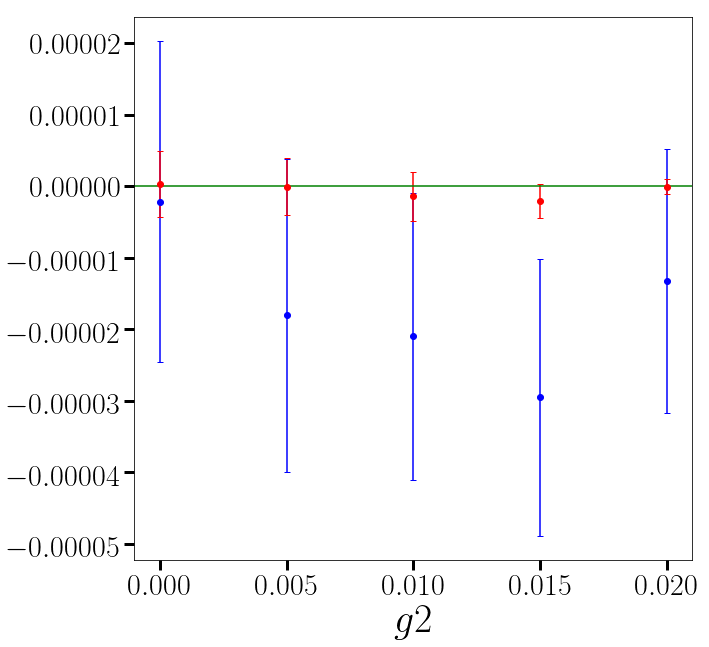

In [39]:
get_money_plot('g2', stds_DESgood_g2grp,stds_DESgood_g2iso,filters,main_catsDES)

# HSC

## Good 

In [40]:
filters = [good,best]

#### g1 

In [41]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g1grp = sigma_med_boot(main_catsHSC,'bias_g1_grp',filters) 
stds_HSCgood_g1iso = sigma_med_boot(main_catsHSC,'bias_g1',filters) 

medians grp: [-2.6274025e-05, -1.6921598e-05, -1.0513997e-05, -6.1388409e-06, -3.5439562e-08, 5.9420036e-06, 1.1555741e-05, 1.7475477e-05, 2.3183493e-05]
sigmas grp: [0.0027864773, 0.0028028633, 0.0027924096, 0.0027972078, 0.0028140338, 0.0027995664, 0.0028023976, 0.0028189735, 0.002808433]
errs grp: [3.5425237e-06, 3.4722195e-06, 2.9307757e-06, 2.6737887e-06, 2.4208018e-06, 2.6353002e-06, 3.1154882e-06, 3.379849e-06, 3.472288e-06]
Beta: [ 0.00119197]
Beta Std Error: [  2.83452517e-05]
Beta Covariance: [[ 0.00617946]]
Residual Variance: 1.30020024637e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.0503341e-05, -5.943999e-06, -3.2926325e-06, -1.3680257e-06, 6.8840507e-08, 2.4525409e-06, 5.6402473e-06, 9.2367254e-06, 1.3948767e-05]
sigmas iso: [0.0019432416, 0.001943793, 0.0019469515, 0.0019405945, 0.0019430686, 0.0019349564, 0.0019406102, 0.0019458215, 0.0019538151]
errs iso: [1.4197554e-06, 1.09825e-06, 8.6974666e-07, 5.9315721e-07, 2.7

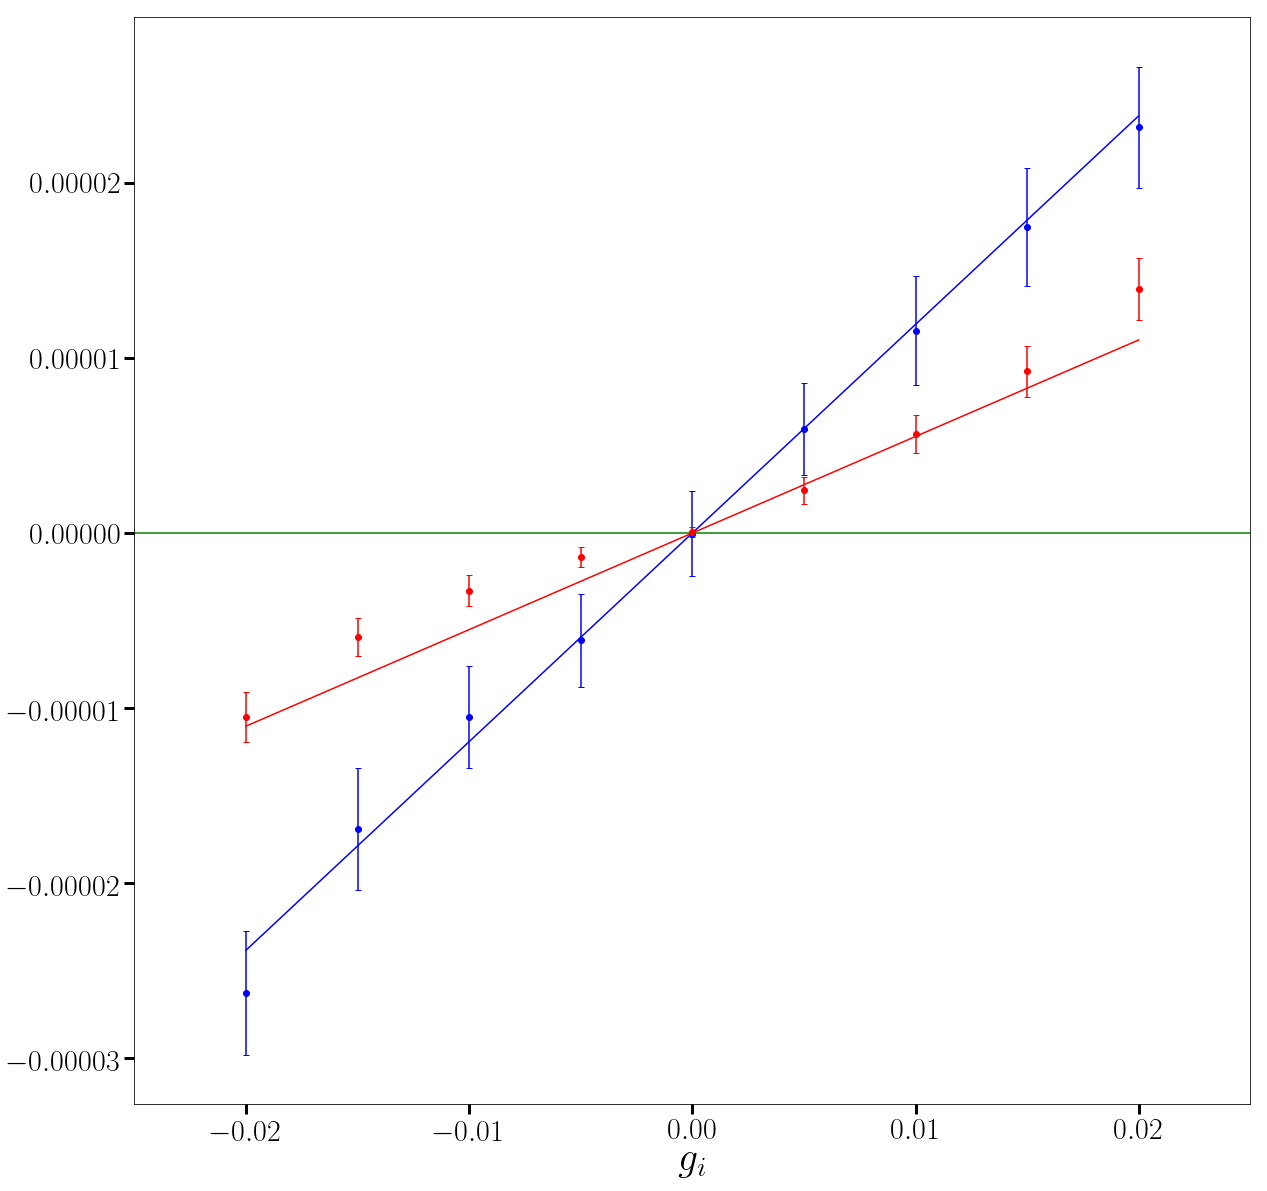

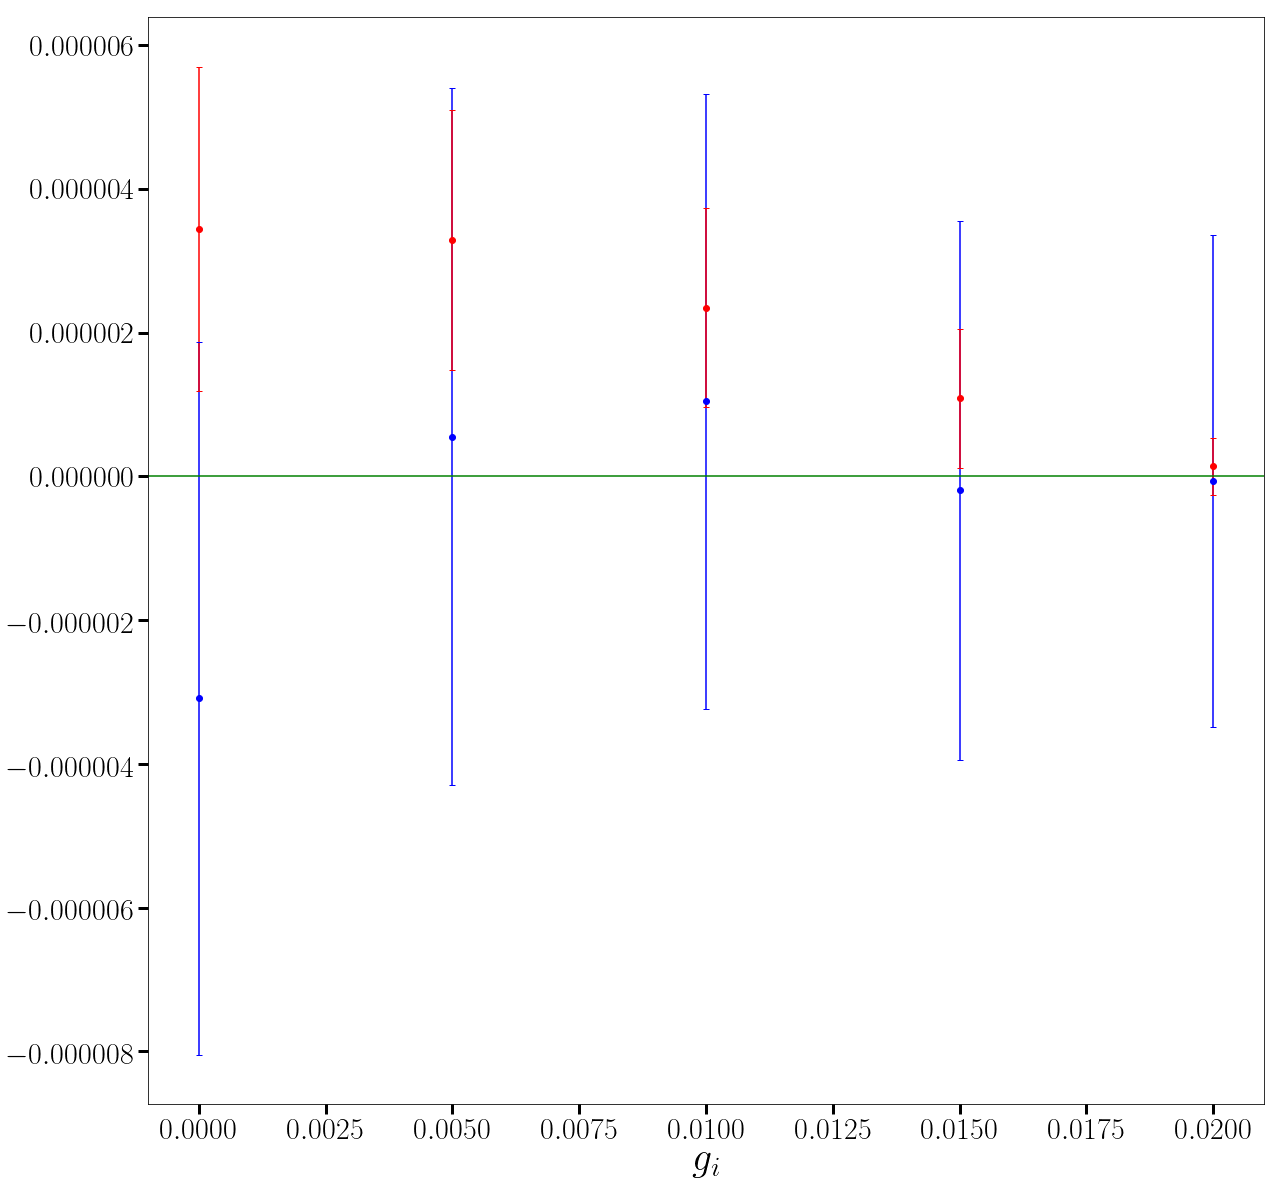

In [42]:
get_money_plot('g1', stds_HSCgood_g1grp,stds_HSCgood_g1iso,filters,main_catsHSC)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g2grp = sigma_med_boot(main_catsHSC,'bias_g2_grp',filters) 
stds_HSCgood_g2iso = sigma_med_boot(main_catsHSC,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_HSCgood_g2grp,stds_HSCgood_g2iso,filters,main_catsHSC)

# Selection Bias: Median noise bias for events selected at shear = 0 

## Histogram of Bias (with gold sample)

In [63]:
#produce different plots with the biases calculated from the fisher formalism. 

def shear_biases_plots2(cat,good,gold,save=None):
    plt.rc('text', usetex=True)


    g_min = -2
    g_max = 2
    fig, ax  = plt.subplots(figsize=(20,15))
    ax.set_xlabel('$b[g_{1}]$',fontsize=35)




    ax.set_ylabel('\\rm Fraction of galaxies',fontsize=35)
    ax.tick_params(axis='both', which='major', labelsize=20, length=6, width = 2)
    ax.tick_params(axis='both', which='minor', labelsize=20, length=3, width = 1)


    
    plt.xlim(g_min,g_max)
    

#     plt.tick_params(axis='both', which='minor',size=5)
    ax.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',
            label='\\rm All galaxies (blending off)',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    
    ax.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',
            label='\\rm All galaxies (blending on)',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    #
    ax.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',
            label='\\rm Lensing sample galaxies (blending off)',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    
    ax.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',
            label='\\rm Lensing sample galaxies (blending on)',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))
    #
    ax.hist(gold['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',color='gold',
            label='\\rm Gold sample galaxies (blending off)',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g1']))
    ax.hist(gold['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='gold',histtype='step',
            label='\\rm Gold sample galaxies (blending on)',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g1_grp']))
    
    ax.legend(prop={'size':22})
    ax.set_yscale('log')

    #
#     #
#     plt.subplot(nrow, ncol, 2) 
#     plt.tick_params(axis='both', which='minor',size=5)
#     plt.title('biases on g2',fontsize=14)
#     plt.xlabel('bias on g2',fontsize=14)
#     plt.ylabel('Fraction of galaxies',fontsize=14)
#     plt.xlim(g_min,g_max)
#     #
#     plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
#     plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')
#     #
#     plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
#     plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
#     plt.legend()
#     #
#     plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
#     plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')

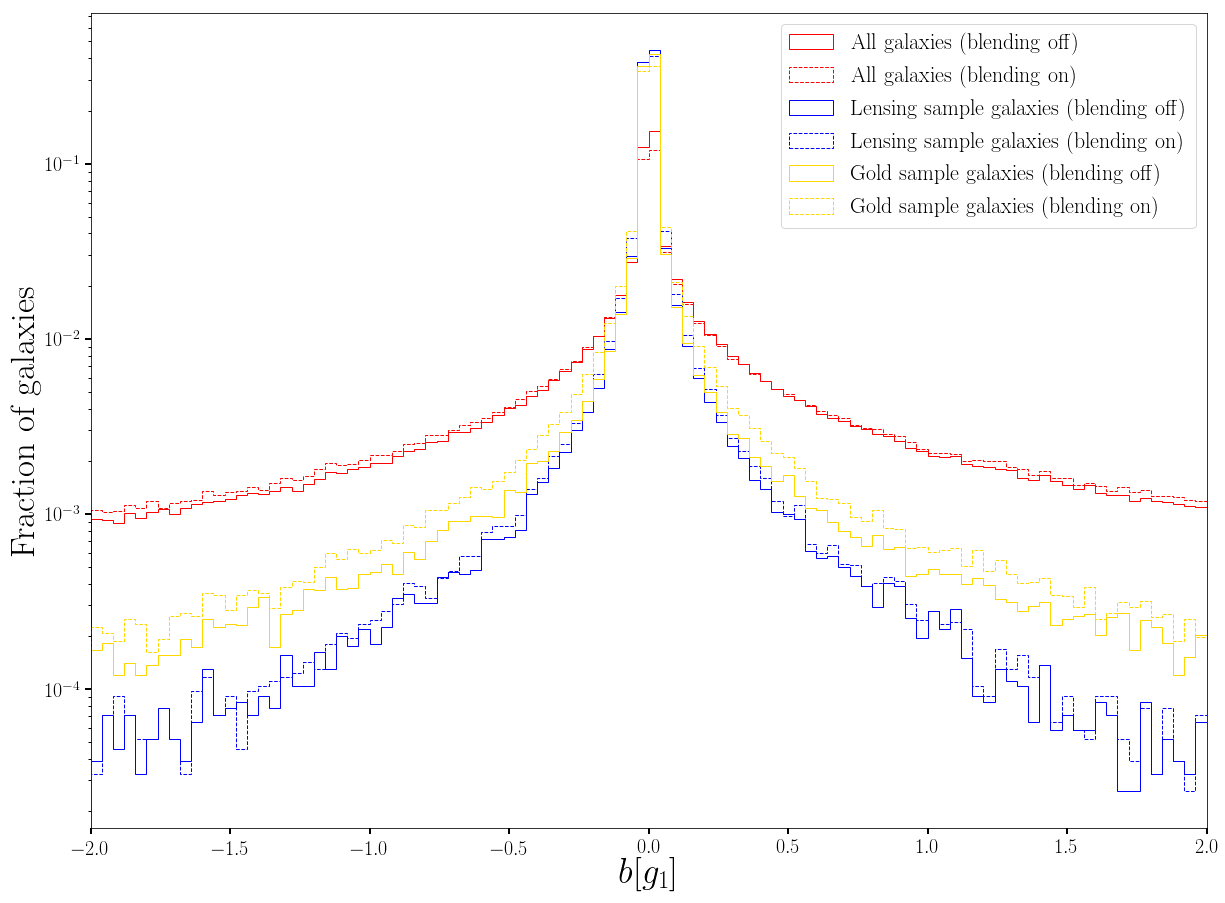

In [64]:
cat_plot = main_catsLSST[8]
shear_biases_plots2(cat_plot,good(cat_plot),gold(cat_plot))

## Histograms of shear bias (no gold sample) 

In [22]:
#produce different plots with the biases calculated from the fisher formalism. 

def shear_biases_plots3(cat,good,save=None):
    plt.rc('text', usetex=True)


    g_min = -2
    g_max = 2
    fig, ax  = plt.subplots(figsize=(20,15))
    ax.set_xlabel('$b[g_{1}]$',fontsize=35)
    
    #print medians of each histogram. 
    print(f"Median of all galaxies with blending off is {np.median(cat['bias_g1'])}")
    print(f"Median of all galaxies with blending on is {np.median(cat['bias_g1_grp'])}")
    print(f"Median of lensing sample galaxies with blending off is {np.median(good['bias_g1'])}")
    print(f"Median of lensing sample galaxies with blending on is {np.median(good['bias_g1_grp'])}")



    ax.set_ylabel('\\rm Fraction of galaxies',fontsize=35)
    ax.tick_params(axis='both', which='major', labelsize=20, length=6, width = 2)
    ax.tick_params(axis='both', which='minor', labelsize=20, length=3, width = 1)
    ax.tick_params(which= 'major', right=True)
    ax.tick_params(which= 'minor', right=True)


    
    plt.xlim(g_min,g_max)
    

#     plt.tick_params(axis='both', which='minor',size=5)
    ax.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',
            label='\\rm All galaxies (blending off)',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    
    ax.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',
            label='\\rm All galaxies (blending on)',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    #
    ax.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',
            label='\\rm Lensing sample galaxies (blending off)',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    
    ax.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',
            label='\\rm Lensing sample galaxies (blending on)',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))

    ax.legend(prop={'size':22})
    ax.set_yscale('log')

    #
#     #
#     plt.subplot(nrow, ncol, 2) 
#     plt.tick_params(axis='both', which='minor',size=5)
#     plt.title('biases on g2',fontsize=14)
#     plt.xlabel('bias on g2',fontsize=14)
#     plt.ylabel('Fraction of galaxies',fontsize=14)
#     plt.xlim(g_min,g_max)
#     #
#     plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
#     plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')
#     #
#     plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
#     plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
#     plt.legend()
#     #
#     plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
#     plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')

Median of all galaxies with blending off is 0.0012877003755420446
Median of all galaxies with blending on is 0.001979070482775569
Median of lensing sample galaxies with blending off is 2.117723306582775e-05
Median of lensing sample galaxies with blending on is 7.086619007168338e-05


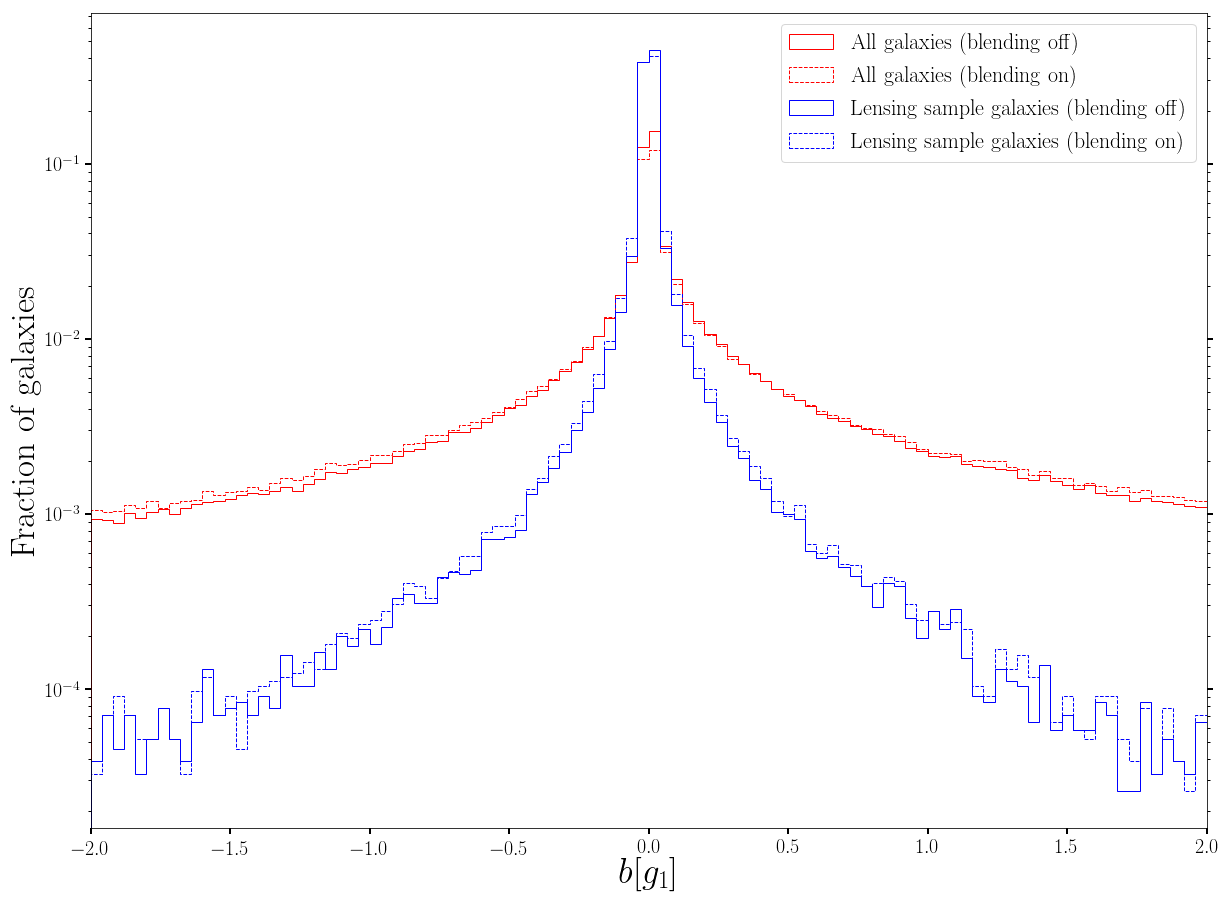

In [24]:
cat_plot = main_catsLSST[8]
shear_biases_plots3(cat_plot,good(cat_plot))

In [86]:
print(errs_param_boot([good(main_catsLSST[8])],'bias_g1', np.median, N = 10000))

just to check that symmetry is respected print both percentiles: [  1.58798321e-06   1.38881296e-06]
[1.3888129615224898e-06]


In [87]:
np.median(good(main_catsLSST[8])['bias_g1'])

2.1177233e-05

## Histograms of ab_mag 

In [75]:
def histograms_abmag(cat,good):
    plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    
#     norm= 1./len(cat['ab_mag'])
#     weights = [norm] * len(good['ab_mag'])
    plt.hist(cat['ab_mag'], histtype='step', bins=18,color='blue',label='all galaxies',range=(20,29))
    plt.hist(good['ab_mag'], histtype='step',bins=18,color='red',label='lensing sample galaxies',range=(20,29))

    labels = [r'$0$',r'$10$',r'$20$',r'$30$',r'$40$']
    values = [0,10,20,30,40]
    conversion = 3600
    y = [value*conversion for value in values]
    plt.yticks(y, labels)
    
    
    plt.xlim((20,29))
    plt.ylabel(r'\rm Galaxies / sq. arcmin. / (0.5 mag)', fontsize=25)
    plt.xlabel(r'\rm Catalog AB magnitude',fontsize=25)
#     plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2,prop={'size':20})
    plt.axvline(25.3,color='goldenrod',label='cut for golden sample') #this represents the gold sample cut.
    plt.xticks(size=20)
    plt.yticks(size=20)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)
    plt.savefig('/Users/Ismael/Desktop/hist_new1.pdf')



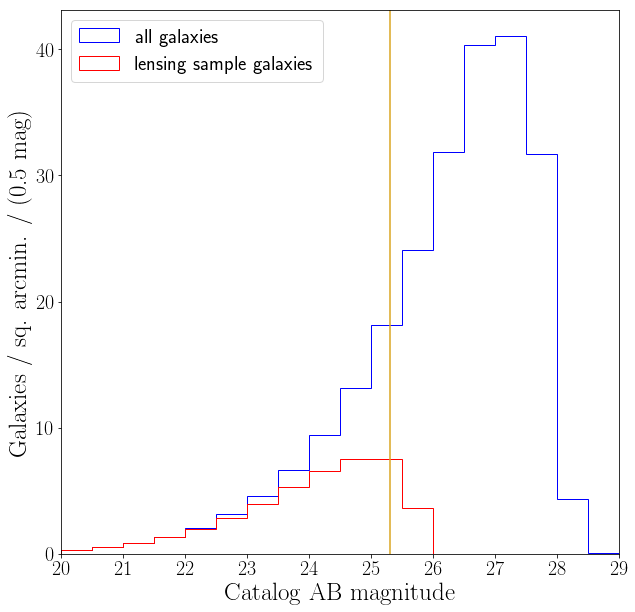

In [76]:
histograms_abmag(main_catsLSST[4],good(main_catsLSST[4]))

In [69]:
len(down_cut(up_cut(main_catsLSST[4],'ab_mag',27.5),'ab_mag',28))

114078

## Histogram for non-ambiguous blended and such, 

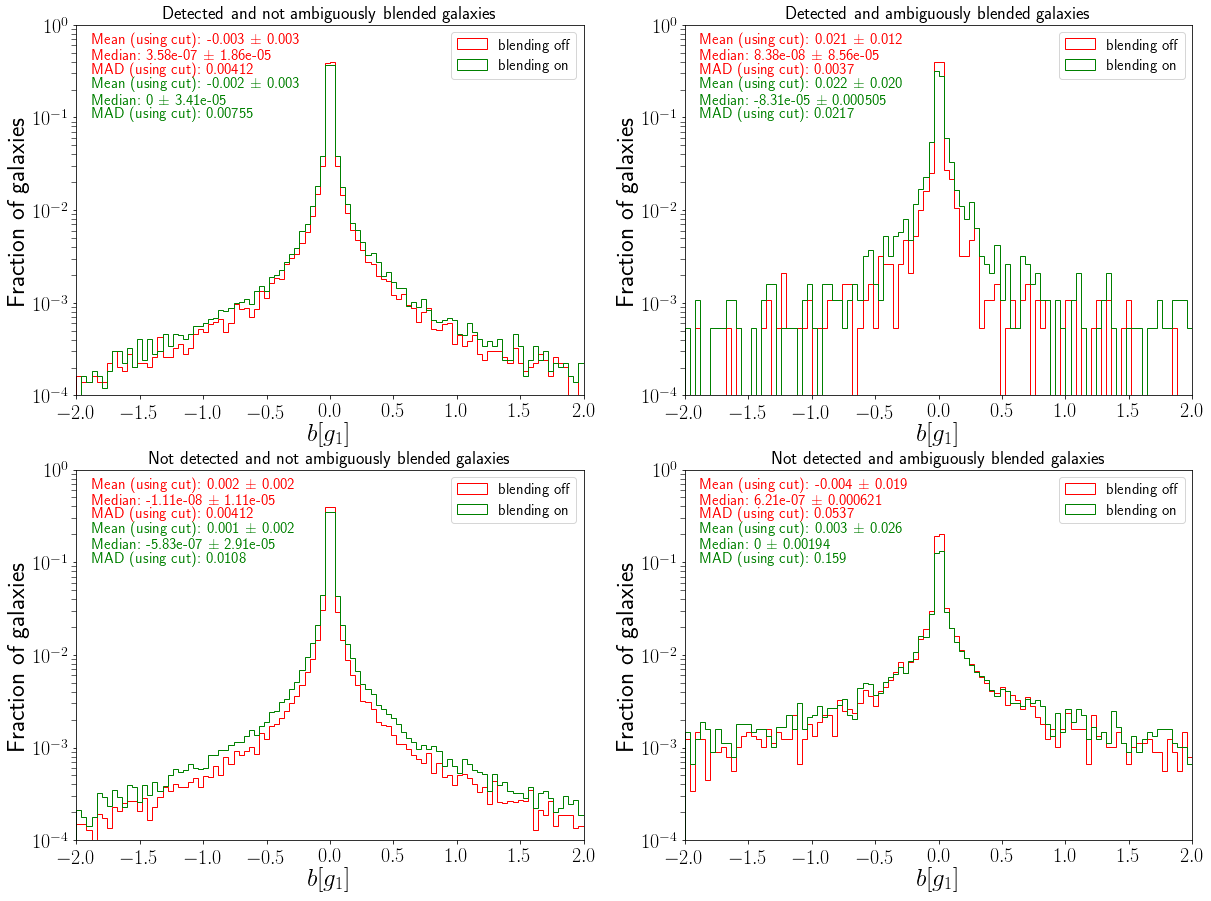

In [249]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2
g_min = -2. 
g_max = 2.
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']

cats =[detc_and_notambig(gold(main_cats[0])),
detc_and_ambig(gold(main_cats[0])),
notdetc_and_notambig(gold(main_cats[0])),
notdetc_and_ambig(main_cats[0])]

colors = ('red','green')
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})



## Shear bias histograms 

In [91]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)


def shear_biases_hists(cat,colors,g_min,g_max,err_mean_iso=None,err_median_iso=None,err_mean_grp=None,err_median_grp=None,save=None):
    
    #plt.title(name,fontsize=18)

    plt.xlabel(r'$b(g_{1})$',fontsize=28)
    plt.ylabel(r'\rm Fraction of galaxies',fontsize=28)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.xticks(size=20)
    plt.yticks(size=20)
    
    
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='\\rm blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='\\rm blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    plt.xlim(-2,2)
    plt.legend(prop={'size':28})
    
#     if err_mean_iso != None and err_median_iso != None and err_mean_grp != None and err_median_grp != None: 
    
    
#         #print mean and stuff 
#         cut_cat = abs_cut(cat, 'bias_g1_grp', 1.5)
#         print('Mean bias_iso for cat:              {:.3g}'.format(np.mean(cut_cat['bias_g1'])))
#         print'Error on mean bias_iso for all cat: {:.3g}'.format(err_mean_iso) 
#         print 'median bias_iso for cat:            {:.3g}'.format(np.median(cat['bias_g1'])) 
#         print 'error on median bias_iso for cat:   {:.3g}'.format(err_median_iso) 

#         print 'Mean bias_grp for cat:              {:.3g}'.format(np.mean(cut_cat['bias_g1_grp'])) 
#         print 'Error on mean bias_grp for all cat: {:.3g}'.format(err_mean_grp) 
#         print 'median bias_grp for cat:            {:.3g}'.format(np.median(cat['bias_g1_grp'])) 
#         print 'error on median bias_grp for cat:   {:.3g}'.format(err_median_grp) 


#     print 'Error on mean bias_iso for all cat: {}'.format(err_mean_iso) 

#     mean_cut_iso = np.mean(cut_biasiso(cat,10.)['bias_g1'])
#     std_cut_iso = np.std(cut_biasiso(cat,10.)['bias_g1'])
#     median_iso = np.median(cat['bias_g1'])
#     mad_iso = mad(cut_biasiso(cat,10.)['bias_g1'])
#     error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat,10)))
#     error_mad_iso = mad_iso/np.sqrt(len(cut_biasiso(cat,10.)['bias_g1']))
    
#     mean_cut_grp = np.mean(cut_biasgrp(cat,10)['bias_g1_grp'])
#     std_cut_grp = np.std(cut_biasgrp(cat,10)['bias_g1_grp'])
#     median_grp = np.median(cat['bias_g1_grp'])
#     mad_grp = mad(cut_biasgrp(cat,10)['bias_g1_grp'])
#     error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat,10)))
#     error_mad_grp = mad_grp/np.sqrt(len(cut_biasgrp(cat,10)['bias_g1_grp']))
    
#plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=15)
#plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=15)
#plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=15)
#plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=15)
#plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=15)
#plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=15)

In [92]:
cat = main_catsLSST[4]
cut_cat = abs_cut(cat, 'bias_g1_grp', 1.5)



# err_mean_iso = errs_mean_boot([good(best(cut_cat))],'bias_g1')[0]
# err_median_iso = errs_med_boot([best(good(cat))],'bias_g1')[0]
# err_mean_grp = errs_mean_boot([best(good(cut_cat))],'bias_g1_grp')[0]
# err_median_grp = errs_med_boot([best(good(cat))],'bias_g1_grp')[0]




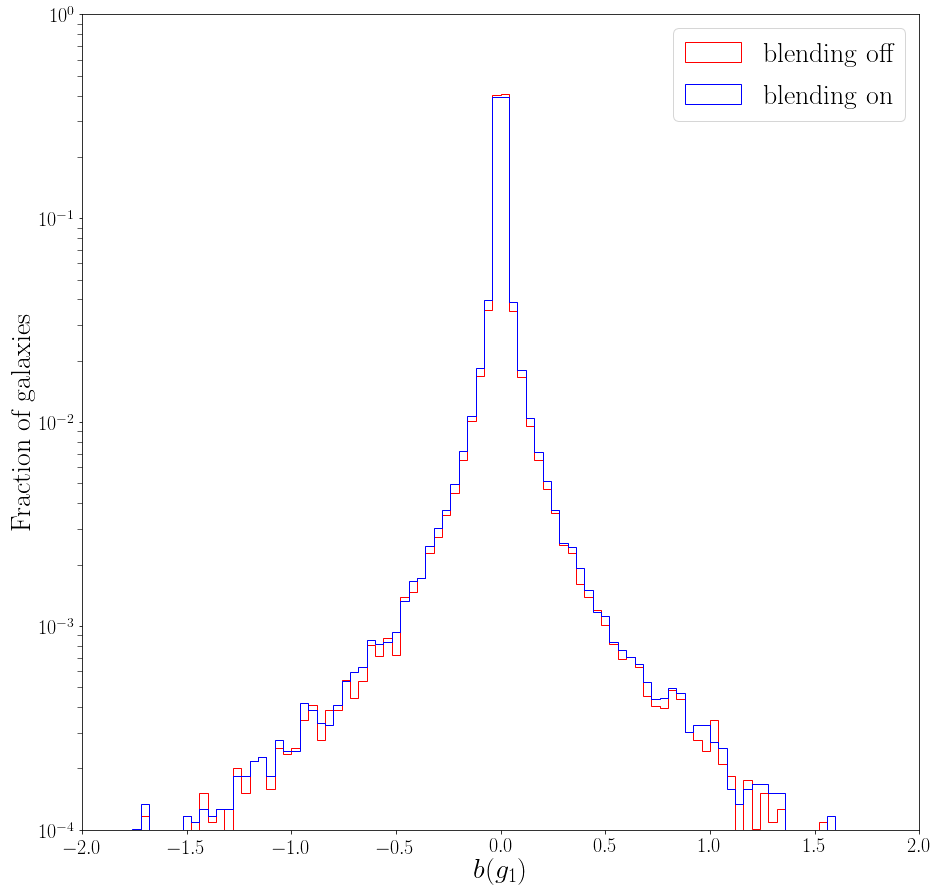

In [93]:
fig = plt.figure(figsize=(15,15))
nrow,ncol = 1,1
g_min = -2
g_max = 2


colors = ('red','blue')
plt.subplot(111)
shear_biases_hists(good(best(main_catsLSST[4])),colors,g_min,g_max,err_mean_iso,err_median_iso,err_mean_grp,err_median_grp)

plt.savefig("/Users/Ismael/Desktop/hist-medians-no-shear.pdf")




# Median shear bias of Purity and SNR bins 

## Functions for plotting 

In [145]:
# this new function plots both blending off and blending on bias on g1 shear. 
def plot_bias_bins_both(cat,bins,bin_param,yrange=None,xrange=None, xlabel = None, 
                  ylabel = None,title = None, xlogscale = False, ylogscale = False, scientific = False, draw_cut_lensing=False): 
    
    plt.rc('text', usetex = True)
    fig, ax = plt.subplots(figsize=(10,10))
    
    min_bin,max_bin = np.min(cat[bin_param]), np.max(cat[bin_param])
    print(f'min {bin_param}, max {bin_param}:', min_bin, max_bin)
    print('bins', bins )
    
    #blending off 
    small_cats, x, y_isos,errs_x1, errs_x2 = binning_helper(bins, cat, bin_param, 'bias_g1')
    x_errs = [errs_x1,errs_x2]     # put the errors into a list 
    y_errs_iso = errs_param_boot(small_cats,'bias_g1', np.median,N=1000)     #get y errs, this are the error in the median shear bias calculated 
    
    
    #blending on. 
    _, _, y_grps,_, _ = binning_helper(bins, cat, bin_param, 'bias_g1_grp')
    y_errs_grp = errs_param_boot(small_cats,'bias_g1_grp', np.median,N=1000)     
    
    print('x_errs')
    print(x_errs)
    print()
    print('x')
    print(x)
    print()
    print('y_errs for bias_g1')
    print(y_errs_iso)
    print() 
    print('y for bias_g1')
    print(y_isos)
    print()
    print('y_errs for bias_g1_grp')
    print(y_errs_grp)
    print() 
    print('y for bias_g1_grp')
    print(y_grps)
    print() 
    
    #deal with negative points per pat's slack comment. 
    for i,(y_iso,y_grp) in enumerate(zip(y_isos, y_grps)): 
        if y_iso < 0: 
            print('negative iso')
            y_errs_iso[i] = y_errs_iso[i] + y_isos[i] - 0.8e-7 
            y_isos[i] = 0.8e-7  #set point somewhere below 10^{-7} but not negative. 
            
        if y_grp < 0: 
            print('negative grp')
            y_errs_grp[i] = y_errs_grp[i] + y_grps[i] - 0.8e-7 
            y_grps[i] = 0.8e-7  #set point somewhere below 10^{-7} but not negative.
            
            
    #mark that we have a cut at snr = 6 
    if draw_cut_lensing:
        ax.axvline(x=6, color='g')
            
    
    
    
    #x_errs[1][-1] = 29.94817734 #make the last one symmetric to avoid running off plot
    
    ########################################## formating ##########################################
        
    #ax.set_yscale('log')
    if xlogscale: 
        ax.set_xscale('log')
    
    if ylogscale: 
        ax.set_yscale('log')
    
    if yrange: 
        ax.set_ylim(yrange)
    if xrange: 
        ax.set_xlim(xrange)
        
    ax.set_title(title, size =28)
    ax.set_xlabel(xlabel, size = 24)
    ax.set_ylabel(ylabel, size = 24)
        
    
    ax.tick_params(axis='both', which='major', labelsize=20)

    #scientfic notation. 
    if scientific == True: 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(15)
        
    elif scientific == 'yes': 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(1)
    
    ax.axhline(y=0.0, color='g', linestyle=':')    
    
    ########################################## plotting ##########################################

    ax.errorbar(x,y_isos,xerr=x_errs,yerr=y_errs_iso,fmt='o',capsize=5,ecolor='r',color = 'r', label = '\\rm Blending off')
    ax.errorbar(x,y_grps,xerr=x_errs,yerr=y_errs_grp,fmt='o',capsize=5,ecolor='b',color = 'b', label = '\\rm Blending on')
    
    ax.legend(prop=dict(size=22))
 

In [146]:
# this new function plots both blending off and blending on bias on g1 shear. 
def plot_bias_bins(cat,bins,bin_param,bias_type, yrange=None,xrange=None, xlabel = None, 
                  ylabel = None, title = None, xlogscale = False, ylogscale = False,  scientific = False, ): 
    
    plt.rc('text', usetex = True)
    fig, ax = plt.subplots(figsize=(10,10))
    
    min_bin,max_bin = np.min(cat[bin_param]), np.max(cat[bin_param])
    print(f'min {bin_param}, max {bin_param}:', min_bin, max_bin)
    print('bins', bins )
    
    #blending off 
    small_cats, x, y, errs_x1, errs_x2 = binning_helper(bins, cat, bin_param, bias_type)
    x_errs = [errs_x1,errs_x2]     # put the errors into a list 
    y_errs = errs_param_boot(small_cats, bias_type, np.median,N=1000)     #get y errs, this are the error in the median shear bias calculated 
    
    
    
    print('x_errs')
    print(x_errs)
    print()
    print('x')
    print(x)
    print()
    print(f'y_errs for {bias_type}')
    print(y_errs)
    print() 
    print(f'y for {bias_type}')
    print(y)
 
    
    
    
    #x_errs[1][-1] = 29.94817734 #make the last one symmetric to avoid running off plot
    
    ########################################## formating ##########################################
        
    #ax.set_yscale('log')
    if xlogscale: 
        ax.set_xscale('log')
    
    if ylogscale: 
        ax.set_yscale('log')
    
    if yrange: 
        ax.set_ylim(yrange)
    if xrange: 
        ax.set_xlim(xrange)
        
    ax.set_title(title, size =28)
    ax.set_xlabel(xlabel, size = 24)
    ax.set_ylabel(ylabel, size = 24)
        
    
    ax.tick_params(axis='both', which='major', labelsize=20)

    #scientfic notation. 
    if scientific == True: 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(15)
        
    elif scientific == 'yes': 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(1)
    
    ax.axhline(y=0.0, color='g', linestyle=':')    
    
    ########################################## plotting ##########################################

    ax.errorbar(x,y,xerr=x_errs,yerr=y_errs,fmt='o',capsize=5,ecolor='r',color = 'b')

In [147]:
def binning_helper(bins, cat, bin_param, bias_type): 
    small_cats = []
    x = [] 
    y = [] 
    errs_x1 = [] 
    errs_x2 = []
    for i in range(len(bins)-1):
        small_cat = down_cut(up_cut(cat,bin_param,bins[i]),bin_param,bins[i+1])

        #if the cutted catalogue turns out to be empty, ignore it. 
        if len(small_cat) == 0: 
            continue 


        small_cats.append(small_cat) 

        median_bin_value = np.median(small_cat[bin_param])
        small_bias = np.median(small_cat[bias_type])

        #want 'error bars on x' showing the extent of the bin widths
        errs_x1.append(np.absolute(bins[i] - median_bin_value))
        errs_x2.append(np.absolute(bins[i+1] - median_bin_value))

        #print the error for this param, we want all of them to be the same 

        #err_y.append(np.std(abs_cut(small_cat,param,10)[param]))
        x.append(median_bin_value)
        y.append(small_bias)
    
    return small_cats, np.array(x), np.array(y), np.array(errs_x1), np.array(errs_x2) 

## Plotting 

### All galaxies,  snr_grpf, b(g1) blending off 

In [148]:
cat = main_catsLSST[8]
#snrs = [2**i for i in range(0,8)]

In [149]:
snrs = [1.5,3.0,6.0,12,24,48,96,192] 

In [150]:
snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias}"
title = '\\rm{All galaxies}' 


xrange = [1, 192]
yrange = [1e-7,1e-1]

In [151]:
# plot_bias_bins(cat,snrs, 'snr_grpf', 'bias_g1', yrange=yrange, xrange=xrange, 
#               xlabel = xlabel , ylabel = ylabel, 
#               title = title, xlogscale = True, ylogscale = True, scientific = True)

min snr_grpf, max snr_grpf: 2.09402e-06 23278.7
bins [1.5, 3.0, 6.0, 12, 24, 48, 96, 192, 23278.695]
just to check that symmetry is respected print both percentiles: [ 0.00060537  0.00050979]
just to check that symmetry is respected print both percentiles: [ 0.00014647  0.00017954]
just to check that symmetry is respected print both percentiles: [  3.54619557e-05   4.46637277e-05]
just to check that symmetry is respected print both percentiles: [  9.82759229e-06   1.07846834e-05]
just to check that symmetry is respected print both percentiles: [  3.78618097e-06   3.12539305e-06]
just to check that symmetry is respected print both percentiles: [  1.04920605e-06   8.06786047e-07]
just to check that symmetry is respected print both percentiles: [  2.26974777e-07   2.69612751e-07]
just to check that symmetry is respected print both percentiles: [  1.50040798e-08   1.48360151e-08]
just to check that symmetry is respected print both percentiles: [ 0.00104671  0.00089888]
just to check that s

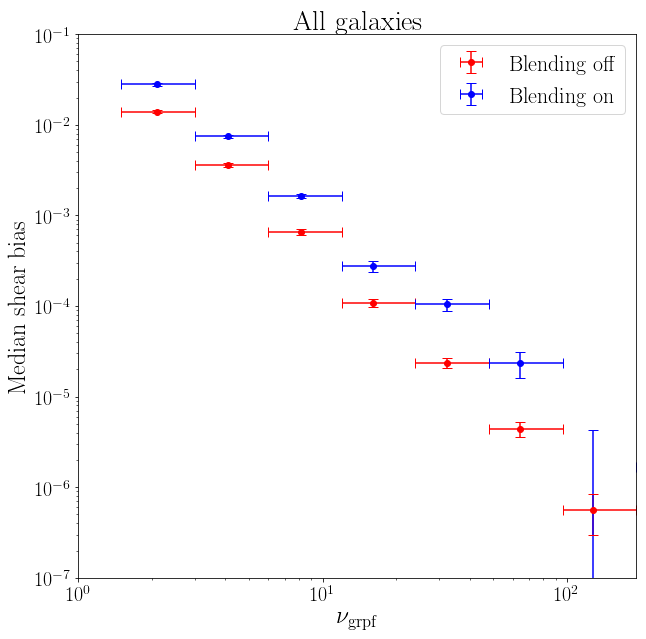

In [152]:
plot_bias_bins_both(cat,snrs, 'snr_grpf', yrange=yrange, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, 
              title = title, xlogscale = True, ylogscale = True, scientific = False, draw_cut_lensing=False)

## SNR bins for cut only on size. 

In [133]:
size_cut_cat = up_cut(main_catsLSST[8], 'sigma_m', 0.2)  
#snrs = [2**i for i in range(0,8)]

In [134]:
snrs = [1.5,3.0,6.0,12,24,48,96,192] 

snrs.append(np.max(cat['snr_grpf']))

In [135]:
xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias}"
title = '\\rm{Galaxies with } $\\sigma_{-} > 0.2$' 

xrange = [1, 192]
yrange = [1e-7,1e-1]

min snr_grpf, max snr_grpf: 2.09402e-06 23278.7
bins [1.5, 3.0, 6.0, 12, 24, 48, 96, 192, 23278.695]
just to check that symmetry is respected print both percentiles: [ 0.0002806   0.00027136]
just to check that symmetry is respected print both percentiles: [  8.10226053e-05   9.94638540e-05]
just to check that symmetry is respected print both percentiles: [  2.65877461e-05   2.54644547e-05]
just to check that symmetry is respected print both percentiles: [  8.11887730e-06   7.43276178e-06]
just to check that symmetry is respected print both percentiles: [  1.78013215e-06   3.34261313e-06]
just to check that symmetry is respected print both percentiles: [  9.12160149e-07   7.93441013e-07]
just to check that symmetry is respected print both percentiles: [  2.32197863e-07   2.27409600e-07]
just to check that symmetry is respected print both percentiles: [  1.48016532e-08   1.53660409e-08]
just to check that symmetry is respected print both percentiles: [ 0.00075502  0.00058043]
just to ch

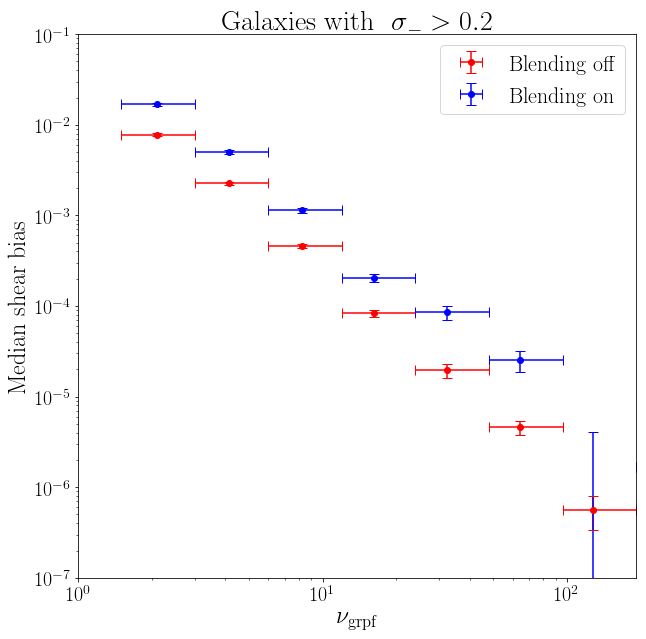

In [136]:

# plot_bias_bins(cat,snrs, 'snr_grpf', 'bias_g1', yrange=yrange, xrange=xrange, 
#               xlabel = xlabel , ylabel = ylabel, 
#               title = title, xlogscale = True, ylogscale = True, scientific = True)

plot_bias_bins_both(size_cut_cat,snrs, 'snr_grpf', yrange=yrange, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, 
              title = title, xlogscale = True, ylogscale = True, scientific = False, draw_cut_lensing=False)

### All galaxies,  snr_grpf, b(g1) blending on 

In [81]:
cat = main_catsLSST[0]

min snr, max snr: 5.4652e-06 23295.0
snrs [1, 2, 4, 8, 16, 32, 64, 128, 23295.023]
just to check that symmetry is respected print both percentiles: [ 0.00210929  0.00189368]
just to check that symmetry is respected print both percentiles: [ 0.00061188  0.00063129]
just to check that symmetry is respected print both percentiles: [ 0.0001604   0.00017682]
just to check that symmetry is respected print both percentiles: [  7.57915247e-05   5.77436551e-05]
just to check that symmetry is respected print both percentiles: [  2.50854209e-05   2.37152562e-05]
just to check that symmetry is respected print both percentiles: [  1.27898363e-05   9.87539490e-06]
just to check that symmetry is respected print both percentiles: [  5.75582999e-06   5.48496922e-06]
just to check that symmetry is respected print both percentiles: [  1.29429083e-06   9.66679124e-07]
x_errs
[array([  0.43244338,   0.76210022,   1.44711208,   2.8150177 ,
         5.51881409,  10.96547699,  21.40054321,  91.41975403]), arr

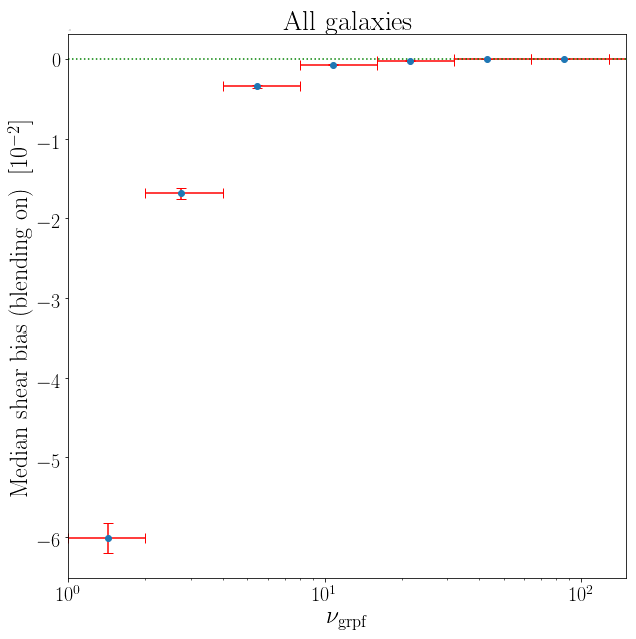

In [84]:
snrs = [2**i for i in range(0,8)]

snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias (blending on)} $\\; [10^{-2}]$"
title = '\\rm{All galaxies}' 


xrange = [1,150]
yrange = [-1.7e-3,.125e-3]

plot_snr_bias(cat,'bias_g1_grp',snrs, 'snr_grpf',yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, xlogscale = True, scientific = 'yes')

### All galaxies,  purity, b(g1) blending off 

In [222]:
cat = main_catsLSST[8]

puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias$\\; [10^{-2}]$"
title = '\\rm{All galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

min purity, max purity: 4.45327e-05 1.0
bins [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [ 0.00123717  0.00139597]
just to check that symmetry is respected print both percentiles: [ 0.00079138  0.00088536]
just to check that symmetry is respected print both percentiles: [ 0.00053984  0.00050361]
just to check that symmetry is respected print both percentiles: [ 0.00024854  0.00025661]
just to check that symmetry is respected print both percentiles: [  1.14900339e-05   1.16910099e-05]
just to check that symmetry is respected print both percentiles: [ 0.00470954  0.0059257 ]
just to check that symmetry is respected print both percentiles: [ 0.00254858  0.00291949]
just to check that symmetry is respected print both percentiles: [ 0.00165589  0.00146593]
just to check that symmetry is respected print both percentiles: [ 0.00062135  0.00060794]
just to check that symmetry is respected print both percentiles: [  2.54894188e-05   2.4407687

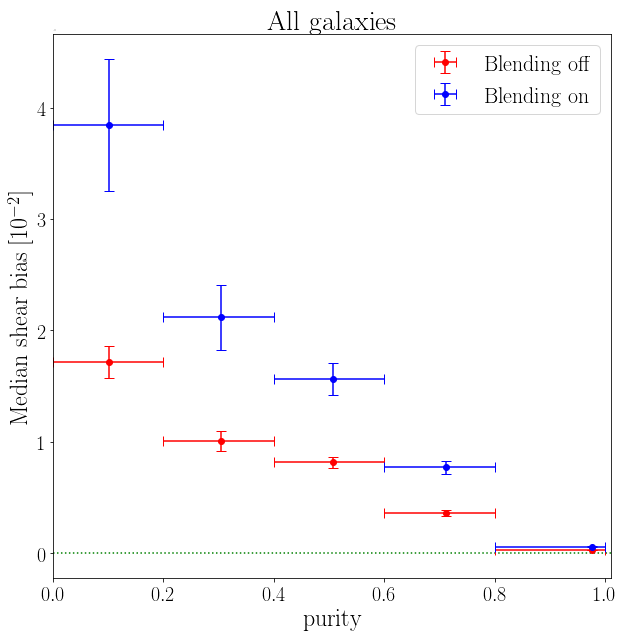

In [223]:
plot_bias_bins_both(cat,puritys, 'purity', yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, 
              title = title, xlogscale = False, ylogscale = False, scientific = 'yes')

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [ 0.00147856  0.0011536 ]
just to check that symmetry is respected print both percentiles: [ 0.00094355  0.00092084]
just to check that symmetry is respected print both percentiles: [ 0.00058348  0.0005522 ]
just to check that symmetry is respected print both percentiles: [ 0.000256    0.00026757]
just to check that symmetry is respected print both percentiles: [  1.21724932e-05   1.34366844e-05]
x_errs
[array([ 0.10215101,  0.10360296,  0.10732958,  0.11215034,  0.17589207]), array([ 0.09784899,  0.09639704,  0.09267042,  0.08784966,  0.02410793])]

y_errs
[0.0011536037176847445, 0.00092084426432847977, 0.00055219745263457298, 0.00026757456362247467, 1.3436684384942081e-05]

x
[ 0.10215101  0.30360296  0.50732958  0.71215034  0.97589207]

y
[-0.01544478 -0.01181173 -0.00682445 -0.0042707  -0.00027423]



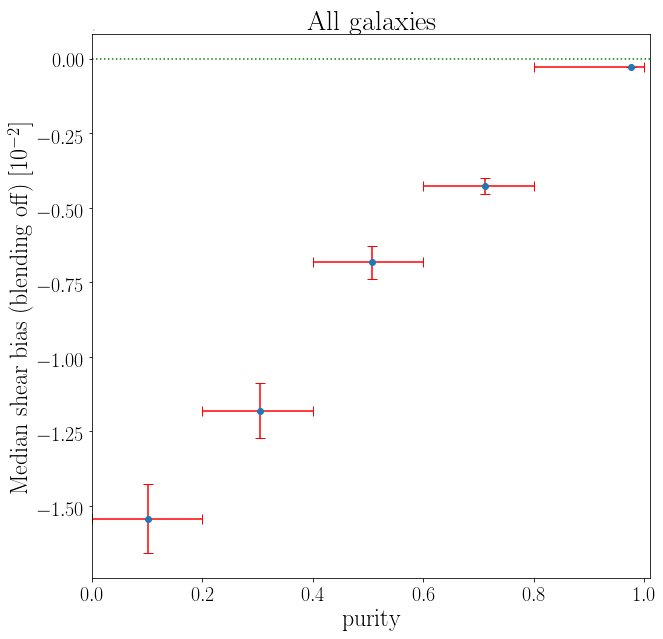

In [74]:
plot_purity_bias(cat,'bias_g1',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes' )

### All galaxies with purity and b(g1) with blending on 

In [78]:
cat = main_catsLSST[0]

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [ 0.00504006  0.00440053]
just to check that symmetry is respected print both percentiles: [ 0.00214185  0.00219999]
just to check that symmetry is respected print both percentiles: [ 0.00176817  0.00125005]
just to check that symmetry is respected print both percentiles: [ 0.0006724   0.00074399]
just to check that symmetry is respected print both percentiles: [  2.69572390e-05   2.31773593e-05]
x_errs
[array([ 0.10215101,  0.10360296,  0.10732958,  0.11215034,  0.17589207]), array([ 0.09784899,  0.09639704,  0.09267042,  0.08784966,  0.02410793])]

y_errs
[0.0044005322456359859, 0.0021999925374984741, 0.0012500499561429006, 0.00074399495497345924, 2.3177359253168106e-05]

x
[ 0.10215101  0.30360296  0.50732958  0.71215034  0.97589207]

y
[-0.03319016 -0.01881462 -0.0132123  -0.0085209  -0.0005782 ]



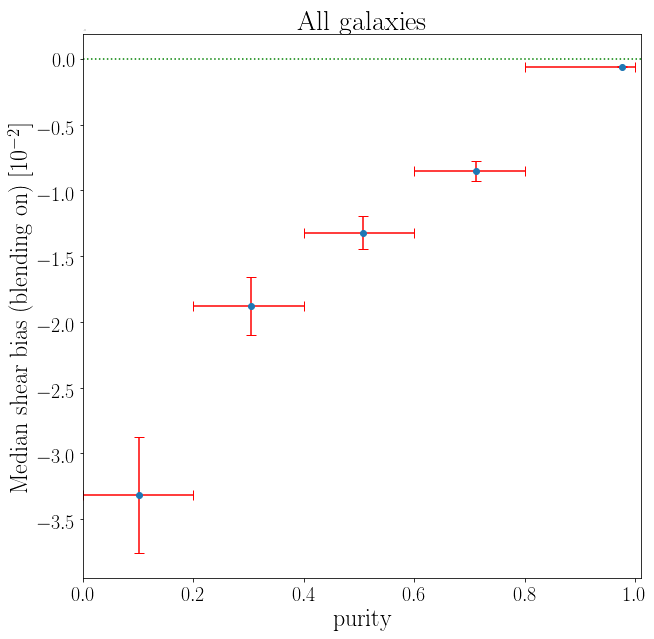

In [80]:
puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias (blending on)}$\\; [10^{-2}]$"
title = '\\rm{All galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_purity_bias(cat,'bias_g1_grp',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes' )

### Lensing galaxies with snr and b(g1) with blending off 

In [59]:
cat = good(main_catsLSST[8]) 

In [60]:
snrs = [2**i for i in range(0,8)]

snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias}"
title = '\\rm{Lensing sample galaxies}' 


xrange = [4,128]
yrange = [5e-8,2.5e-3]

min snr_grpf, max snr_grpf: 6.00009 23278.7
bins [1, 2, 4, 8, 16, 32, 64, 128, 23278.695]
just to check that symmetry is respected print both percentiles: [  6.11420255e-05   7.73174688e-05]
just to check that symmetry is respected print both percentiles: [  1.45108643e-05   2.04720272e-05]
just to check that symmetry is respected print both percentiles: [  3.83990846e-06   4.58554714e-06]
just to check that symmetry is respected print both percentiles: [  1.78049595e-06   2.25296666e-06]
just to check that symmetry is respected print both percentiles: [  4.62329922e-07   9.08472402e-07]
just to check that symmetry is respected print both percentiles: [  1.66626049e-08   2.29973261e-08]
just to check that symmetry is respected print both percentiles: [ 0.00018785  0.00013315]
just to check that symmetry is respected print both percentiles: [  5.54745202e-05   5.61851193e-05]
just to check that symmetry is respected print both percentiles: [  2.26798258e-05   2.53448816e-05]
just to che

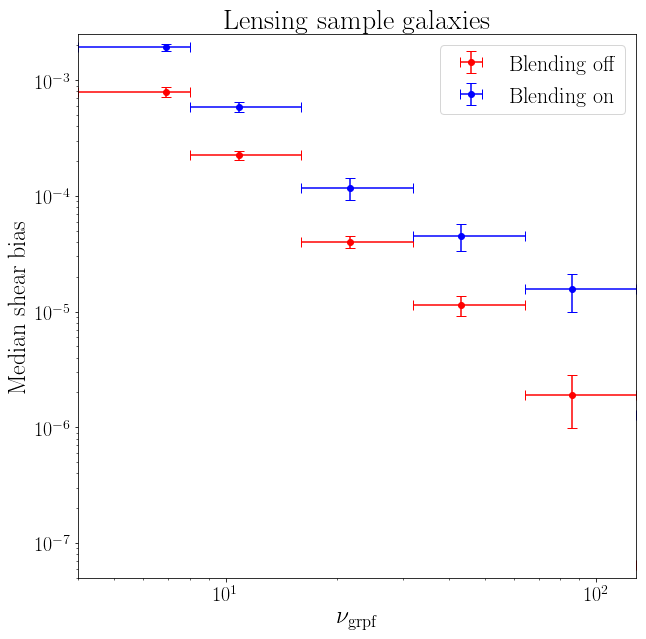

In [61]:
plot_bias_bins_both(cat,snrs, 'snr_grpf', yrange=yrange, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, 
              title = title, xlogscale = True, ylogscale = True, scientific = False)

min snr, max snr: 6.00003 23295.0
snrs [1, 2, 4, 8, 16, 32, 64, 128, 23295.023]
just to check that symmetry is respected print both percentiles: [  7.78111746e-05   5.12172701e-05]
just to check that symmetry is respected print both percentiles: [  1.31372071e-05   1.51605927e-05]
just to check that symmetry is respected print both percentiles: [  5.36242078e-06   4.97627669e-06]
just to check that symmetry is respected print both percentiles: [  1.40354678e-06   1.46509592e-06]
just to check that symmetry is respected print both percentiles: [  5.06555239e-07   4.36843038e-07]
just to check that symmetry is respected print both percentiles: [  2.82078929e-08   1.26716486e-08]
x_errs
[array([  2.88327503,   2.89264202,   5.69487953,  11.24094772,
        21.90185547,  94.50102234]), array([  1.11672497e+00,   5.10735798e+00,   1.03051205e+01,
         2.07590523e+01,   4.20981445e+01,   2.30725215e+04])]

y_errs
[5.1217270083725452e-05, 1.516059273853898e-05, 4.9762766866479053e-06, 1.

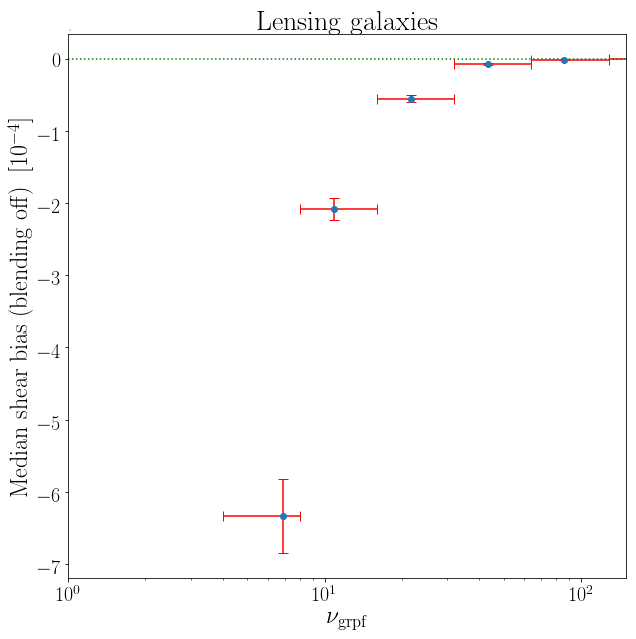

In [139]:
plot_snr_bias(cat,'bias_g1',snrs, 'snr_grpf',yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, xlogscale = True, scientific = True)

### Lensing galaxies with snr and b(g1) with blending on

In [140]:
cat = good(main_catsLSST[0]) 

min snr, max snr: 6.00003 23295.0
snrs [1, 2, 4, 8, 16, 32, 64, 128, 23295.023]
just to check that symmetry is respected print both percentiles: [ 0.00017867  0.00017562]
just to check that symmetry is respected print both percentiles: [  4.19829879e-05   5.85920364e-05]
just to check that symmetry is respected print both percentiles: [  2.04431562e-05   2.34591134e-05]
just to check that symmetry is respected print both percentiles: [  8.29673605e-06   1.15907314e-05]
just to check that symmetry is respected print both percentiles: [  4.80599192e-06   6.42268856e-06]
just to check that symmetry is respected print both percentiles: [  1.19612681e-06   9.57433031e-07]
x_errs
[array([  2.88327503,   2.89264202,   5.69487953,  11.24094772,
        21.90185547,  94.50102234]), array([  1.11672497e+00,   5.10735798e+00,   1.03051205e+01,
         2.07590523e+01,   4.20981445e+01,   2.30725215e+04])]

y_errs
[0.00017562007997184992, 5.8592036366462681e-05, 2.3459113435819745e-05, 1.159073144

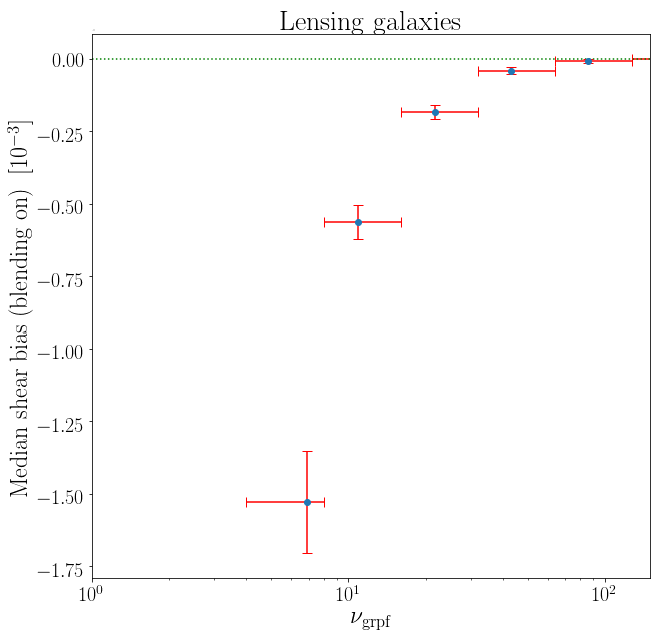

In [141]:
snrs = [2**i for i in range(0,8)]

snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias (blending on)} \\; [10^{-3}]$ "
title = '\\rm{Lensing galaxies}' 


xrange = [1,150]
yrange = [-1.7e-3,.125e-3]

plot_snr_bias(cat,'bias_g1_grp',snrs, 'snr_grpf',yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, xlogscale = True, scientific = 'yes')

### Lensing galaxies with purity and b(g1) with blending off

min purity, max purity: 0.00689361 1.0
bins [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [  1.07185831e-04   4.03359591e-05]
just to check that symmetry is respected print both percentiles: [  2.97250663e-05   3.19692917e-05]
just to check that symmetry is respected print both percentiles: [  1.47255123e-05   2.59657609e-05]
just to check that symmetry is respected print both percentiles: [  8.86968337e-06   1.06508266e-05]
just to check that symmetry is respected print both percentiles: [  1.21827292e-06   1.23979669e-06]
just to check that symmetry is respected print both percentiles: [ 0.00020905  0.00024574]
just to check that symmetry is respected print both percentiles: [ 0.00018013  0.00012725]
just to check that symmetry is respected print both percentiles: [ 0.00017711  0.00017439]
just to check that symmetry is respected print both percentiles: [  6.85139967e-05   7.90493505e-05]
just to check that symmetry is respected prin

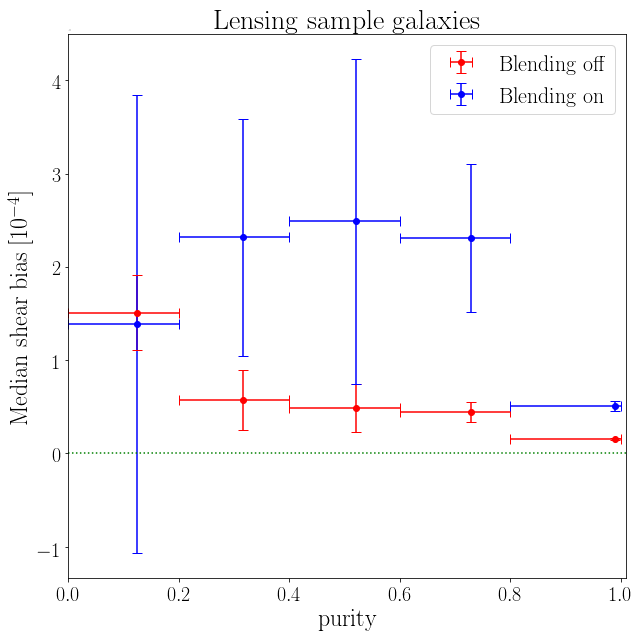

In [225]:
cat = good(main_catsLSST[8]) 

puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias}$\\; [10^{-4}]$"
title = '\\rm{Lensing sample galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_bias_bins_both(cat,puritys, 'purity', yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, 
              title = title, xlogscale = False, ylogscale = False, scientific = 'yes')

In [142]:
cat = good(main_catsLSST[0]) 

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [  5.36175942e-05   2.69348600e-05]
just to check that symmetry is respected print both percentiles: [  3.78533441e-05   3.61620914e-05]
just to check that symmetry is respected print both percentiles: [  1.78094160e-05   1.31290690e-05]
just to check that symmetry is respected print both percentiles: [  1.38273354e-05   1.01935839e-05]
just to check that symmetry is respected print both percentiles: [  1.27273135e-06   1.15440162e-06]
x_errs
[array([ 0.12541926,  0.11717843,  0.12092934,  0.12948539,  0.19045879]), array([ 0.07458074,  0.08282157,  0.07907066,  0.07051461,  0.00954121])]

y_errs
[2.6934859988614335e-05, 3.6162091419100761e-05, 1.3129068975104019e-05, 1.0193583875661716e-05, 1.1544016160769388e-06]

x
[ 0.12541926  0.31717843  0.52092934  0.72948539  0.99045879]

y
[ -3.36879361e-06  -6.63454848e-05  -3.23517161e-05  -3.58757025e-05
  -1.26752475e-05]



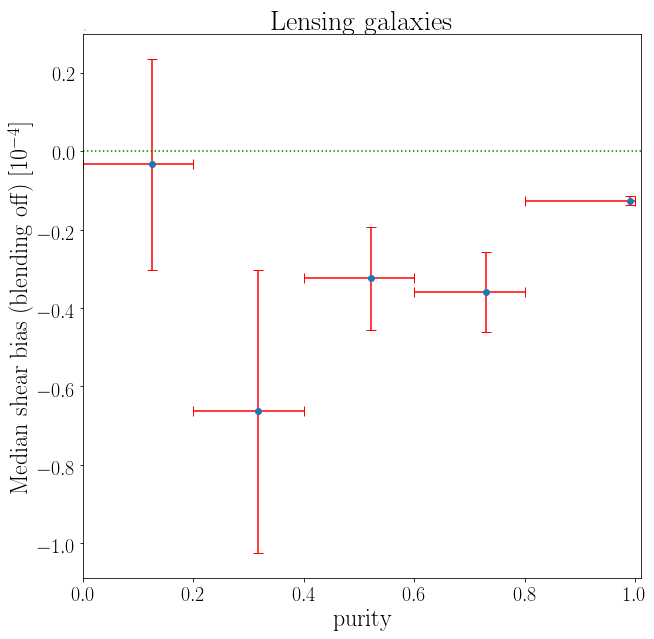

In [143]:
puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias (blending off)}$\\; [10^{-4}]$"
title = '\\rm{Lensing galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_purity_bias(cat,'bias_g1',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes')

### Lensing galaxies with purity and b(g1) with blending on

In [144]:
cat = good(main_catsLSST[0]) 

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [ 0.00050402  0.00012428]
just to check that symmetry is respected print both percentiles: [ 0.00023426  0.00016121]
just to check that symmetry is respected print both percentiles: [  9.78486886e-05   1.11837023e-04]
just to check that symmetry is respected print both percentiles: [  7.27666338e-05   6.68714783e-05]
just to check that symmetry is respected print both percentiles: [  5.34614082e-06   4.24047044e-06]
x_errs
[array([ 0.12541926,  0.11717843,  0.12092934,  0.12948539,  0.19045879]), array([ 0.07458074,  0.08282157,  0.07907066,  0.07051461,  0.00954121])]

y_errs
[0.0001242753496626392, 0.00016121308726724237, 0.00011183702343259931, 6.6871478338725865e-05, 4.2404704436194173e-06]

x
[ 0.12541926  0.31717843  0.52092934  0.72948539  0.99045879]

y
[ -1.99865754e-04  -1.95148474e-04  -1.37255498e-04  -1.54249763e-04
  -5.12655970e-05]



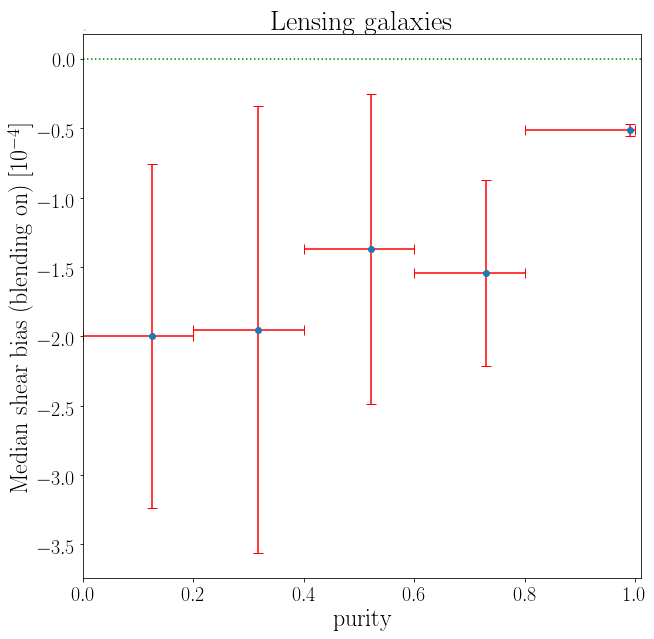

In [145]:
puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias (blending on)}$\\; [10^{-4}]$"
title = '\\rm{Lensing galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_purity_bias(cat,'bias_g1_grp',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes')

### Gold galaxies with snr and b(g1) with blending off

In [88]:
cat = gold(main_catsLSST[0]) 

min snr, max snr: 0.0219983 23295.0
snrs [1, 2, 4, 8, 16, 32, 64, 128, 23295.023]
just to check that symmetry is respected print both percentiles: [ 0.00013237  0.00010601]
just to check that symmetry is respected print both percentiles: [  4.87550721e-05   4.17183375e-05]
just to check that symmetry is respected print both percentiles: [  1.87591568e-05   2.37338536e-05]
just to check that symmetry is respected print both percentiles: [  1.44534279e-05   1.23369246e-05]
just to check that symmetry is respected print both percentiles: [  6.39534846e-06   6.47999404e-06]
just to check that symmetry is respected print both percentiles: [  1.43522942e-06   1.33559462e-06]
just to check that symmetry is respected print both percentiles: [  6.92108642e-07   5.57362882e-07]
just to check that symmetry is respected print both percentiles: [  2.63853188e-08   1.40802534e-08]
x_errs
[array([  0.5480895 ,   1.00194907,   2.07930088,   3.68947792,
         5.51881409,  10.96547699,  21.40054321, 

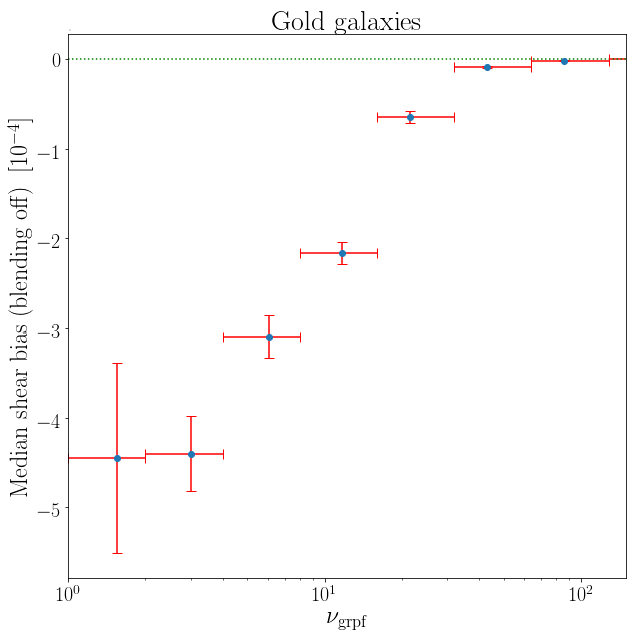

In [91]:
snrs = [2**i for i in range(0,8)]

snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias (blending off)} $\\; [10^{-4}]$ "
title = '\\rm{Gold galaxies}' 


xrange = [1,150]
yrange = [-1.7e-3,.125e-3]

plot_snr_bias(cat,'bias_g1',snrs, 'snr_grpf',yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, xlogscale = True, scientific = 'yes')

### Gold galaxies with snr and b(g1) with blending on

In [94]:
cat = gold(main_catsLSST[0]) 

min snr, max snr: 0.0219983 23295.0
snrs [1, 2, 4, 8, 16, 32, 64, 128, 23295.023]
just to check that symmetry is respected print both percentiles: [ 0.00265939  0.00193684]
just to check that symmetry is respected print both percentiles: [ 0.00073122  0.00065761]
just to check that symmetry is respected print both percentiles: [  1.26204046e-04   9.94016882e-05]
just to check that symmetry is respected print both percentiles: [  4.28670482e-05   5.87429386e-05]
just to check that symmetry is respected print both percentiles: [  2.89450696e-05   2.49480561e-05]
just to check that symmetry is respected print both percentiles: [  1.28336399e-05   9.92770219e-06]
just to check that symmetry is respected print both percentiles: [  5.62591333e-06   5.39984603e-06]
just to check that symmetry is respected print both percentiles: [  1.19638823e-06   9.15308476e-07]
x_errs
[array([  0.5480895 ,   1.00194907,   2.07930088,   3.68947792,
         5.51881409,  10.96547699,  21.40054321,  91.419754

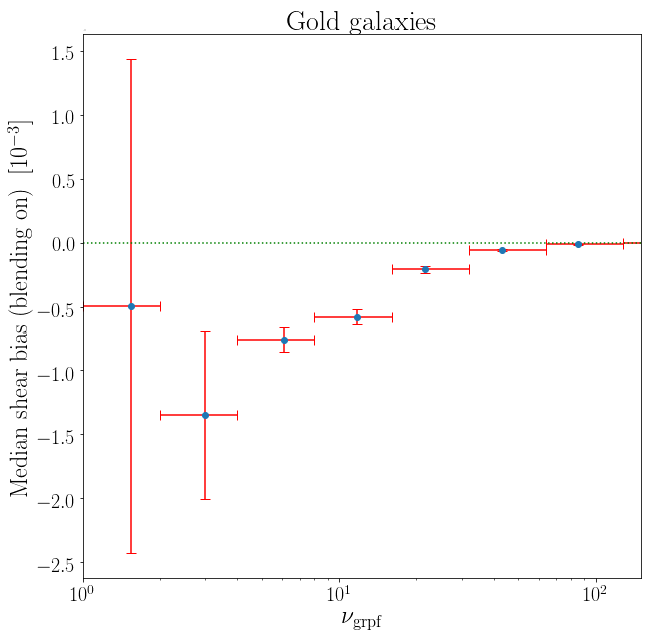

In [95]:
snrs = [2**i for i in range(0,8)]

snrs.append(np.max(cat['snr_grpf']))

xlabel= "$\\nu_{\\rm{grpf}}$"
ylabel= "\\rm{Median shear bias (blending on)} $\\; [10^{-3}]$ "
title = '\\rm{Gold galaxies}' 


xrange = [1,150]
yrange = [-1.7e-3,.125e-3]

plot_snr_bias(cat,'bias_g1_grp',snrs, 'snr_grpf',yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, xlogscale = True, scientific = 'yes')

### Gold galaxies with purity and b(g1) with blending off

In [96]:
cat = gold(main_catsLSST[0]) 

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [  8.17271939e-05   3.91252688e-05]
just to check that symmetry is respected print both percentiles: [  4.33393725e-05   3.43482825e-05]
just to check that symmetry is respected print both percentiles: [  3.02417640e-05   2.49363403e-05]
just to check that symmetry is respected print both percentiles: [  1.79403214e-05   1.99753558e-05]
just to check that symmetry is respected print both percentiles: [  1.46655111e-06   1.51005494e-06]
x_errs
[array([ 0.11756926,  0.11153196,  0.11636529,  0.12306752,  0.1872719 ]), array([ 0.08243074,  0.08846804,  0.08363471,  0.07693248,  0.0127281 ])]

y_errs
[3.9125268813222647e-05, 3.4348282497376204e-05, 2.4936340341810134e-05, 1.9975355826318264e-05, 1.5100549353519463e-06]

x
[ 0.11756926  0.31153196  0.51636529  0.72306752  0.9872719 ]

y
[ -1.26809158e-04  -1.46562525e-04  -1.26841987e-04  -1.15462877e-04
  -1.68014139e-05]



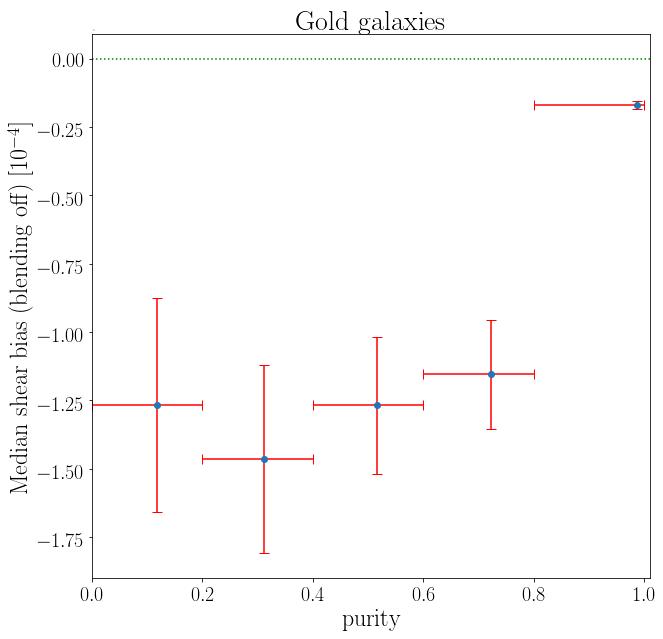

In [98]:
puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias (blending off)}$\\; [10^{-4}]$"
title = '\\rm{Gold galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_purity_bias(cat,'bias_g1',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes')

### Gold galaxies with purity and b(g1) with blending on

In [146]:
cat = gold(main_catsLSST[0]) 

puritys [ 0.   0.2  0.4  0.6  0.8  1. ]
just to check that symmetry is respected print both percentiles: [ 0.0003829   0.00037386]
just to check that symmetry is respected print both percentiles: [ 0.00022849  0.00020655]
just to check that symmetry is respected print both percentiles: [ 0.00015243  0.00016217]
just to check that symmetry is respected print both percentiles: [  9.31630639e-05   8.27730837e-05]
just to check that symmetry is respected print both percentiles: [  5.43790884e-06   5.51766061e-06]
x_errs
[array([ 0.11756926,  0.11153196,  0.11636529,  0.12306752,  0.1872719 ]), array([ 0.08243074,  0.08846804,  0.08363471,  0.07693248,  0.0127281 ])]

y_errs
[0.00037385693576652557, 0.00020655046682804823, 0.00016217380471061915, 8.2773083704523742e-05, 5.5176606110762805e-06]

x
[ 0.11756926  0.31153196  0.51636529  0.72306752  0.9872719 ]

y
[ -4.05376079e-04  -2.69684533e-04  -2.76547507e-04  -1.70151368e-04
  -5.52370439e-05]



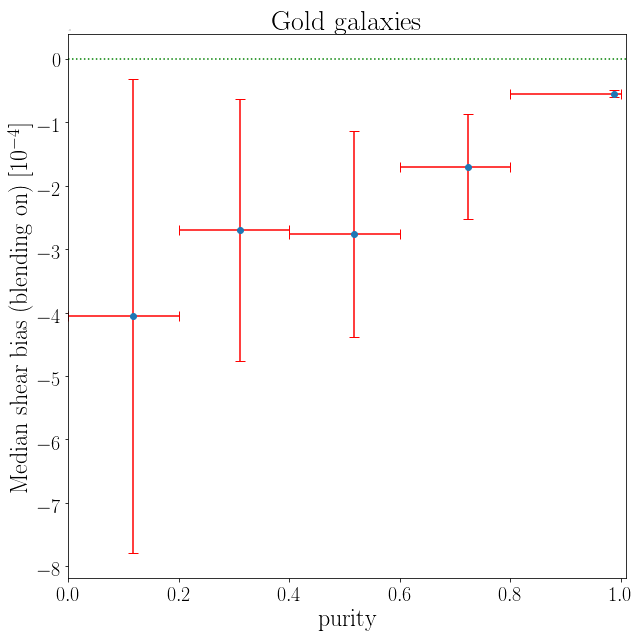

In [147]:
puritys = np.linspace(0, 1. , 6 )

xlabel= "\\rm{purity}"
ylabel= "\\rm{Median shear bias (blending on)}$\\; [10^{-4}]$"
title = '\\rm{Gold galaxies}' 


xrange = (0,1.01 )
yrange = [-1.7e-3,.125e-3]

plot_purity_bias(cat,'bias_g1_grp',puritys,yrange=None, xrange=xrange, 
              xlabel = xlabel , ylabel = ylabel, title = title, scientific = 'yes')

# Misc. 

(array([   9990.,   13228.,   19319.,   32734.,  191091.,  191815.,
          32620.,   19113.,   13331.,   10268.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

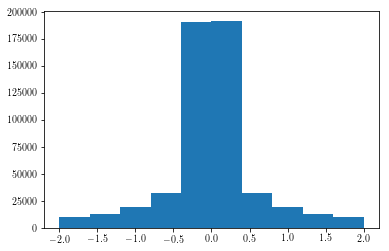

In [30]:
plt.hist(main_catsLSST[4]['bias_g1_grp'],range=(-2,2))

In [34]:
cat = good(best(main_catsLSST[4]))
len(cat[cat['bias_g1_grp'] > 2])

56

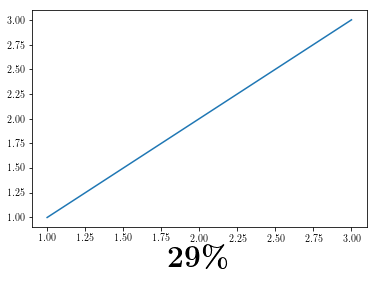

In [70]:
fig = plt.figure() 
plt.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


plt.xlabel(r'$\boldsymbol{29\%}$',size=30,)
# plt.ylabel(r'$x$',size=30)


plt.plot([1,2,3],[1,2,3])

In [44]:
main_catsLSST['bias_g1_grp']

TypeError: list indices must be integers, not str

In [27]:
np.max(abs_cut(best(good(main_catsLSST[4])),'bias_g1_grp',1.5)['bias_g1'])

1.4622716

In [34]:
x = np.array([1,2,3,4,5,6])
y = np.array([2,4,6,8,10,12])
errs = np.array([0.001,0.001,0.001,0.001,0.001,0.001]) 

## Sample optimization routine using chi-sq with arguments. 

In [35]:
def chisqfunc((a, b),data_x,data_y,data_err):
    model = a + b*data_x
    chisq = numpy.sum(((data_y - model)/data_err)**2)
    return chisq


In [36]:
x0 = np.array([0,0])
results = opt.minimize(chisqfunc, x0,args=(x,y,errs))
print results
assert results.success==True
a,b=results.x
print a,b

      fun: 1.5876204200953132e-08
 hess_inv: array([[  4.33333001e-07,  -9.99999224e-08],
       [ -9.99999224e-08,   2.85714105e-08]])
      jac: array([  1.66089365e-07,   3.81916723e-08])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([  9.68576164e-08,   1.99999997e+00])
9.68576163793e-08 1.9999999702


## By how much fraction of galaxies passing criteria for lensing sample change 

In [43]:
print len(main_catsLSST)

9


In [47]:
print len(best(good(main_catsLSST[4])))
print len(best(good(main_catsLSST[8])))

print 1 - float(len(best(good(main_catsLSST[8]))))/len(best(good(main_catsLSST[4])))

105015
104948
0.000638004094653


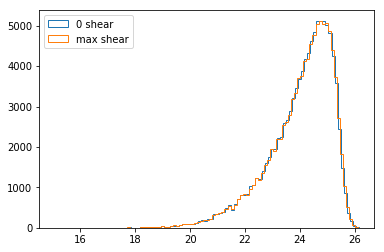

In [22]:
## also compare distribtuions of mag_AB, first just plot it

plt.hist(best(good(main_catsLSST[4]))['ab_mag'], bins=100,histtype='step',label='0 shear')
plt.hist(best(good(main_catsLSST[8]))['ab_mag'], bins=100,histtype='step',label='max shear')

plt.legend(loc=2) 



## SNR binning of isolated galaxies to potentially compare to other papers 

In [19]:
from scipy import stats

In [20]:
cat = main_catsLSST[4]
# isolated_cat = iso_gal(cat)

(array([ 106863.,   81498.,   38954.,   23225.,   16105.,   11873.,
           9132.,    7062.,    5835.,    4886.,    4204.,    3666.,
           3059.,    2727.,    2487.,    2214.,    1907.,    1808.,
           1646.,    1416.,    1326.,    1271.,    1121.,    1032.,
           1037.,     952.,     842.,     800.,     791.,     708.,
            703.,     607.,     601.,     537.,     533.,     521.,
            504.,     433.,     439.,     422.,     429.,     410.,
            397.,     332.,     334.,     311.,     319.,     306.,
            280.,     272.]),
 array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
          18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
          36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
          54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
          72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
          90.,   92.,   94.,   96.,   98.,  100.]),
 <a list of 50 Patc

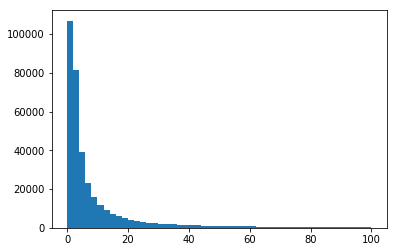

In [40]:
#histogram of snr_grpf 
plt.hist(isolated_cat['snr_grpf'],bins=50,range=(0,100))

(array([   2945.,    3960.,    5868.,   11168.,  123165.,  123229.,
          11197.,    5961.,    3964.,    2917.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 10 Patch objects>)

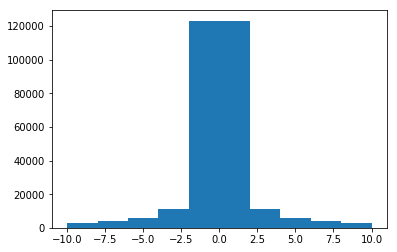

In [66]:
plt.hist(isolated_cat['bias_g1_grp'],range=(-10,10))

       None      
-----------------
6.96316556059e-06
    1.50247023582
    2.71888346672
    5.32816034317
    14.2985467148
    23287.1914062


(array([ 72192.,  72193.,  72192.,  72193.,  72192.]),
 array([  6.96316556e-06,   1.50247024e+00,   2.71888347e+00,
          5.32816034e+00,   1.42985467e+01,   2.32871914e+04]),
 <a list of 5 Patch objects>)

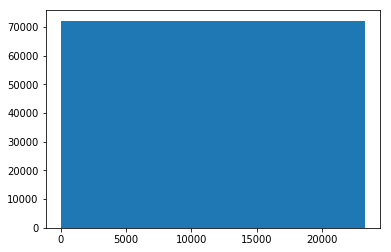

In [30]:
#cumulative snr vs galaxies to get approximately same number of galaxies per bin 
#divided number of objects into equal bins using the mquantiles fnc. 
bin_edges = stats.mstats.mquantiles(isolated_cat['snr_grpf'], [0, 1./5,2./5,3./5,4./5, 1])
print bin_edges 

plt.figure()
plt.hist(isolated_cat['snr_grpf'],bins=bin_edges)

In [ ]:
#can set it for example to have same size bins 
bins = 10 
snrs = np.linspace(10,100, bins)

In [68]:
np.round(bin_edges)

0.0
2.0
3.0
5.0
14.0
23287.0


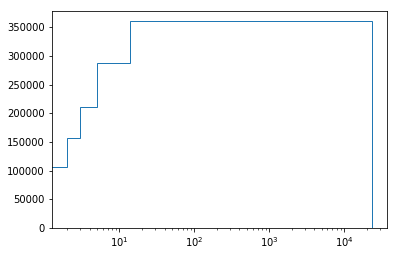

In [52]:
plt.figure()
plt.hist(isolated_cat['snr_grpf'],bins=np.round(bin_edges[:6]),histtype='step',cumulative=True)
plt.xscale('log')

In [21]:
np.min(isolated_cat['snr_grpf'])

6.9631656e-06

In [21]:
def plot_snr_bias(cat,title,param, snrs,snr_type,y_range=None,ls=None,x_range=None): 
    plt.figure()
    snr_min,snr_max = np.min(cat[snr_type]), np.max(cat[snr_type])
    print 'min snr, max snr:', (snr_min, snr_max)
    #bins = 10 
    #snrs = np.linspace(10,100, bins)
    x = []
    y = []
    errs_x1 = []
    errs_x2 = []
    #errs_y = [] 
    
    small_cats = [] 
    
    print 'snrs', snrs 
    for i in range(len(snrs)-1):
        small_cat = down_cut(up_cut(cat,snr_type,snrs[i]),snr_type,snrs[i+1])
        small_cats.append(small_cat) 
        
        median_snr = np.median(small_cat[snr_type])
        small_param = np.median(small_cat[param])
        
        #want 'error bars on x' showing the extent of the bin widths
        errs_x1.append(np.absolute(snrs[i] - median_snr))
        errs_x2.append(np.absolute(snrs[i+1] - median_snr))
        
        #print the error for this param, we want all of them to be the same 
        
        #err_y.append(np.std(abs_cut(small_cat,param,10)[param]))
        x.append(median_snr)
        y.append(small_param)
#         errs_x.append(err_x)

#     print 'y: {} '.format(y)
#     print
#     print 'err_y: {} '.format(err_y)
    
    # put the errors into a list 
    x_errs = [np.array(errs_x1),np.array(errs_x2)]
    #x_errs[1][-1] = 29.94817734 #make the last one symmetric to avoid running off plot 
    x = np.array(x)
    y = np.array(y)
    
    #get y errs, this are the error in the median shear bias calculated 
    y_errs = errs_param_boot(small_cats,param, np.median,N=1000)
        
    print 'x_errs'
    print x_errs 
    print 
    print 'y_errs'
    print y_errs 
    print 
        

    
    f = plt.figure(figsize=(12,12)) 
    ax = f.add_subplot(111)
    #ax.set_yscale('log')
    if y_range: 
        ax.set_ylim(y_range)
    if x_range: 
        ax.set_xlim(x_range)
        
        
    #ax.set_xscale('log')
    ax.set_title(title)
    
    plt.tick_params(axis='both', which='major', labelsize=20)

    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.offsetText.set_fontsize(15)
    
    plt.axhline(y=0.0, color='g', linestyle=':')    
    
    print 'x'
    print x
    print
    print 'y'
    print y
    print
#     print'errs_x'
#     print errs_x
    if ls: 
        ax.errorbar(x,y,xerr=x_errs,marker='o',ls=ls,ecolor='r',capsize=5)
    else: 
        ax.errorbar(x,y,xerr=x_errs,yerr=y_errs,fmt='o',capsize=5,ecolor='r')

In [22]:
snrs = [2**i for i in range(-1,6)]
snrs.append(np.max(cat['snr_grpf']))
print snrs 

[0.5, 1, 2, 4, 8, 16, 32, 23287.191]


min snr, max snr: (3.5526139e-06, 23287.191)
snrs [0.5, 1, 2, 4, 8, 16, 32, 23287.191]
just to check that symmetry is respected print both percentiles: [ 0.00060562  0.00056305]
just to check that symmetry is respected print both percentiles: [ 0.00019604  0.00016429]
just to check that symmetry is respected print both percentiles: [  5.80936827e-05   8.48946860e-05]
just to check that symmetry is respected print both percentiles: [  2.37279710e-05   2.94384267e-05]
just to check that symmetry is respected print both percentiles: [  5.23013449e-06   8.85335163e-06]
just to check that symmetry is respected print both percentiles: [  3.06109223e-06   1.97372907e-06]
just to check that symmetry is respected print both percentiles: [  2.00637327e-08   4.21605120e-08]
x_errs
[array([  0.26511973,   0.43272519,   0.76242924,   1.44650698,
         2.8153019 ,   5.51130295,  29.94817734]), array([  0.23488027,   0.56727481,   1.23757076,   2.55349302,
         5.1846981 ,  10.48869705,  29.94

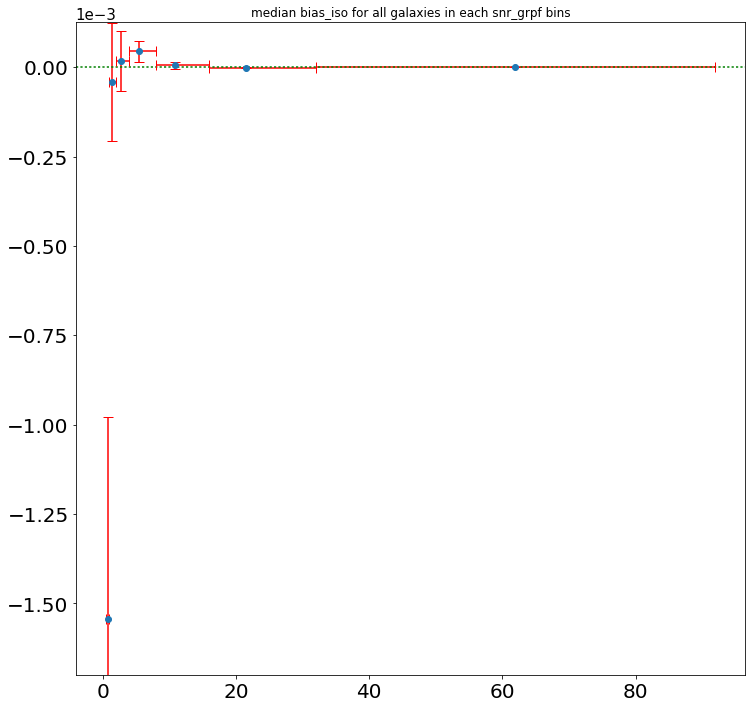

In [42]:
title = 'median bias_iso for all galaxies in each snr_grpf bins'
plot_snr_bias(cat,title,'bias_g1',snrs, 'snr_grpf',y_range=[-1.7e-3,.125e-3],ls=None,x_range=[0,100])

In [35]:
snrs
list(np.array(snrs)*2)

[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 46574.3828125]

min snr, max snr: (0.0, 34099.602)
snrs [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 46574.3828125]
just to check that symmetry is respected print both percentiles: [ 0.00274092  0.00251565]
just to check that symmetry is respected print both percentiles: [ 0.0006336   0.00053816]
just to check that symmetry is respected print both percentiles: [ 0.0001646   0.00012545]
just to check that symmetry is respected print both percentiles: [  3.76127436e-05   3.09722263e-05]
just to check that symmetry is respected print both percentiles: [  9.88938874e-06   1.03070873e-05]
just to check that symmetry is respected print both percentiles: [  3.48226444e-06   4.71078465e-06]
just to check that symmetry is respected print both percentiles: [  1.60482980e-08   2.42930016e-08]
x_errs
[array([  0.61036634,   0.83168602,   1.47581244,   2.88019753,
         5.61940384,  11.11577225,  61.46243286]), array([  3.89633656e-01,   1.16831398e+00,   2.52418756e+00,
         5.11980247e+00,   1.03805962e+01,   2

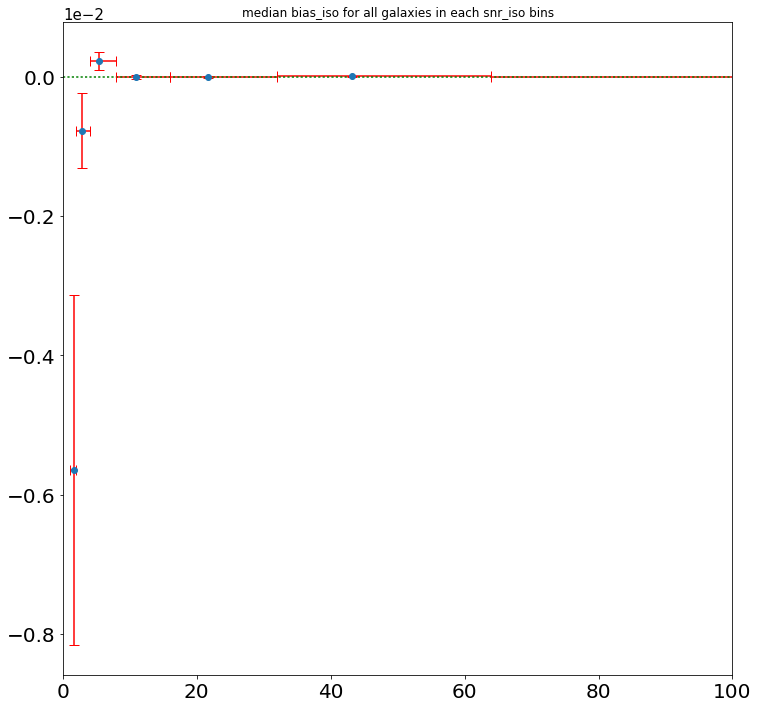

In [36]:
title = 'median bias_iso for all galaxies in each snr_iso bins'
plot_snr_bias(cat,title,'bias_g1',list(np.array(snrs)*2), 'snr_iso',x_range=[0,100])

min snr, max snr: (0.0, 33289.281)
snrs [0.5, 1, 2, 4, 8, 16, 32, 23287.191]
just to check that symmetry is respected print both percentiles: [ 0.00235504  0.00228834]
just to check that symmetry is respected print both percentiles: [ 0.00070294  0.00059388]
just to check that symmetry is respected print both percentiles: [ 0.00016639  0.00016407]
just to check that symmetry is respected print both percentiles: [  5.04274500e-05   6.10870033e-05]
just to check that symmetry is respected print both percentiles: [  1.23981997e-05   1.22665444e-05]
just to check that symmetry is respected print both percentiles: [  4.18282008e-06   3.22900803e-06]
just to check that symmetry is respected print both percentiles: [  3.11945842e-08   5.96705523e-08]
x_errs
[array([  0.32204527,   0.45573795,   0.7799387 ,   1.45232391,
         2.85511398,   5.56610489,  30.94647598]), array([  1.77954733e-01,   5.44262052e-01,   1.22006130e+00,
         2.54767609e+00,   5.14488602e+00,   1.04338951e+01,
  

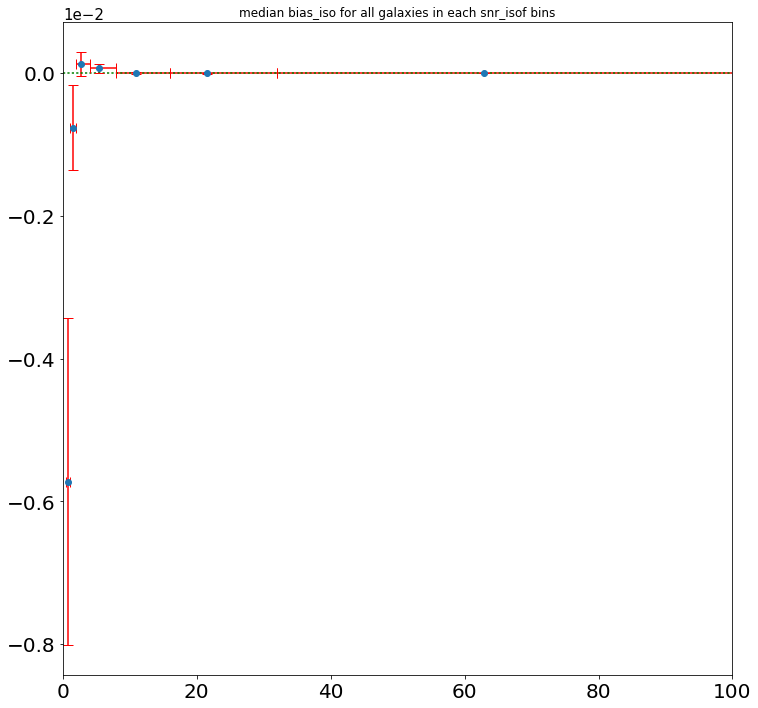

In [46]:
title = 'median bias_iso for all galaxies in each snr_isof bins'
plot_snr_bias(cat,title,'bias_g1', snrs, 'snr_isof',x_range=[0,100])

min snr, max snr: (3.5526139e-06, 23287.191)
snrs [0.05, 0.25, 0.5, 1.0, 1.5, 2, 2.5, 3, 4, 23287.191]
just to check that symmetry is respected print both percentiles: [ 0.00401216  0.00487214]
just to check that symmetry is respected print both percentiles: [ 0.00122262  0.00097295]
just to check that symmetry is respected print both percentiles: [ 0.00055592  0.00052586]
just to check that symmetry is respected print both percentiles: [ 0.00027556  0.00036563]
just to check that symmetry is respected print both percentiles: [ 0.0003541  0.000232 ]
just to check that symmetry is respected print both percentiles: [ 0.00014811  0.00017247]
just to check that symmetry is respected print both percentiles: [ 0.00016512  0.0001819 ]
just to check that symmetry is respected print both percentiles: [  8.11694138e-05   1.14603566e-04]
just to check that symmetry is respected print both percentiles: [  1.68705245e-07   3.09119202e-07]
x_errs
[array([ 0.14294539,  0.11835107,  0.26511973,  0.234

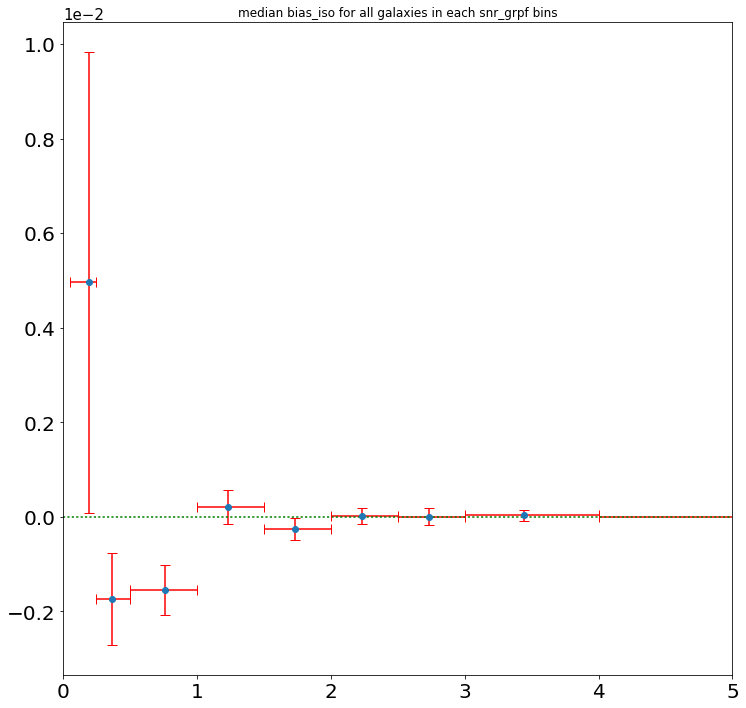

In [50]:
#let's do some finer binning to see what is happening in the very first bins 
snrs = [0.05,.25,.5,1.,1.5,2,2.5,3,4]
snrs.append(np.max(cat['snr_grpf']))
title = 'median bias_iso for all galaxies in each snr_grpf bins'
plot_snr_bias(cat,title,'bias_g1', snrs, 'snr_grpf',x_range=[0,5])


min snr, max snr: (0.0, 34099.602)
snrs [0.05, 0.25, 0.5, 1.0, 1.5, 2, 2.5, 3, 4, 23287.191]
just to check that symmetry is respected print both percentiles: [ 134.40128326  229.95523071]
just to check that symmetry is respected print both percentiles: [ 0.43938529  0.76810181]
just to check that symmetry is respected print both percentiles: [ 0.01277793  0.01383603]
just to check that symmetry is respected print both percentiles: [ 0.0059026   0.00415816]
just to check that symmetry is respected print both percentiles: [ 0.00352056  0.00288148]
just to check that symmetry is respected print both percentiles: [ 0.00203753  0.00220037]
just to check that symmetry is respected print both percentiles: [ 0.00133733  0.00130536]
just to check that symmetry is respected print both percentiles: [ 0.00059905  0.00053187]
just to check that symmetry is respected print both percentiles: [  2.21059754e-07   3.78583873e-07]
x_errs
[array([ 0.14243431,  0.13263866,  0.34341598,  0.33106506,  0.2539

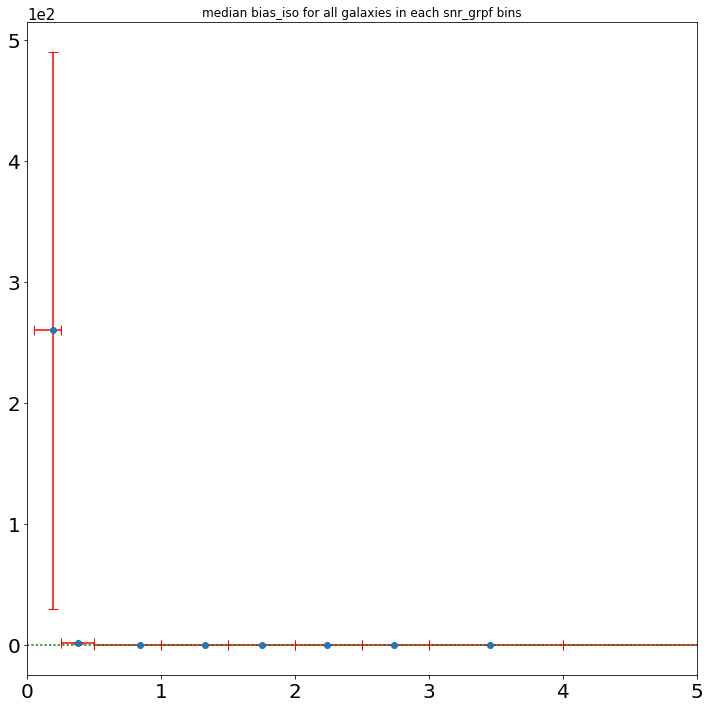

In [51]:
plot_snr_bias(cat,title,'bias_g1', snrs, 'snr_iso',x_range=[0,5])
title = 'median bias_iso for all galaxies in each snr_iso bins'

# Distribution of R2 for galaxies in the catalogue 

In [191]:
cat = main_catsLSST[4]
cat_snr_cut = up_cut(cat, 'snr_grpf', 6)

In [192]:
#get distribution of R2: 
R2s_all = 1 - (psf_sigma/ np.sqrt(cat['sigma_p']**2 + psf_sigma**2))**2 
R2s_snr_cut = 1 - (psf_sigma/ np.sqrt(cat_snr_cut['sigma_p']**2 + psf_sigma**2))**2 

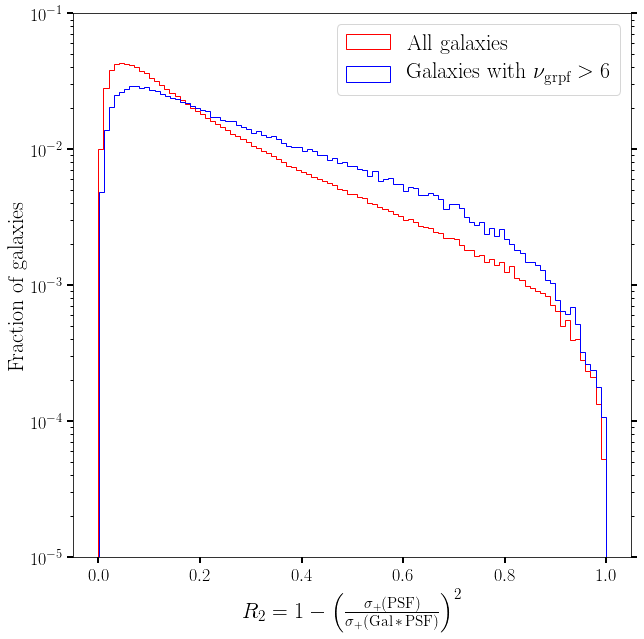

In [193]:
#fraction 
plt.rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel("$R_{2} = 1- \\left({\\sigma_{+}(\\rm{PSF}) \\over \\sigma_{+}(\\rm{Gal} \\, \\ast \\, \\rm{PSF})}\\right)^{2}$", size = 22)
ax.set_ylabel("\\rm Fraction of galaxies", size = 22)

ax.tick_params(axis='both', which='major', labelsize=18, length=6, width = 2)
ax.tick_params(axis='both', which='minor', labelsize=18, length=3, width = 1)
ax.tick_params(which= 'major', right=True)
ax.tick_params(which= 'minor', right=True)



# ax.set_xlim(g_min,g_max)
ax.set_ylim(1e-5,1e-1)

#     plt.tick_params(axis='both', which='minor',size=5)
ax.hist(R2s_all,bins=100,histtype='step',
        label='\\rm All galaxies',color='red',weights=np.ones_like(R2s_all)/len(R2s_all))

ax.hist(R2s_snr_cut,bins=100,histtype='step',
        label='\\rm Galaxies with $\\nu_{\\rm{grpf}} > 6$',color='blue',weights=np.ones_like(R2s_snr_cut)/len(R2s_snr_cut))

ax.legend(prop={'size':22})
ax.set_yscale('log')

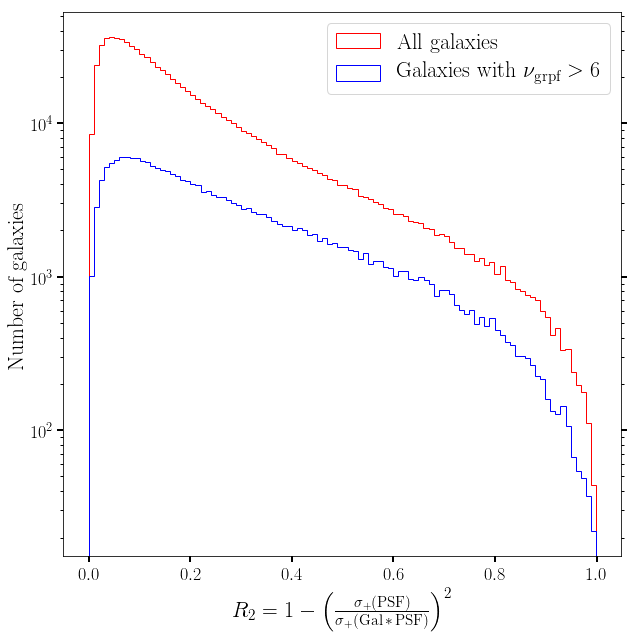

In [196]:
#number of galaxies
plt.rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel("$R_{2} = 1- \\left({\\sigma_{+}(\\rm{PSF}) \\over \\sigma_{+}(\\rm{Gal} \\, \\ast \\, \\rm{PSF})}\\right)^{2}$", size = 22)
ax.set_ylabel("\\rm Number of galaxies", size = 22)

ax.tick_params(axis='both', which='major', labelsize=18, length=6, width = 2)
ax.tick_params(axis='both', which='minor', labelsize=18, length=3, width = 1)
ax.tick_params(which= 'major', right=True)
ax.tick_params(which= 'minor', right=True)



# # ax.set_xlim(g_min,g_max)
# ax.set_ylim(1e-5,1e-1)

#     plt.tick_params(axis='both', which='minor',size=5)
ax.hist(R2s_all,bins=100,histtype='step',
        label='\\rm All galaxies',color='red')

ax.hist(R2s_snr_cut,bins=100,histtype='step',
        label='\\rm Galaxies with $\\nu_{\\rm{grpf}} > 6$',color='blue')

ax.legend(prop={'size':22})
ax.set_yscale('log')

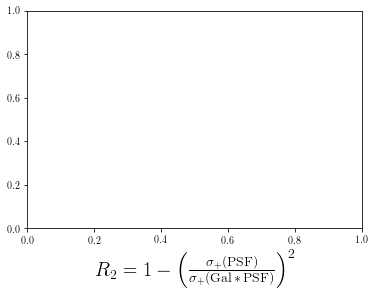

In [163]:
fig, ax = plt.subplots() 
plt.rc('text', usetex=True)
ax.set_xlabel("$R_{2} = 1- \\left({\\sigma_{+}(\\rm{PSF}) \\over \\sigma_{+}(\\rm{Gal} \\, \\ast \\, \\rm{PSF})}\\right)^{2}$", size = 20)

plt.show() 




## Other...

(0, 100)

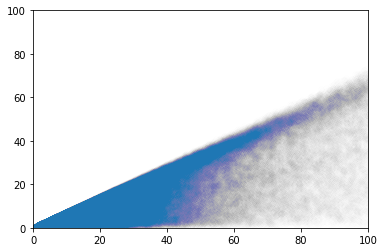

In [31]:
plt.scatter(cat['snr_iso'],cat['snr_grpf'],alpha=.005)
plt.xlim(0,100)
plt.ylim(0,100)

min snr, max snr: (3.5526139e-06, 23287.191)
snrs [0.5, 1, 2, 4, 8, 16, 32, 23287.191]
x_errs
[array([  0.26511973,   0.43272519,   0.76242924,   1.44650698,
         2.8153019 ,   5.51130295,  29.94817734]), array([  0.23488027,   0.56727481,   1.23757076,   2.55349302,
         5.1846981 ,  10.48869705,  29.94817734])]

x
[  0.76511973   1.43272519   2.76242924   5.44650698  10.8153019
  21.51130295  61.94817734]

y
[ -1.54279685e-03  -4.19176067e-05   1.76460890e-05   4.44463367e-05
   4.85986266e-06  -1.73120588e-06   2.04844994e-08]



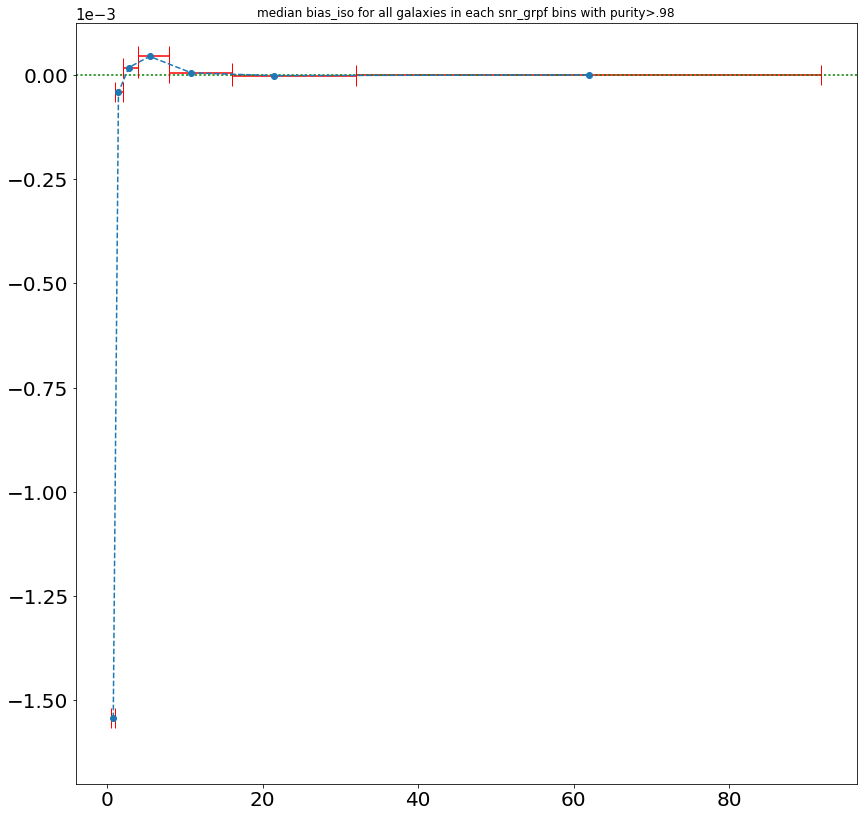

In [101]:
# cat = main_catsLSST[4]
# isolated_cat = iso_gal(cat)
# # final_bins = np.round(bin_edges)
# # final_bins = [1.95,2,7,8,9,23287]
# print 'snrs: '
# print final_bins


# title = 'median bias_grp for galaxies in each snr_grpf bins with purity>.98'
# plot_snr_bias(isolated_cat,title,'bias_g1_grp',final_bins)

# iso_cat = cat[cat['grp_size'] == 1]
# title = 'median bias_iso for galaxies in each snr_grpf bins with grp_size=1'
# plot_snr_bias(iso_cat,title,'bias_g1')

# title = 'median bias_grp for galaxies in each snr_grpf bins with grp_size=1'
# plot_snr_bias(iso_cat,title,'bias_g1_grp')


In [ ]:
#how to make the statistical significance of each bin the same?
#can we use np.std as a proxy for the error? 

3.55261e-06 23287.2
[0.00023791754, -0.00021655418, 0.00013253045, -5.0811257e-05, -0.00016252697, 5.9642953e-05, 4.4152996e-05, -0.00025313449, -0.00034184734, 9.1191241e-06, 2.3231314e-05, 1.4585296e-05, -0.00022701142, -4.6858069e-05, 0.00028618702, 0.0003024555, -6.9116072e-06, -2.4297591e-05, 4.184596e-06, 9.6272352e-06, -9.7630778e-05, 7.7119621e-05, -4.0623487e-05, -1.0150118e-05, -7.1853341e-05, 0.00020570871, -0.00015001922, 0.00026542024, -7.2085641e-05, -7.4750118e-05, -2.3081075e-06, 6.081264e-06, -7.9538891e-05, -9.055651e-05, 0.00019522097, -5.2463809e-05, 8.6244603e-05, -5.1387051e-06, 7.2244133e-05, -1.124998e-05, 5.6691977e-05, 1.421714e-05, 3.4184792e-05, -3.5662729e-06, -0.0001204392, 2.6642545e-07, -7.0111069e-05, -2.6688189e-05, -1.4423919e-05, -1.2340506e-06, -5.2612726e-05, 5.9434788e-05, 2.1301551e-06, 3.1623091e-05, 5.9210633e-05, 1.4265937e-05, -4.3959692e-05, 0.00016555138, 1.1022501e-05, 4.6243043e-05, 1.3774147e-06, 1.7790451e-05, -5.2176811e-06, -0.0001076

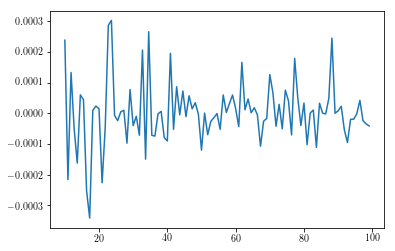

In [99]:
cat = main_catsLSST[4]
isolated_cat = iso_gal(cat)
snr_min,snr_max = np.min(cat['snr_grpf']), np.max(cat['snr_grpf'])
print snr_min, snr_max
snrs = np.linspace(10,100, 100)
y = []
for i in range(len(snrs)-1):
    small_cat = down_cut(up_cut(isolated_cat,'snr_grpf',snrs[i]),'snr_grpf',snrs[i+1])
    small_g1 = np.median(small_cat['bias_g1_grp'])
    y.append(small_g1)
print y   
plt.plot(snrs[0:99],y)

## does g2!= 0 matter? 

In [35]:
filters = [good,best]

In [36]:
results1 = fits.open('/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20-g2_0/final_fits.fits')
table1 = not_bad(get_non_duplicated_cat(Table.read(results1,hdu=1)))

In [37]:
select_table1 = selection_filter([table1,main_catsLSST[4]],filters,shear_zero_cat=main_catsLSST[4])

/Users/Ismael/miniconda2/lib/python2.7/site-packages/astropy/table/table.py:2525: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  result = self.as_array() == other


In [38]:
final_table1 = select_table1[0]

In [54]:
#get their errors too bc why not: 
final_err1 = errs_param_boot([final_table1],'bias_g1', np.median)[0] 
final_err1_grp = errs_param_boot([final_table1],'bias_g1_grp', np.median)[0]  
final_err2 = errs_param_boot([final_table1],'bias_g2', np.median)[0]  
final_err2_grp = errs_param_boot([final_table1],'bias_g2_grp', np.median)[0]  

just to check that symmetry is respected print both percentiles: [  2.09058817e-06   2.05865945e-06]
just to check that symmetry is respected print both percentiles: [  5.51654375e-06   5.22874325e-06]
just to check that symmetry is respected print both percentiles: [  1.34229281e-07   1.20629168e-07]
just to check that symmetry is respected print both percentiles: [  2.72324985e-06   2.53509552e-06]


In [57]:
#errors for original cats. 
selection_cats = selection_filter(main_catsLSST,filters)
errs_LSSTgood_g1grp = errs_param_boot(selection_cats,'bias_g1_grp', np.median) 
errs_LSSTgood_g1iso = errs_param_boot(selection_cats,'bias_g1', np.median) 
errs_LSSTgood_g2grp = errs_param_boot(selection_cats,'bias_g2_grp', np.median) 
errs_LSSTgood_g2iso = errs_param_boot(selection_cats,'bias_g2', np.median) 

just to check that symmetry is respected print both percentiles: [  5.66081144e-06   4.76501009e-06]
just to check that symmetry is respected print both percentiles: [  4.99255839e-06   5.14991552e-06]
just to check that symmetry is respected print both percentiles: [  3.70730166e-06   3.81207246e-06]
just to check that symmetry is respected print both percentiles: [  4.14957289e-06   3.93914524e-06]
just to check that symmetry is respected print both percentiles: [  3.03409479e-06   2.78689924e-06]
just to check that symmetry is respected print both percentiles: [  3.33882706e-06   3.36601443e-06]
just to check that symmetry is respected print both percentiles: [  4.08738924e-06   3.84500345e-06]
just to check that symmetry is respected print both percentiles: [  4.67656355e-06   4.83145530e-06]
just to check that symmetry is respected print both percentiles: [  5.27724842e-06   4.90509774e-06]
just to check that symmetry is respected print both percentiles: [  2.46952550e-06   1.9901

In [58]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [62]:
#compare the medians from this catalogue to the other one 
print 'median bias and error g1 iso for g1 = .02, g2 = 0: {:.3g}, {:.3g}'.format(np.median(final_table1['bias_g1']),final_err1) 
print 'median bias g1 grp for g1 = .02, g2 = 0: {:.3g}, {:.3g}'.format(np.median(final_table1['bias_g1_grp']),final_err1_grp) 
print 'median bias g2 iso for g1 = .02, g2 = 0: {:.3g}, {:.3g}'.format(np.median(final_table1['bias_g2']),final_err2) 
print 'median bias g2 grp for g1 = .02, g2 = 0: {:.3g}, {:.3g}'.format(np.median(final_table1['bias_g2_grp']),final_err2_grp) 
print 
print 'median bias and error g1 iso for g1 = .02, g2 = 0.2: {:.3g}, {:.3g}'.format(np.median(selection_cats[8]['bias_g1']),errs_LSSTgood_g1iso[8]) 
print 'median bias g1 grp for g1 = .02, g2 = 0.2: {:.3g}, {:.3g}'.format(np.median(selection_cats[8]['bias_g1_grp']),errs_LSSTgood_g1grp[8]) 
print 'median bias g2 iso for g1 = .02, g2 = 0.2: {:.3g}, {:.3g}'.format(np.median(selection_cats[8]['bias_g2']),errs_LSSTgood_g2iso[8]) 
print 'median bias g2 grp for g1 = .02, g2 = 0.2: {:.3g}, {:.3g}'.format(np.median(selection_cats[8]['bias_g2_grp']),errs_LSSTgood_g2grp[8]) 





median bias and error g1 iso for g1 = .02, g2 = 0: 2.62e-05, 2.06e-06
median bias g1 grp for g1 = .02, g2 = 0: 5.23e-05, 5.23e-06
median bias g2 iso for g1 = .02, g2 = 0: -3.93e-09, 1.21e-07
median bias g2 grp for g1 = .02, g2 = 0: -1.25e-06, 2.54e-06

median bias and error g1 iso for g1 = .02, g2 = 0.2: 2.62e-05, 2.18e-06
median bias g1 grp for g1 = .02, g2 = 0.2: 5.39e-05, 4.91e-06
median bias g2 iso for g1 = .02, g2 = 0.2: 2.67e-05, 2.27e-06
median bias g2 grp for g1 = .02, g2 = 0.2: 5.39e-05, 4.87e-06


In [95]:
len(good(best(main_catsLSST[4])))

119215

In [83]:
float(len(good(main_catsLSST[4])))/len(main_catsLSST[4])

0.1824055306854245

## Investigate something about the noise 

In [ ]:
reader = descwl

(array([  10949.,   14339.,   20604.,   34772.,  200836.,  164227.,
          28312.,   16764.,   11837.,    8918.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

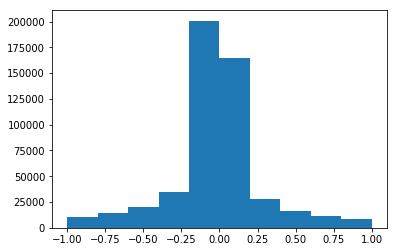

In [25]:
plt.hist(main_catsLSST[0]['bias_g1'], range=(-1, 1))

(array([   9027.,   11976.,   16873.,   28375.,  163377.,  201710.,
          35065.,   20414.,   14235.,   10916.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

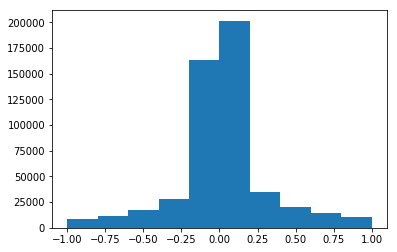

In [27]:
plt.hist(main_catsLSST[8]['bias_g1'], range=(-1, 1))

In [28]:
np.median(main_catsLSST[8]['bias_g1_grp'])

0.0019790705

# Unused functions 

In [ ]:
def plot_purity_bias(cat,param, puritys, yrange=None,xrange=None, xlabel = None, 
                  ylabel = None, ls=None,title = None, xlogscale = False, scientific = False ): 
    
    plt.rc('text', usetex = True)
    fig, ax = plt.subplots(figsize=(10,10))
    
    x = []
    y = []
    errs_x1 = []
    errs_x2 = []
    #errs_y = [] 
    
    small_cats = [] 
    
    print('puritys', puritys ) 
    for i in range(len(puritys)-1):
        small_cat = down_cut(up_cut(cat,'purity',puritys[i]),'purity',puritys[i+1])
        
        #if the cutted catalogue turns out to be empty, ignore it. 
        if len(small_cat) == 0: 
            continue 
        
        small_cats.append(small_cat) 
        
        median_purity = np.median(small_cat['purity'])
        small_param = np.median(small_cat[param])
        
        #want 'error bars on x' showing the extent of the bin widths
        errs_x1.append(np.absolute(puritys[i] - median_purity))
        errs_x2.append(np.absolute(puritys[i+1] - median_purity))
        
        #print the error for this param, we want all of them to be the same 
        x.append(median_purity)
        y.append(small_param)

    
    # put the errors into a list 
    x_errs = [np.array(errs_x1),np.array(errs_x2)]
    #x_errs[1][-1] = 1.0 #make the last one symmetric to avoid running off plot 
    x = np.array(x)
    y = np.array(y)
    
    #get y errs, this are the error in the median shear bias calculated 
    y_errs = errs_param_boot(small_cats,param, np.median,N=1000)
        
    print('x_errs')
    print(x_errs)
    print()
    print('y_errs')
    print(y_errs )
    print() 
    
    
    
    ########################################## formating ##########################################
        
    #ax.set_yscale('log')
    if xlogscale: 
        ax.set_xscale('log')
    
    if yrange: 
        ax.set_ylim(yrange)
    if xrange: 
        ax.set_xlim(xrange)
        
    ax.set_title(title, size =28)
    ax.set_xlabel(xlabel, size = 24)
    ax.set_ylabel(ylabel, size = 24)
        
    
    ax.tick_params(axis='both', which='major', labelsize=20)

    #scientfic notation. 
    if scientific == True: 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(15)
        
    elif scientific == 'yes': 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(1)
    
    ax.axhline(y=0.0, color='g', linestyle=':')    
    
    print('x')
    print(x)
    print() 
    print('y')
    print(y)
    print()

    if ls: 
        ax.errorbar(x,y,xerr=x_errs,marker='o',ls=ls,ecolor='r',capsize=5)
    else: 
        ax.errorbar(x,y,xerr=x_errs,yerr=y_errs,fmt='o',capsize=5,ecolor='r')

